In [1]:
DATA_DIR = './'

# -----------------------------------
# Test and train folder
# Data folder: drive > My Drive > Zindi-UmojaHackathon > data 
# -----------------------------------
TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'

PLOTS_DIR = f'{DATA_DIR}/plots'

OUTPUT_DIR = f'{DATA_DIR}/output'
MODEL_CHECKPOINT_DIR = f'{DATA_DIR}/models'

## Prerequisites

In [8]:
class LabelEncoder:
    def __init__(self, items) -> None:
        self.items = items
        self.size = int(len(self.items))
        self.items = {item:ix for ix,item in enumerate(self.items)}

    def __len__(self):
        return self.size

    def __call__(self, input):
        return self.encode(input)

    def encode(self, item):
        if item in self.items.keys():
            return int(self.items[item])  

        # self.OOV    
        return self.size

    def decode(self, ix):
        pass

In [9]:
import pandas as pd
import numpy as np

def pad_sequence(sequence: pd.DataFrame, encoder: LabelEncoder, pad_value: int=0):
    pad_list = sorted(set(range(0, len(encoder) + 1)).difference(set(sequence['sku_coded'].values)))
    pad_df = pd.DataFrame(pad_value, index=range(len(pad_list)), columns=sequence.columns)
    pad_df['sku_coded'] = pad_list
    pad_df['month'] = sequence['month'].iloc[0].astype(int)
    pad_df['year'] = sequence['year'].iloc[0].astype(int)
    
    return pad_df

def pad_sku_sequence(features: pd.DataFrame, encoder:LabelEncoder, pad_value: int=0):
    features = features.groupby('sku_name').mean().reset_index()

    return features.append(pad_sequence(features, encoder, pad_value))

def pad_targets(targets: pd.DataFrame, target_series, pad_value: int=np.nan):
    missing = set(target_series).difference(set(targets[['month', 'year']].apply(tuple, axis=1).values))
    
    if missing:
        pad_df = pd.DataFrame(pad_value, index=range(len(missing)), columns=targets.columns)

        pad_df['sku_name'] = targets['sku_name'].values[0]
        # pad_df['sku_coded'] = targets['sku_coded'].values[0]
        pad_df['month'] , pad_df['year'] = zip(*missing)
        targets = targets.append(pad_df)

    return targets

In [10]:

def get_sequence_index(train: pd.DataFrame):
    x_train_idx, y_train_idx = [], []
    x_val_idx, y_val_idx = [], []
    
    dates = sorted([(m, y) for y,m in train.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))
    size = train.groupby(['year', 'month']).ngroups//LOOKBACK
    
    for i in tqdm(range(size), desc='retrieving walk forward indices'):
        start = i*LOOKBACK
        train_ix = (i+1)*LOOKBACK
        val_ix = (i+2)*LOOKBACK
        

        x_train_date = dates[start:train_ix]
        y_train_date = dates[train_ix: train_ix+N_STEPS]

        x_val_date = dates[train_ix:val_ix]
        y_val_date = dates[val_ix: val_ix+N_STEPS]
        
        if val_ix+N_STEPS>train.groupby(['year', 'month']).ngroups:
            break
            
        x_train_idx.append(train[train[['month', 'year']].apply(tuple, axis=1).isin(x_train_date)].index)
        y_train_idx.append(train[train[['month', 'year']].apply(tuple, axis=1).isin(y_train_date)].index)

        x_val_idx.append(train[train[['month', 'year']].apply(tuple, axis=1).isin(x_val_date)].index)
        y_val_idx.append(train[train[['month', 'year']].apply(tuple, axis=1).isin(y_val_date)].index)
        
    return (x_train_idx, y_train_idx), (x_val_idx, y_val_idx)
 
def _pad_target(x,y, encoder: LabelEncoder):
    final_date = sorted([(m,yr) for yr,m in x[['year', 'month']].apply(tuple, axis=1)],\
                        key=lambda g: (g[1], g[0]), reverse=True)[0]
    
    target_dates = [(final_date[0]+n, final_date[1])\
                    if final_date[0]<12 else (final_date[0]-(12-1),final_date[1]+1)\
                    for n in range(1,N_STEPS+1)]
    
    y = y.groupby(['year', 'month']).apply(pad_sku_sequence, 
                                                    encoder=encoder, 
                                                    pad_value=np.nan).reset_index(drop=True)
    return y

def prepare_sequence(x_train: pd.DataFrame,
                     x_val: pd.DataFrame,
                     y_train: tuple,
                     y_val: tuple, 
                     encoder: LabelEncoder, 
                     target_cols: list,
                     step: int,
                     x_scaler,
                     y_scale):
 
    y_test = y_val.copy()
    x_train['sku_coded'], x_val['sku_coded'] = x_train['sku_name'].apply(encoder), x_val['sku_name'].apply(encoder) 
    y_train['sku_coded'], y_val['sku_coded'] = y_train['sku_name'].apply(encoder), y_val['sku_name'].apply(encoder) 

    # print(y_train, y_val)
    y_train = _pad_target(x_train, y_train, encoder)
    y_val = _pad_target(x_val, y_val, encoder)
    # print(y_train, y_val)
    x_train = x_train.groupby(['year', 'month']).apply(pad_sku_sequence, encoder=encoder).reset_index(drop=True)
    x_val = x_val.groupby(['year', 'month']).apply(pad_sku_sequence, encoder=encoder).reset_index(drop=True)
    
    y_test['sku_coded'] = y_test.sku_name.apply(encoder)
    y_test = y_test.sort_values(by=['sku_name','year','month'])[['sku_coded','sku_name']+target_cols]
    
    y_test['idx'] = SEED
    y_test = y_test.groupby('sku_name').apply(lambda x: func(x, x.name)).reset_index(drop=True)

    y_train = y_train.groupby(['sku_coded','year','month']).mean().sort_values(by=['sku_coded','year','month']).reset_index()
    y_val = y_val.groupby(['sku_coded','year','month']).mean().sort_values(by=['sku_coded','year','month']).reset_index()
    
    return (x_train.sort_values(by=['year','month','sku_coded']).reset_index(drop=True), y_train[target_cols]), (x_val.sort_values(by=['year','month','sku_coded']).reset_index(drop=True), y_val[target_cols]), y_test

  
def func(gp, name):
    dates = sorted([(m,y) for y,m in gp.groupby(['year','month']).groups.keys()], key= lambda g: (g[1],g[0]))
    gp = gp.sort_values(['year','month'])

    if len(gp)<N_STEPS:
        idx = [dates.index((date[1],date[0])) for date in gp[['year','month']].apply(tuple, axis=1)]
        # gp['rule'] = 0
        gp['idx'] = idx

        return gp

    if len(gp)==N_STEPS:
        # gp['rule'] = 1
        # gp['n_repeat'] = int(len(gp)/N_STEPS)
        # print(gp)
        gp['idx'] = list(range(N_STEPS))

        return gp

    for date in dates:
        idx = dates.index(date)
        # gp.at[(gp.month==date[0])&(gp.year==date[1]), 'rule'] = 2
        gp.loc[(gp.month==date[0])&(gp.year==date[1]), 'idx'] = idx
        # gp.at[(gp.month==date[0])&(gp.year==date[1]), 'n_repeat'] = len(gp[(gp.month==date[0])&(gp.year==date[1])])
    
    return gp

        

In [11]:
import torch
import numpy as np
from torch.utils.data import Dataset
from tqdm.notebook import tqdm

def impute_missing(data, cols):
    temp = pd.DataFrame()
    for d in tqdm(data, desc='imputing missing values'):
        temp = pd.concat([temp, d[0][1]])
        d[0][1][cols] = temp.groupby('sku_coded')[cols].transform(lambda x: x.fillna(x.median())).iloc[-len(d[0][1]):]
        d[0][1][cols] = temp.groupby(['year', 'month'])[cols].transform(lambda x: x.fillna(x.median())).iloc[-len(d[0][1]):]

def collate_fn(batch):
    x, y, y_test = [],[],[]
    # print(len(batch[0][0]))
    for xi, yi, yt in batch:
        # print(xi.shape)
        x.append(xi)
        y.append(yi)
        y_test.append(yt)

    return torch.stack(x), torch.stack(y), y_test

def prepare_data_scaler(x_scaler, y_scaler, target_scaler, train_data, val_data):
    x_df = pd.concat([d[0][0] for d in train_data+val_data], axis=0)
    y_df = pd.concat([d[0][1] for d in train_data+val_data], axis=0)
      
    x_scaler.fit(x_df.drop(columns=['sku_name', 'sku_coded']))
    y_scaler.fit(y_df.drop(columns=['sku_coded']))
    target_scaler.fit(x_df['sellin'].values.reshape(-1,1))

    return x_scaler, y_scaler, target_scaler

def normalize_data(train_data: list, val_data:list, x_scaler, y_scaler):
    train_list, val_list = [], []

    for t,v in tqdm(zip(train_data,val_data), desc='normalizing data', total=len(train_data)): 
        xt, yt = t[0][0].copy(), t[0][1].copy()
        xv, yv = v[0][0].copy(), v[0][1].copy()
        x_cols = [c for c in xt.columns if c not in ['sku_name','sku_coded']]
        y_cols = [c for c in yt.columns if c not in ['sku_name','sku_coded']]

        xt[x_cols], yt[y_cols] = x_scaler.transform(xt[x_cols]), y_scaler.transform(yt[y_cols])
        xv[x_cols], yv[y_cols] = x_scaler.transform(xv[x_cols]), y_scaler.transform(yv[y_cols])

        train_list.append(((xt,yt),t[1]))
        val_list.append(((xv,yv),v[1]))

    return train_list, val_list

def get_data(train: pd.DataFrame, train_idx, val_idx, encoder: LabelEncoder, target_cols: list):
    train_list, val_list = [], []

    for ix in tqdm(range(len(train_idx[0])), desc='preparing sequences'):
        x_train, x_val = train.iloc[train_idx[0][ix]].reset_index(drop=True), train.iloc[val_idx[0][ix]].reset_index(drop=True)
        y_train, y_val = train.iloc[train_idx[1][ix]].reset_index(drop=True), train.iloc[val_idx[1][ix]].reset_index(drop=True)

        train_data, val_data, y_test = prepare_sequence(x_train, x_val, y_train, y_val, encoder, target_cols, ix, x_scaler, y_scaler)

        train_list.append((train_data, y_test))
        val_list.append((val_data, y_test))

    return train_list, val_list, [c for c in train_data[0].columns if c not in ['sku_name','year','month','sku_coded']]


# class FossilDataset(Dataset):
#     def __init__(self, 
#                  data, 
#                  feat_cols, 
#                  target_cols, 
#                  feat_scaler,
#                  target_scaler, 
#                  non_padded_df):
      
#         self.data = data
#         self.feat_cols = feat_cols
#         self.target_cols = target_cols
#         self.feature_scaler = feat_scaler
#         self.target_scaler = target_scaler
#         self.non_padded = non_padded_df

#     def __len__(self):
#         return len(self.data)#len(self.data.groupby('sku_coded').mean())

#     def __getitem__(self, idx):
        
#         feat_group = self.data[idx].sort_values(['sku_coded','year','month']).groupby('sku_coded').mean().groupby(['month','year'])
#         # print([v[self.feat_cols].shape for k,v in feat_group])

#         seq = np.array([self.feature_scaler.transform(v[self.feat_cols].reset_index(drop=True)) for k,v in feat_group]) #(timesteps, products, features)
#         seq = np.transpose(seq, (2,0,1)) #(features, timesteps, products)
        
#         targets = self.data[idx].sort_values(['sku_coded','year','month']).groupby('sku_coded').mean()
#         targets = self.target_scaler.transform(targets[self.target_cols].values.reshape(-1,1)) #(timesteps*products, target)
#         # print(torch.as_tensor(targets), torch.as_tensor(targets.reshape(-1)).shape)
        
#         return torch.as_tensor(seq), torch.as_tensor(targets.reshape(-1)), self.non_padded


class FossilDataset(Dataset):
    def __init__(self, 
                 data: list, 
                 encoder:LabelEncoder,
                 training: bool=True):
      
        self.data = data
        self.encoder = encoder

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        (self.features, self.targets), y_test = self.data[idx]
        
        feat_group = self.features.sort_values(['sku_coded','year','month']).groupby(['month','year'])

        seq = np.array([v.drop(columns=['year','month', 'sku_name', 'sku_coded']) for k,v in feat_group]) #(timesteps, products, features)
        seq = np.transpose(seq, (2,0,1)) #(features, timesteps, products)
        
        targets = self.targets.sort_values(['sku_coded','year','month'])
        targets = targets.drop(columns=['month', 'year','sku_coded']).values #(timesteps*products, target)
        # print(torch.as_tensor(targets), torch.as_tensor(targets.reshape(-1)).shape)
        return torch.as_tensor(seq), torch.as_tensor(targets.reshape(-1)), y_test

    


In [12]:
import torch
import torch.nn as nn

class FossilEncoder(nn.Module):
    def __init__(self, 
                 n_features: int, 
                 n_extracts: int,
                 n_products: int,
                 n_steps: int):
        super(FossilEncoder, self).__init__()

        self.monthly_conv2d = nn.Conv2d(n_features, n_extracts, (1,1))
        self.periodic_conv2d = nn.Conv2d(n_extracts, n_extracts, (1, n_products))
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.2)

        self.fc1 = nn.Linear(n_extracts*LOOKBACK, n_steps*12)
        self.fc2 = nn.Linear(n_steps*12, n_steps*n_products)

    def forward(self, x):
        print(x.shape)
        x = self.monthly_conv2d(x)
        x = self.relu(x)
        

        x = self.periodic_conv2d(x)
        x = self.relu(x)
        print(x.shape)
        x = x.view(x.size(0),-1)
        
        out = self.fc1(self.dropout(x))
        out = self.relu(out)
        
        return self.fc2(out)

In [13]:
class FossilDecoder(nn.Module):
    def __init__(self, 
                 n_extracts, 
                 hidden_size,
                 output_size,
                 n_steps,
                 n_products,
                 n_features,
                 num_layers=2,
                 bidirectional=True):
        super(FossilDecoder, self).__init__()
        
        self.monthly_conv2d = nn.Conv2d(n_features, n_extracts, (1,1))
        self.periodic_conv2d = nn.Conv2d(n_extracts, n_extracts, (1, n_products))
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.2)

        self.rnn = nn.GRU(n_extracts, hidden_size, num_layers, bidirectional=bidirectional, batch_first=True)
        self.relu = nn.ReLU(inplace=True)
        
        self.fc1 = nn.Linear(hidden_size*2, output_size) if bidirectional else nn.Linear(hidden_size, output_size)
        self.fc2 = nn.Linear(output_size, n_steps*n_products)       
        
    def forward(self, x):
        inputs = []
        for t in range(x.size(2)):
            xi = self.monthly_conv2d(x[:, :, t, :].unsqueeze(2))
            xi = self.relu(xi)


            xi = self.periodic_conv2d(xi)
            xi = self.relu(xi).squeeze(-1)
            inputs.append(xi)
            
        x = torch.cat(inputs, 2).transpose(1,2)
        
        x,_ = self.rnn(x)
        out = self.relu(self.fc1(x))
        
        return torch.mean(self.fc2(out),1)

In [14]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import re
import time
import random
import numpy as np
from time import time
from pathlib import Path
        
class IterMeter(object):
    """keeps track of total iterations"""
    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val

class ModelTrainer:
    def train_model(self, early_stop=3, verbose=10, save_path=None):
        
        stop_eps = 0 
        best_epoch = None
        metrics = {'MAE':[]}
        start_time = time()
        accum_loss = torch.tensor(float('inf')) if not self.resume_train else torch.tensor(float(re.findall("\d+\.\d+", self.model_weights)[0]))
        try:
            for epoch in range(1, ModelsConfig.EPOCHS + 1):
                train_loss = self.train_step(epoch, 1500)             
                test_loss, w8, mae = self.val_step(epoch)

                if test_loss < accum_loss:
                    best_epoch = epoch
                    accum_loss = test_loss
                    best_mae = mae

                    self.model_checkpoints.append((w8, test_loss, mae))
                    stop_eps = 0
                else:
                    stop_eps += 1
                if epoch % verbose ==0:
                    print('Epoch {}: Train Loss: {:.4f}\tVal Loss: {:.4f}\tVal MAE: {:.2f}\telapsed: {:.2f} mins'.format(
                    epoch, torch.mean(train_loss), test_loss, mae, (time()-start_time)/60))
                

                if stop_eps >= early_stop:
                    self.save_model_checkpoint(save_path)
                    print('\n')
                    print('Early stopping: Best Epoch: {}\tVal loss: {:.4f}\tVal MAE: {:.2f}\tTotal time elapsed: {:.2f} mins'.format(
                        best_epoch, accum_loss, best_mae, (time()-start_time)/60))
                    print('-'*50)
                    print('\n')
                    break

        except KeyboardInterrupt:
            self.save_model_checkpoint(save_path) if self.model_checkpoints else print("first epoch not completed, model checkpoint will not be saved")
            
            if stop_eps<early_stop:
                print(f'Training stopped, early stop not reached. Best Iteration: {best_epoch} Val loss: {accum_loss} Val MAE: {mae}')

    def save_model_checkpoint(self, save_path):
        best_model, accum_loss, metrics = self.model_checkpoints[-1]

        if save_path is not None:
            torch.save(best_model, Path(save_path).joinpath(f'loss_{accum_loss}_MAE_{metrics}_fossil.pth'))

    def load_model_checkpoint(self, save_path):
        self.model.load_state_dict(torch.load(Path(save_path)))            

class Pipeline(ModelTrainer):
    def __init__(self, train_dataloader, test_dataloader, model, target_scaler, resume_from_checkpoint=False, model_weights=None):
        
        self.model = model.to(ModelsConfig.device) 
        self.resume_train = resume_from_checkpoint
        self.model_weights = model_weights
        self.target_scaler = target_scaler

        if self.resume_train:
            assert model_weights is not None, "specify model weights save location"
            self.load_model_checkpoint(self.model_weights)

        self.train_loader = train_dataloader
        self.test_loader = test_dataloader

        self.criterion = nn.L1Loss()
        self.optimizer = optim.AdamW(self.model.parameters(), lr=ModelsConfig.learning_rate)
        
        self.model_checkpoints = []

    def train_step(self, epoch, verbose):
        self.model.train()
        
        train_loss=[]
        start_time = time()
        data_len = len(self.train_loader.dataset)

        for batch_idx, (inputs,labels, y_) in enumerate(self.train_loader):
            inputs = inputs.to(ModelsConfig.device)
            labels = labels.to(ModelsConfig.device)

            self.optimizer.zero_grad()
            preds = self.model(inputs)
            
            # na_idx = list(labels.isnan().nonzero().transpose(0,1))
            # labels[na_idx] = preds[na_idx]

            loss = self.criterion(preds,labels)
            loss.backward()

            self.optimizer.step()
            train_loss.append(loss.item())
            # if batch_idx % verbose == 0 or batch_idx == len(self.train_loader)-1:
            #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\telapsed: {:.2f} mins'.format(
            #         epoch, (batch_idx * len(inputs))+1, data_len, 100. * batch_idx / len(self.train_loader), loss.item(), (time()-start_time)/60))
                
        return loss
    def val_step(self, epoch):
        # print('\nevaluating…')
        self.model.eval()
        test_loss = 0
        mae = 0
        with torch.no_grad():
            for batch_idx, (inputs, labels, y_) in enumerate(self.test_loader):
                if batch_idx==(len(self.test_loader)-1):
                    inputs = inputs.to(ModelsConfig.device)
                    labels = labels.to(ModelsConfig.device)

                    self.optimizer.zero_grad()

                    preds = self.model(inputs)
                    # na_idx = list(labels.isnan().nonzero().transpose(0,1))
                    # labels[na_idx] = preds[na_idx]

                    loss = self.criterion(preds,labels)

                    test_loss += loss.item()# / len(self.test_loader)
                    mae += self.eval_step(y_, preds)# / len(self.test_loader)

        # print('Test set: Average loss: {:.4f} | MAE: {:.4f}\n'.format(test_loss, mae))

        return round(test_loss, 4), self.model.state_dict(), mae

#     def eval_step(self, labels, preds):
#         mae = 0
#         preds = preds.cpu().detach().numpy().reshape(-1, N_STEPS)
        
#         for i,label in enumerate(labels):
#             pred_array = preds[label.sku_coded.astype(int).values, :]

#             y_true = label[[f'target_{i}' for i in range(N_STEPS)]].values.reshape(-1, 1)
#             y_pred = self.target_scaler.inverse_transform(pred_array.reshape(-1, 1))
#             # label['y_pred'] = y_pred.reshape(-1,)
#             mae += np.absolute(np.subtract(y_true, y_pred)).mean()/len(labels)

#         return mae
    
    def eval_step(self, labels: list, preds):
        mae = 0
        preds = preds.cpu().detach().numpy().reshape(len(labels), -1)
        
        # pandarallel.initialize(use_memory_fs=False)

        for i,label in enumerate(labels):
            pred_arr = preds[i].reshape(-1, N_STEPS, 6)
            label['y_true'] = label['sellin'].copy()
            label['y_pred'] = pred_arr[label.sku_coded.values, label.idx.values, 0]
            
            y_true = label['y_true'].values.reshape(1, -1)
            y_pred = self.target_scaler.inverse_transform(label['y_pred'].values.reshape(1, -1))
            label['y_pred'] = y_pred.reshape(-1,)
            mae += np.absolute(np.subtract(y_true, y_pred)).mean()/len(labels)

        return mae

    def func(self, gp, name, preds):
        dates = sorted([(m,y) for y,m in gp.groupby(['year','month']).groups.keys()], key= lambda g: (g[1],g[0]))
        gp = gp.sort_values(['year','month'])

        if len(gp)<N_STEPS:
            idx = [dates.index((date[1],date[0])) for date in gp[['year','month']].apply(tuple, axis=1)]
            gp['sellin'] = preds[name, :len(gp)]

            return gp

        if len(gp)%N_STEPS==0:
            gp['sellin'] = np.tile(preds[name, :], int(len(gp)/N_STEPS))

            return gp

        for date in dates:
            idx = dates.index(date)
            gp.loc[(gp.month==date[0])&(gp.year==date[1]), 'sellin'] = np.tile(preds[name, idx], len(gp[(gp.month==date[0])&(gp.year==date[1])]))
        
        return gp

    def make_oof_preds(self):
        self.model.eval()
        with torch.no_grad():
            for batch_idx, (inputs, labels, y_) in enumerate(self.test_loader):
                if batch_idx==(len(self.test_loader)-1):
                    inputs = inputs.to(ModelsConfig.device)
                    labels = labels.to(ModelsConfig.device)

                    self.optimizer.zero_grad()
                    return self.model(inputs)

In [15]:
def prepare_test_data(train: pd.DataFrame, test_dates:list, x_scaler=None):
    test_context = train[train[['month','year']].apply(tuple, axis=1).isin(test_dates)].reset_index(drop=True)
    scale_cols = [c for c in test_context.columns if c not in ['sku_name','sku_coded']]

    test_context['sku_coded'] = test_context['sku_name'].apply(sku_encoder)
    test_context = test_context.groupby(['year', 'month']).apply(pad_sku_sequence, encoder=sku_encoder).reset_index(drop=True)
    test_context[scale_cols] = x_scaler.transform(test_context[scale_cols])

    test_gp = test_context.sort_values(['sku_name','year','month']).groupby(['month','year'])
    test_seq = np.array([v.drop(columns=['sku_name','year','month','sku_coded']) for k,v in test_gp])

    return np.transpose(test_seq, (2,0,1))

def merge_func(gp, name, pred_array):
    gp = gp.sort_values(['year','month'])
    gp['sellin'] = np.tile(pred_array[name, :], int(len(gp)/N_STEPS))
    
    return gp

def make_predictions(seq: np.array, model: FossilEncoder, test_df: pd.DataFrame):
    preds = model(torch.as_tensor(seq).unsqueeze(0).to(ModelsConfig.device))
    pred_arr = preds.detach().numpy().reshape(-1, N_STEPS)
    test_df['sellin'] = pred_arr[test_df.sku_coded.values, test_df.idx.values]
    
    return test_df.copy()

def make_submission(predictions: pd.DataFrame, dates: list, target_scaler=None):
    predictions['Target'] = predictions['sellin']
    predictions['Item_ID'] = predictions['sku_name'].astype(str)+'_'+predictions['month'].astype(str)+'_'+predictions['year'].astype(str)
    
    if target_scaler is not None:
        predictions['Target'] = target_scaler.inverse_transform(predictions['Target'].values.reshape(-1,1))
    
    date_id = [f'{m}_{y}' for m,y in dates]
    sub = pd.DataFrame(predictions.sort_values('sku_name', ascending=False).sku_name.astype(str)+'_'+date_id*predictions.sku_name.nunique())
    sub = sub.reset_index(drop=True).rename(columns={'sku_name':'Item_ID'})
    
    return sub.merge(predictions[['Item_ID', 'Target']])

In [16]:

def cyclic_encode(df: pd.DataFrame, columns: list):
    """
    """
    
    for col in columns:
        max_val = df[col].max()

        df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
        df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
        
    return df

In [17]:

def _add_periodic_indices(df: pd.DataFrame):
    """
    
    
    """
    df = df.sort_values(['year','month'])
    # get indices of observations from each product
    # df['idx'] = df.cumcount()
    
    # df['36month_series'] = df['month'] % 36   
    # df['24month_series'] = df['month'] % 24 
    # df['18month_series'] = df['month'] % 18
    df['12month_series'] = df['month'] % 12     
    df['9month_series'] = df['month'] % 9 
    df['6month_series'] = df['month'] % 6 
    df['quarterly_series'] = df['month'] % 3 
    df['2month_series'] = df['month'] % 2 

    return df

In [18]:
def get_fourier_series(df, period: int, order: int=10):
    x = 2*np.pi*np.arange(1, order+1)/period
    t = np.arange(1, len(df)+1)
    x = x*t[:, None]
    series = pd.DataFrame(np.concatenate((np.cos(x), np.sin(x)), axis=1), columns=[f'fourier_{i}' for i in range(x.shape[1]*2)])
    # df['a_fourier'], df['a_fourier'] = np.cos(x), np.sin(x)
    return df.join(series)

In [19]:
def lag_shift(data: pd.DataFrame, 
              group_by_col_name: str, 
              features: list, 
              lag_shift_periods: list):

        """
        """
        df = data.copy()
        df = df.sort_values(by=['year','month'])

        for lp in lag_shift_periods:
            for feat in features:
                forward = f'{lp}month_fwd_lag_{feat}'
                backward = f'{lp}month_bwd_lag_{feat}'
                forw_diff, back_diff = f'{forward}_diff', f'{backward}_diff'

                group = df.groupby(group_by_col_name)[feat]

                # Perform forward lag shift
                df[forward] = group.shift(lp)

                # Perform backwards lag shift
                # df[backward] = group.shift(-lp)

                # Shift difference
                df[forw_diff] = df[feat] - df[forward]
                # df[back_diff] = df[backward] - df[feat]

        return df

In [20]:

# class ModelsConfig():

#     # setting random seed
#     # torch.manual_seed(SEED)

#     # checks if gpu is available
#     use_cuda = torch.cuda.is_available() 
#     device = torch.device("cuda:0" if use_cuda else "cpu")
#     learning_rate = 1e-2

#     EPOCHS = 100000

# class DataConfig():
#     dataloader_params = dict(        
#     batch_size=3,
#     collate_fn= lambda x: collate_fn(x),
#     shuffle=False,
#     # num_workers=2, 
#     # pin_memory=True
#     )


## CNN Pred

In [240]:
import pandas as pd
from tqdm.notebook import tqdm
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=RuntimeWarning)


tqdm.pandas()
train = pd.read_csv(f'{TRAIN_DIR}/Train.csv')
desc = pd.read_csv(f'{DATA_DIR}/DataDictionary.csv')

In [241]:
def assign_dates(gp, dates):
    gp['month'],gp['year'] = zip(*dates)
    return gp

In [242]:

CAT = desc[36:]['Column Name'].tolist()
channel_cols = [c for c in train.columns if any(f'_{i}' in c for i in range(1,11)) and c not in CAT+['sku_name','month','year','sku_coded']]

# zero_cols = filter_zero_cols(train, channel_cols, 0.5)
train_df = train.drop(columns=CAT)#+zero_cols)#+[desc.iloc[36]['Column Name']])#pd.concat([train.drop(columns=CAT),pd.get_dummies(train[CAT])], axis=1)

In [243]:
from sklearn.preprocessing import MinMaxScaler

np.random.seed(SEED)
sku_encoder = LabelEncoder(train.sku_name.sample(frac=0.95).unique())

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

In [244]:
dates = sorted([(m, y) for y,m in train_df.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))

final_date = dates[-1]
xtra = [(final_date[0]+i,final_date[1]) if final_date[0]+i<=12 else (final_date[0]+i-12, final_date[1]+1) for i in range(1,N_STEPS+1)]

In [245]:
xtra_df = pd.DataFrame(np.nan, index=range(train_df.sku_name.nunique()), columns=train_df.columns)
xtra_df['sku_name'] = train_df.sku_name.unique()
xtra_rep = pd.DataFrame(np.repeat(xtra_df.values, N_STEPS, axis=0), columns=train_df.columns)

In [246]:
train_df = pd.concat([train_df, xtra_rep.groupby('sku_name').apply(assign_dates, xtra)]).reset_index(drop=True)
train_df[[c for c in train_df.columns if 'sku_name' not in c]] = train_df.groupby(['sku_name']).transform(lambda x: x.fillna(x.median()))

In [247]:
train_df = train_df.sort_index()

In [248]:

train_data = train_df.copy()
# train_data = prepare_data(train_data, dates, False)

non_missing_dates = {sku:[(m, y) for y,m in train_data[train_data['sku_name']==sku].groupby(['year', 'month']).groups.keys()] for sku in tqdm(train_data['sku_name'].unique())}

train_pad = train_data.groupby('sku_name').progress_apply(pad_data, dates=dates).reset_index(drop=True)

pad_cols = [c for c in train_pad.columns if 'sellin' not in c]
train_pad[pad_cols] = train_pad.groupby('sku_name')[pad_cols].transform(lambda x: x.fillna(0))

train_targeted = train_pad.groupby('sku_name').progress_apply(prepare_targets).reset_index(drop=True)


  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

In [249]:

train_targeted['sku_coded'] = train_targeted['sku_name'].apply(sku_encoder)
# train_targeted = train_targeted.groupby(['month','year']).progress_apply(clean_data, encoder=sku_encoder).reset_index(drop=True)

In [250]:

non_missing_products = train_targeted['sku_coded'].unique()
# print(df)
train_targeted = train_targeted.groupby(['month','year']).apply(pad_sku_sequence, encoder=sku_encoder).reset_index(drop=True)

target_cols = [f'target_{i}' for i in range(N_STEPS)]
cols = [c for c in train_targeted.columns if c not in ['sku_coded','month','year', 'sku_name']+target_cols]
train_targeted.loc[train_targeted['sku_coded']==len(sku_encoder), cols] = np.nan


In [251]:

cols_1 = [c for c in train_targeted.columns if c not in ['sku_name','sku_coded']]
cols_2 = [c for c in train_targeted.columns if c not in ['month','year', 'sku_name', 'sku_coded']]

train_targeted[cols_1] = train_targeted.groupby('sku_name')[cols_1].transform(lambda x: x.fillna(x.median()))
train_targeted[cols_2] = train_targeted.groupby(['month','year'])[cols_2].transform(lambda x: x.fillna(x.median()))

In [252]:
train_idx, val_idx = get_sequence_index(train_targeted)

retrieving walk forward indices:   0%|          | 0/62 [00:00<?, ?it/s]

In [253]:
train_non_padded = [
    train_targeted.iloc[ix].groupby('sku_name').apply(
        lambda x: retrieve_unpadded_sequence(x, x.name, non_missing)).reset_index(drop=True)
    for ix in tqdm(train_idx)]

val_non_padded = [
    train_targeted.iloc[ix].groupby('sku_name').apply(
        lambda x: retrieve_unpadded_sequence(x, x.name, non_missing)).reset_index(drop=True)
    for ix in tqdm(val_idx)]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

In [254]:
target_cols = [f'target_{i}' for i in range(N_STEPS)]
feat_cols = [c for c in train_targeted.columns if all(l not in c for l in ['target','sku_name','sku_coded'])]

x_scaler.fit(train_targeted[feat_cols])
y_scaler.fit(train_targeted[target_cols].values.reshape(-1,1))

# train_targeted[feat_cols] = x_scaler.transform(train_targeted[feat_cols]) 

MinMaxScaler()

In [280]:
from torch.utils.data import DataLoader

window = 3
expanding_window = True
models, metrics_list, loss_list,  = [], [], []
train_set, val_set = [], []

dates = sorted([(m, y) for y,m in train_df.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))

for ix in range(len(train_idx)):
    if expanding_window:
        print('Training step {} from {}/{} to {}/{}:'.format(ix+1, dates[0][0], dates[0][1], dates[ix][0], dates[ix][1]))
        print('\n')
        train_set += [train_targeted.iloc[train_idx[ix]].copy()]    
        val_set += [train_targeted.iloc[val_idx[ix]].copy()]

    # else:
    #     print('Training step {} from {}/{} to {}/{}:'.format(ix+1, dates[ix-window][0], dates[ix-window][1], dates[ix][0], dates[ix][1]))
    #     print('\n')
    #     train_set = [train_norm[i] for i in range(ix-window,ix)] if ix>window else train_norm[:ix+1]
    #     val_set = [val_norm[i] for i in range(ix-window,ix)] if ix>window else val_norm[:ix+1]
        
    train_dataset = FossilDataset(train_set, feat_cols, target_cols, x_scaler, y_scaler, train_non_padded[ix].copy())
    val_dataset = FossilDataset(val_set, feat_cols, target_cols, x_scaler, y_scaler, val_non_padded[ix].copy())
    

    train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=False)
    valid_loader = DataLoader(val_dataset, collate_fn=collate_fn, shuffle=False)
    
    # model = pipe.model if ix>0 else FossilModel(len(features), 4, len(sku_encoder)+1, N_STEPS).double()
    model = FossilEncoder(len(feat_cols), 4, len(sku_encoder)+1, N_STEPS).double()
    pipe = Pipeline(train_loader, valid_loader, model, y_scaler)

    torch.manual_seed(SEED)
    pipe.train_model(5, 5)
    best_model, val_loss, metrics = pipe.model_checkpoints[-1]
    
    models.append(best_model)
    loss_list.append(val_loss)
    metrics_list.append(metrics)
print('Average Val loss: {:.4f}\tAverage Val MAE: {:.4f}'.format(np.mean(loss_list), np.mean(metrics_list)))
print('-'*50)
# print('\n')

Training step 1 from 1/2016 to 1/2016:


Epoch 5: Train Loss: 0.0623	Val Loss: 0.0547	Val MAE: 684731.16	elapsed: 0.00 mins
Epoch 10: Train Loss: 0.0272	Val Loss: 0.0267	Val MAE: 366162.89	elapsed: 0.01 mins
Epoch 15: Train Loss: 0.0200	Val Loss: 0.0198	Val MAE: 304238.88	elapsed: 0.01 mins
Epoch 20: Train Loss: 0.0136	Val Loss: 0.0144	Val MAE: 245290.89	elapsed: 0.01 mins
Epoch 25: Train Loss: 0.0096	Val Loss: 0.0110	Val MAE: 213522.64	elapsed: 0.01 mins
Epoch 30: Train Loss: 0.0072	Val Loss: 0.0089	Val MAE: 196728.19	elapsed: 0.02 mins
Epoch 35: Train Loss: 0.0056	Val Loss: 0.0076	Val MAE: 185531.73	elapsed: 0.02 mins
Epoch 40: Train Loss: 0.0045	Val Loss: 0.0067	Val MAE: 178625.72	elapsed: 0.02 mins
Epoch 45: Train Loss: 0.0038	Val Loss: 0.0060	Val MAE: 174366.42	elapsed: 0.03 mins
Epoch 50: Train Loss: 0.0034	Val Loss: 0.0057	Val MAE: 171887.21	elapsed: 0.03 mins
Epoch 55: Train Loss: 0.0031	Val Loss: 0.0054	Val MAE: 169247.93	elapsed: 0.03 mins
Epoch 60: Train Loss: 0.0028	Val Los

In [281]:
train_set = [train_targeted.iloc[ix].copy() for ix in train_idx]
val_set = [train_targeted.iloc[ix].copy() for ix in val_idx]

In [282]:

train_dataset = FossilDataset(train_set, feat_cols, target_cols, x_scaler, y_scaler, train_non_padded[ix].copy())
val_dataset = FossilDataset(val_set, feat_cols, target_cols, x_scaler, y_scaler, val_non_padded[ix].copy())


train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=False)
valid_loader = DataLoader(val_dataset, collate_fn=collate_fn, shuffle=False)


In [283]:
model = FossilEncoder(len(feat_cols), 4, len(sku_encoder)+1, N_STEPS).double()
pipe = Pipeline(train_loader, valid_loader, model, y_scaler)


In [284]:

torch.manual_seed(SEED)
pipe.train_model(5, 5, save_path=f'{MODEL_CHECKPOINT_DIR}/CNNpred1')

Epoch 5: Train Loss: 0.0036	Val Loss: 0.0032	Val MAE: 105885.20	elapsed: 0.15 mins
Epoch 10: Train Loss: 0.0034	Val Loss: 0.0030	Val MAE: 101096.07	elapsed: 0.30 mins
Epoch 15: Train Loss: 0.0034	Val Loss: 0.0029	Val MAE: 100827.26	elapsed: 0.47 mins


Early stopping: Best Epoch: 11	Val loss: 0.0029	Val MAE: 101616.35	Total time elapsed: 0.50 mins
--------------------------------------------------




In [285]:
model_weights, loss, metrics = pipe.model_checkpoints[-1]

In [338]:

test = pd.read_csv(f'{TEST_DIR}/Test.csv')
dates = sorted([(m, y) for y,m in test.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))

month,yr = dates[0]
test_dates = [(month-n,yr) if month>n else (12+month-n, yr-1) for n in range(1,LOOKBACK+1)]

test_context = train_df.copy()#[train_df[['month', 'year']].apply(tuple, axis=1).isin(test_dates)]

In [339]:
# missing_sku = list(set(test.sku_name.unique()).difference(test_context.sku_name.unique()))
missing_sku = list(set(test.sku_name.unique()).difference(test_context[test_context[['month', 'year']].apply(tuple, axis=1).isin(test_dates)].sku_name.unique()))
test_context = test_context.groupby(['month','year']).apply(add_missing_context, missing_sku=missing_sku).reset_index(drop=True)
# test_context = test_context[test_context.sku_name.isin(test.sku_name.unique())]

In [340]:

# train_data = prepare_data(train_data, dates, False)

non_missing_dates = {sku:[(m, y) for y,m in test_context[test_context['sku_name']==sku].groupby(['year', 'month']).groups.keys()] for sku in tqdm(test_context['sku_name'].unique())}

test_pad = test_context.groupby('sku_name').progress_apply(pad_data, dates=dates).reset_index(drop=True)

pad_cols = [c for c in test_pad.columns if 'sellin' not in c]
test_pad[pad_cols] = test_pad.groupby('sku_name')[pad_cols].transform(lambda x: x.fillna(0))

test_targeted = test_pad.groupby('sku_name').progress_apply(prepare_targets).reset_index(drop=True)


  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/3869 [00:00<?, ?it/s]

In [341]:

test_targeted['sku_coded'] = test_targeted['sku_name'].apply(sku_encoder)
# train_targeted = train_targeted.groupby(['month','year']).progress_apply(clean_data, encoder=sku_encoder).reset_index(drop=True)

In [342]:

non_missing_products = test_targeted['sku_coded'].unique()
# print(df)
test_targeted = test_targeted.groupby(['month','year']).apply(pad_sku_sequence, encoder=sku_encoder).reset_index(drop=True)

target_cols = [f'target_{i}' for i in range(N_STEPS)]
cols = [c for c in test_targeted.columns if c not in ['sku_coded','month','year', 'sku_name']+target_cols]
test_targeted.loc[test_targeted['sku_coded']==len(sku_encoder), cols] = np.nan


In [343]:

cols_1 = [c for c in test_targeted.columns if c not in ['sku_name','sku_coded']]
cols_2 = [c for c in test_targeted.columns if c not in ['month','year', 'sku_name', 'sku_coded']]

test_targeted[cols_1] = test_targeted.groupby('sku_name')[cols_1].transform(lambda x: x.fillna(x.median()))
test_targeted[cols_2] = test_targeted.groupby(['month','year'])[cols_2].transform(lambda x: x.fillna(x.median()))

In [344]:
test_targeted = test_targeted[test_targeted[['month', 'year']].apply(tuple, axis=1).isin(test_dates)]

In [345]:
test_features = test_targeted.sort_values(['sku_coded','year','month']).groupby('sku_coded').mean().groupby(['month','year'])

In [346]:
seq = np.array([x_scaler.transform(v[feat_cols].reset_index(drop=True)) for k,v in test_features]) #(timesteps, products, features)
seq = np.transpose(seq, (2,0,1)) #(features, timesteps, products)

In [347]:
pipe.model.load_state_dict(pipe.model.state_dict())

<All keys matched successfully>

In [348]:
preds = model(torch.as_tensor(seq).unsqueeze(0).to(ModelsConfig.device))
pred_arr = preds.detach().numpy().reshape(-1, N_STEPS)

In [364]:
pred_cols = [f'preds_{i}' for i in range(N_STEPS)]
pred_df = pd.DataFrame(pred_arr[test_targeted.sku_coded.astype(int).values, :], columns=pred_cols)

In [365]:
test_preds = pd.concat([test_targeted.reset_index(drop=True).sort_values(['sku_coded','year','month']),pred_df], axis=1)

In [366]:
test_preds = test_preds[test_preds['sku_name']!=0].groupby('sku_name').progress_apply(lambda x: retrieve_unpadded_sequence(x, x.name, non_missing_dates)).reset_index(drop=True)

  0%|          | 0/641 [00:00<?, ?it/s]

In [368]:
test_preds = test_preds[test_preds.sku_name.isin(test.sku_name.unique())]

In [370]:
pred_sequence = test_preds[pred_cols].values.reshape(-1, 1)

In [372]:
sub_df = pd.DataFrame(np.repeat(test_preds['sku_name'], N_STEPS), columns=['sku_name']).reset_index(drop=True)

In [373]:
m,y = test_dates[0]
pred_dates = [(m+n,yr) if m+n<=12 else (m+n-12, yr+1) for n in range(1,N_STEPS+1)]

In [374]:
sub_df['month'], sub_df['year'] = pd.DataFrame(pred_dates*int(len(sub_df)/N_STEPS)).loc[:, 0].values, pd.DataFrame(pred_dates*int(len(sub_df)/N_STEPS)).loc[:, 1].values

In [375]:
sub_df['Target'] = pred_sequence

In [376]:
sub_df['Item_ID'] = sub_df['sku_name'].astype(str)+'_'+sub_df['month'].astype(str)+'_'+sub_df['year'].astype(str)

In [380]:
save_name = f'fossil_{loss}_3dCNN_pred_{metrics}.csv'
sub_df[['Item_ID','Target']].to_csv(f'{OUTPUT_DIR}/{save_name}', index=False)

In [379]:
sub_df

,sku_name,month,year,Target,Item_ID
0,MALIAHAMRICK,11,2021,-0.012215,MALIAHAMRICK_11_2021
1,MALIAHAMRICK,12,2021,-0.015437,MALIAHAMRICK_12_2021
2,MALIAHAMRICK,1,2022,-0.020769,MALIAHAMRICK_1_2022
3,MALIAHAMRICK,2,2022,-0.020840,MALIAHAMRICK_2_2022
4,MAXIVETAAMBE,11,2021,0.041168,MAXIVETAAMBE_11_2021
...,...,...,...,...,...
1523,MARXORIASIGR,2,2022,0.006650,MARXORIASIGR_2_2022
1524,CATHHALREYZZ,11,2021,0.000375,CATHHALREYZZ_11_2021
1525,CATHHALREYZZ,12,2021,0.001078,CATHHALREYZZ_12_2021
1526,CATHHALREYZZ,1,2022,0.000949,CATHHALREYZZ_1_2022


In [322]:
1528/4

382.0

## Preprocessing

In [599]:
import pandas as pd
import random

train = pd.read_csv(f'{TRAIN_DIR}/Train.csv')
desc = pd.read_csv(f'{DATA_DIR}/DataDictionary.csv')

CAT = desc[36:]['Column Name'].tolist()
channel_cols = [c for c in train.columns if all(f'_{i}' not in c for i in range(1,11)) and c not in CAT+['sku_name','month','year']]
train_df = train.drop(columns=CAT)

In [600]:
from sklearn.preprocessing import MinMaxScaler

np.random.seed(SEED)
sku_encoder = LabelEncoder(train.sku_name.sample(frac=0.95).unique())

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

In [601]:
dates = sorted([(m, y) for y,m in train_df.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))
final_date = dates[-1]
xtra = [(final_date[0]+i,final_date[1]) if final_date[0]+i<=12 else (final_date[0]+i-12, final_date[1]+1) for i in range(1,N_STEPS+1)]

In [602]:
xtra_df = pd.DataFrame(np.nan, index=range(train_df.sku_name.nunique()), columns=train_df.columns)
xtra_df['sku_name'] = train_df.sku_name.unique()
xtra_rep = pd.DataFrame(np.repeat(xtra_df.values, N_STEPS, axis=0), columns=train_df.columns)

In [603]:
def assign_dates(gp, dates):
    gp['month'],gp['year'] = zip(*dates)
    return gp

In [604]:
train_df = pd.concat([train_df, xtra_rep.groupby('sku_name').apply(assign_dates, xtra)]).reset_index(drop=True)
train_df[[c for c in train_df.columns if 'sku_name' not in c]] = train_df.groupby(['sku_name']).transform(lambda x: x.fillna(x.median()))

In [605]:
# train_df = lag_shift(train_df, 'sku_name', channel_cols, [3, 6, 9])

# lag_cols = [c for c in train_df.columns if 'lag' in c]
# train_df.loc[:, lag_cols] = train_df[lag_cols].fillna(0)

In [606]:
train_df = train_df.sort_index()

In [622]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=RuntimeWarning)

cols = ['month', 'year', 'sku_coded']
target_cols = channel_cols+cols

train_idx, val_idx = get_sequence_index(train_df)
train_data, val_data, features = get_data(train_df, train_idx, val_idx, sku_encoder, target_cols)

preparing sequences:   0%|          | 0/57 [00:00<?, ?it/s]

In [625]:
impute_missing(train_data, channel_cols)
impute_missing(val_data, channel_cols)

imputing missing values:   0%|          | 0/57 [00:00<?, ?it/s]

imputing missing values:   0%|          | 0/57 [00:00<?, ?it/s]

## Walk Forward Training and Validation

In [633]:
x_scaler, y_scaler, target_scaler = prepare_data_scaler(x_scaler, y_scaler, target_scaler, train_data, val_data)
train_norm, val_norm = normalize_data(train_data, val_data, x_scaler, y_scaler)

normalizing data:   0%|          | 0/57 [00:00<?, ?it/s]

In [641]:
from torch.utils.data import DataLoader

window = 3
expanding_window = True
models, metrics_list, loss_list,  = [], [], []
train_set, val_set = [], []

dates = sorted([(m, y) for y,m in train_df.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))

for ix in range(len(train_norm)):
    if expanding_window:
        print('Training step {} from {}/{} to {}/{}:'.format(ix+1, dates[0][0], dates[0][1], dates[ix][0], dates[ix][1]))
        print('\n')
        train_set += [train_norm[ix]]
        val_set += [val_norm[ix]]
    else:
        print('Training step {} from {}/{} to {}/{}:'.format(ix+1, dates[ix-window][0], dates[ix-window][1], dates[ix][0], dates[ix][1]))
        print('\n')
        train_set = [train_norm[i] for i in range(ix-window,ix)] if ix>window else train_norm[:ix+1]
        val_set = [val_norm[i] for i in range(ix-window,ix)] if ix>window else val_norm[:ix+1]
        
    train_dataset = FossilDataset(train_set, sku_encoder)
    val_dataset = FossilDataset(val_set, sku_encoder, False)

    train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=False)
    valid_loader = DataLoader(val_dataset, collate_fn=collate_fn, shuffle=False)
    
    # model = pipe.model if ix>0 else FossilModel(len(features), 4, len(sku_encoder)+1, N_STEPS).double()
    model = FossilEncoder(len(features), 4, len(sku_encoder)+1, N_STEPS).double()
    pipe = Pipeline(train_loader, valid_loader, model, target_scaler)

    torch.manual_seed(SEED)
    pipe.train_model(3, 5)
    best_model, val_loss, metrics = pipe.model_checkpoints[-1]
    
    models.append(best_model)
    loss_list.append(val_loss)
    metrics_list.append(metrics)
print('Average Val loss: {:.4f}\tAverage Val MAE: {:.4f}'.format(np.mean(loss_list), np.mean(metrics_list)))
print('-'*50)
# print('\n')

Training step 1 from 1/2016 to 1/2016:


torch.Size([1, 34, 1, 3845])
torch.Size([1, 4, 1, 4])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x16 and 4x48)

In [58]:
train_data[0][1]

,sku_coded,starting_inventory,sellin,sellout,onhand_inventory,leftover_inventory,price,sku_name,month,year,idx,y_true,y_pred
0,74,6462940.0,1177106.0,473071.0,3553604.0,704035.0,145.0,ABEAHAMASHL,3,2016,0,1177106.0,3.350403e+06
1,74,5217963.0,968428.0,448759.0,3381394.0,519669.0,145.0,ABEAHAMASHL,4,2016,1,968428.0,3.330252e+06
2,74,4785412.0,470032.0,552085.0,3310484.0,-82053.0,145.0,ABEAHAMASHL,5,2016,2,470032.0,2.681489e+06
3,74,4423771.0,400135.0,529799.0,2860712.0,-129664.0,145.0,ABEAHAMASHL,6,2016,3,400135.0,2.456778e+06
4,1223,0.0,39507.0,175249.0,1116326.0,-135742.0,125.0,ABEANHARLE,3,2016,0,39507.0,-8.503907e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4365,3301,0.0,2026.0,1013.0,2026.0,1013.0,135.0,YOSHTLEYMICH,6,2016,1,2026.0,-2.014215e+04
4366,1574,0.0,35455.0,36468.0,564241.0,-1013.0,245.0,YOSHTLYNYOSH,3,2016,0,35455.0,-1.047577e+05
4367,1574,0.0,23299.0,19247.0,558163.0,4052.0,245.0,YOSHTLYNYOSH,4,2016,1,23299.0,1.361640e+04
4368,1574,0.0,29377.0,16208.0,557150.0,13169.0,245.0,YOSHTLYNYOSH,5,2016,2,29377.0,-2.417666e+04


In [46]:
from torch.utils.data import DataLoader

window = 3
expanding_window = True
models, metrics_list, loss_list,  = [], [], []
train_set, val_set = [], []

dates = sorted([(m, y) for y,m in train_df.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))

for ix in range(len(train_norm)):
    if expanding_window:
        print('Training step {} from {}/{} to {}/{}:'.format(ix+1, dates[0][0], dates[0][1], dates[ix][0], dates[ix][1]))
        print('\n')
        train_set += [train_norm[ix]]
        val_set += [val_norm[ix]]
    else:
        print('Training step {} from {}/{} to {}/{}:'.format(ix+1, dates[ix-window][0], dates[ix-window][1], dates[ix][0], dates[ix][1]))
        print('\n')
        train_set = [train_norm[i] for i in range(ix-window,ix)] if ix>window else train_norm[:ix+1]
        val_set = [val_norm[i] for i in range(ix-window,ix)] if ix>window else val_norm[:ix+1]
        
    train_dataset = FossilDataset(train_set, sku_encoder)
    val_dataset = FossilDataset(val_set, sku_encoder, False)

    train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=False)
    valid_loader = DataLoader(val_dataset, collate_fn=collate_fn, shuffle=False)
    
    # model = pipe.model if ix>0 else FossilModel(len(features), 4, len(sku_encoder)+1, N_STEPS).double()
    model = FossilEncoder(len(features), 4, len(sku_encoder)+1, N_STEPS, len(sellin_cols)).double()
    pipe = Pipeline(train_loader, valid_loader, model, target_scaler)

    torch.manual_seed(SEED)
    pipe.train_model(3, 5)
    best_model, val_loss, metrics = pipe.model_checkpoints[-1]
    
    models.append(best_model)
    loss_list.append(val_loss)
    metrics_list.append(metrics)
print('Average Val loss: {:.4f}\tAverage Val MAE: {:.4f}'.format(np.mean(loss_list), np.mean(metrics_list)))
print('-'*50)
# print('\n')

Training step 1 from 1/2016 to 1/2016:


Epoch 5: Train Loss: 0.0350	Val Loss: 0.0355	Val MAE: 442838.31	elapsed: 0.01 mins
Epoch 10: Train Loss: 0.0225	Val Loss: 0.0220	Val MAE: 297948.53	elapsed: 0.02 mins
Epoch 15: Train Loss: 0.0152	Val Loss: 0.0157	Val MAE: 231307.07	elapsed: 0.03 mins
Epoch 20: Train Loss: 0.0106	Val Loss: 0.0116	Val MAE: 190676.41	elapsed: 0.04 mins
Epoch 25: Train Loss: 0.0078	Val Loss: 0.0091	Val MAE: 171576.92	elapsed: 0.05 mins
Epoch 30: Train Loss: 0.0060	Val Loss: 0.0074	Val MAE: 155902.98	elapsed: 0.06 mins
Epoch 35: Train Loss: 0.0047	Val Loss: 0.0064	Val MAE: 147593.07	elapsed: 0.07 mins
Epoch 40: Train Loss: 0.0039	Val Loss: 0.0056	Val MAE: 141476.70	elapsed: 0.08 mins
Epoch 45: Train Loss: 0.0034	Val Loss: 0.0051	Val MAE: 138246.45	elapsed: 0.09 mins
Epoch 50: Train Loss: 0.0030	Val Loss: 0.0048	Val MAE: 135374.86	elapsed: 0.10 mins
Epoch 55: Train Loss: 0.0027	Val Loss: 0.0046	Val MAE: 133744.58	elapsed: 0.11 mins
Epoch 60: Train Loss: 0.0026	Val Los

In [31]:
from torch.utils.data import DataLoader

window = 3
expanding_window = True
models, metrics_list, loss_list,  = [], [], []
train_set, val_set = [], []

dates = sorted([(m, y) for y,m in train_df.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))

for ix in range(len(train_norm)):
    if expanding_window:
        print('Training step {} from {}/{} to {}/{}:'.format(ix+1, dates[0][0], dates[0][1], dates[ix][0], dates[ix][1]))
        print('\n')
        train_set += [train_norm[ix]]
        val_set += [val_norm[ix]]
    else:
        print('Training step {} from {}/{} to {}/{}:'.format(ix+1, dates[ix-window][0], dates[ix-window][1], dates[ix][0], dates[ix][1]))
        print('\n')
        train_set = [train_norm[i] for i in range(ix-window,ix)] if ix>window else train_norm[:ix+1]
        val_set = [val_norm[i] for i in range(ix-window,ix)] if ix>window else val_norm[:ix+1]
        
    train_dataset = FossilDataset(train_set, sku_encoder)
    val_dataset = FossilDataset(val_set, sku_encoder, False)

    train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=False)
    valid_loader = DataLoader(val_dataset, collate_fn=collate_fn, shuffle=False)
    
    # model = pipe.model if ix>0 else FossilModel(len(features), 4, len(sku_encoder)+1, N_STEPS).double()
    # model = FossilEncoder(len(features), 4, len(sku_encoder)+1, N_STEPS).double()
    model = FossilDecoder(4, 10, 30, N_STEPS, len(sku_encoder)+1, len(features)).double()
    # with torch.no_grad():
    #     model.monthly_conv2d.weight.copy_(model_weights['monthly_conv2d.weight'])
    #     model.periodic_conv2d.weight.copy_(model_weights['periodic_conv2d.weight'])  
        
    pipe = Pipeline(train_loader, valid_loader, model, target_scaler)

    torch.manual_seed(SEED)
    pipe.train_model(3, 5)
    best_model, val_loss, metrics = pipe.model_checkpoints[-1]
    
    models.append(best_model)
    loss_list.append(val_loss)
    metrics_list.append(metrics)
print('Average Val loss: {:.4f}\tAverage Val MAE: {:.4f}'.format(np.mean(loss_list), np.mean(metrics_list)))
print('-'*50)
# print('\n')

Training step 1 from 1/2016 to 1/2016:


Epoch 5: Train Loss: 0.0442	Val Loss: 0.0339	Val MAE: 468770.82	elapsed: 0.03 mins
Epoch 10: Train Loss: 0.0154	Val Loss: 0.0170	Val MAE: 285942.68	elapsed: 0.03 mins
Epoch 15: Train Loss: 0.0105	Val Loss: 0.0124	Val MAE: 236815.89	elapsed: 0.03 mins
Epoch 20: Train Loss: 0.0066	Val Loss: 0.0098	Val MAE: 212474.88	elapsed: 0.03 mins
Epoch 25: Train Loss: 0.0058	Val Loss: 0.0092	Val MAE: 207472.53	elapsed: 0.04 mins
Epoch 30: Train Loss: 0.0049	Val Loss: 0.0077	Val MAE: 193624.53	elapsed: 0.04 mins
Epoch 35: Train Loss: 0.0035	Val Loss: 0.0075	Val MAE: 191328.87	elapsed: 0.04 mins


Early stopping: Best Epoch: 33	Val loss: 0.0072	Val MAE: 188486.35	Total time elapsed: 0.04 mins
--------------------------------------------------


Training step 2 from 1/2016 to 2/2016:


Epoch 5: Train Loss: 0.0166	Val Loss: 0.0189	Val MAE: 342315.13	elapsed: 0.01 mins
Epoch 10: Train Loss: 0.0091	Val Loss: 0.0112	Val MAE: 274349.47	elapsed: 0.01 mins
Epoch 15: Tr

In [235]:
from torch.utils.data import DataLoader

window = 3
expanding = False
metrics_list, loss_list, train_set, val_set = [], [], [], []
dates = sorted([(m, y) for y,m in train_df.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))

for ix in range(len(train_norm)):
    if expanding:
        print('Training step {} from {}/{} to {}/{}:'.format(ix+1, dates[0][0], dates[0][1], dates[ix][0], dates[ix][1]))
        print('\n')
        train_set += [train_norm[ix]]
        val_set += [val_norm[ix]]
    else:
        print('Training step {} from {}/{} to {}/{}:'.format(ix+1, dates[ix-window][0], dates[ix-window][1], dates[ix][0], dates[ix][1]))
        print('\n')
        train_set = [train_norm[i] if i>window else train_norm[ix] for i in range(ix-window,ix)]
        val_set = [val_norm[i] if i>window else val_norm[ix] for i in range(ix-window,ix)]

    train_dataset = FossilDataset(train_set, sku_encoder)
    val_dataset = FossilDataset(val_set, sku_encoder, False)

    train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=False)
    valid_loader = DataLoader(val_dataset, collate_fn=collate_fn, shuffle=False)
    
    # model = pipe.model if ix>0 else FossilModel(len(features), 4, len(sku_encoder)+1, N_STEPS).double()
    
    model = FossilModel(len(features), 4, len(sku_encoder)+1, N_STEPS).double()
    pipe = Pipeline(train_loader, valid_loader, model, target_scaler)

    torch.manual_seed(SEED)
    pipe.train_model(3, 5)
    best_model, val_loss, metrics = pipe.model_checkpoints[-1]

    loss_list.append(val_loss)
    metrics_list.append(metrics)
print('Average Val loss: {:.4f}\tAverage Val MAE: {:.4f}'.format(np.mean(loss_list), np.mean(metrics_list)))
print('-'*50)
# print('\n')

Training step 1 from 8/2021 to 1/2016:


Epoch 5: Train Loss: 0.0147	Val Loss: 0.0167	Val MAE: 283600.15	elapsed: 0.00 mins
Epoch 10: Train Loss: 0.0064	Val Loss: 0.0106	Val MAE: 231188.11	elapsed: 0.01 mins
Epoch 15: Train Loss: 0.0032	Val Loss: 0.0078	Val MAE: 205438.50	elapsed: 0.02 mins
Epoch 20: Train Loss: 0.0031	Val Loss: 0.0079	Val MAE: 206882.41	elapsed: 0.02 mins


Early stopping: Best Epoch: 17	Val loss: 0.0075	Val MAE: 206882.41	Total time elapsed: 0.02 mins
--------------------------------------------------


Training step 2 from 9/2021 to 2/2016:


Epoch 5: Train Loss: 0.0219	Val Loss: 0.0235	Val MAE: 361228.78	elapsed: 0.01 mins
Epoch 10: Train Loss: 0.0077	Val Loss: 0.0117	Val MAE: 244032.32	elapsed: 0.01 mins
Epoch 15: Train Loss: 0.0036	Val Loss: 0.0083	Val MAE: 215847.62	elapsed: 0.02 mins
Epoch 20: Train Loss: 0.0025	Val Loss: 0.0074	Val MAE: 208127.34	elapsed: 0.02 mins
Epoch 25: Train Loss: 0.0021	Val Loss: 0.0071	Val MAE: 206162.36	elapsed: 0.03 mins


Early stop

## Prepare OOF

In [148]:
def prepare_cnn_oof(model, train_norm, val_norm):
    
    oof_list, train_set, val_set = [], [], []
    pred_cols = [f'y_pred_{j+1}' for j in range(N_STEPS)]

    for ix in tqdm(range(len(train_norm)), desc='creating OOF predictions'):
        if expanding_window:
            train_set += [train_norm[ix]]
            val_set += [val_norm[ix]]
            
        else:
            train_set = [train_norm[i] for i in range(ix-window,ix)] if ix>window else train_norm[:ix+1]
            val_set = [val_norm[i] for i in range(ix-window,ix)] if ix>window else val_norm[:ix+1]

        train_dataset = FossilDataset(train_set, sku_encoder)
        val_dataset = FossilDataset(val_set, sku_encoder, False)

        train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=False)
        valid_loader = DataLoader(val_dataset, collate_fn=collate_fn, shuffle=False)

        # model = pipe.model if ix>0 else FossilModel(len(features), 4, len(sku_encoder)+1, N_STEPS).double()

        pipe = Pipeline(train_loader, valid_loader, model, target_scaler)
        pipe.model.load_state_dict(models[ix])

        oof_preds = pipe.make_oof_preds()
        oof_preds = target_scaler.inverse_transform(oof_preds.reshape(1, -1)).reshape(-1, N_STEPS)# (products, preds)
        oof_list.append(pd.DataFrame(oof_preds, columns=pred_cols))
        
    return oof_list

def update_data(oof, train_data, val_data):
    pred_cols = [f'y_pred_{j+1}' for j in range(N_STEPS)]
    train_list, val_list = [], []
    
    for ix in tqdm(range(len(train_data)), desc='updating training data with OOF predictions'):
        x_val = val_data[ix][0][0].join(oof[ix])
        
        if ix==len(train_data)-1:
            val_list.append(((x_val,val_data[ix][0][1]),val_data[ix][1]))
            continue

        if ix==0:
            train_data[ix][0][0][pred_cols] = np.nan
            x_train = train_data[ix][0][0].copy()
        else:
            x_train = train_data[ix][0][0].join(oof[ix-1])
            
        train_list.append(((x_train,train_data[ix][0][1]),train_data[ix][1]))
        val_list.append(((x_val,val_data[ix][0][1]),val_data[ix][1]))

    return train_list, val_list


In [149]:
model = FossilModel(len(features), 4, len(sku_encoder)+1, N_STEPS).double()
oof_list = prepare_cnn_oof(model, train_norm, val_norm)
train_data, val_data = update_data(oof_list, train_data, val_data)

creating OOF predictions:   0%|          | 0/57 [00:00<?, ?it/s]

updating training data with OOF predictions:   0%|          | 0/57 [00:00<?, ?it/s]

## Training on Final Step

In [68]:
x_scaler, y_scaler, target_scaler = prepare_data_scaler(x_scaler, y_scaler, target_scaler, train_data, val_data)
train_norm, val_norm = normalize_data(train_data, val_data, x_scaler, y_scaler)

normalizing data:   0%|          | 0/57 [00:00<?, ?it/s]

In [69]:

window = 3
expanding_window = True

ix = len(train_norm)-1
train_set = train_norm if expanding_window else [train_norm[i] if i>window else train_norm[ix] for i in range(ix-window,ix)]
val_set = val_norm if expanding_window else [val_norm[i] if i>window else val_norm[ix] for i in range(ix-window,ix)]

In [70]:
from torch.utils.data import DataLoader

train_dataset = FossilDataset(train_set, sku_encoder)
val_dataset = FossilDataset(val_set, sku_encoder)

train_loader = torch.utils.data.DataLoader(train_dataset, collate_fn=collate_fn, shuffle=False)
valid_loader = torch.utils.data.DataLoader(val_dataset, collate_fn=collate_fn, shuffle=False)

In [71]:
model = FossilEncoder(len(features), 4, len(sku_encoder)+1, N_STEPS).double()
pipe = Pipeline(train_loader, valid_loader, model, target_scaler)

In [72]:
torch.manual_seed(SEED)
pipe.train_model(3, 1, save_path=f'{MODEL_CHECKPOINT_DIR}/CNNpred1')

Epoch 1: Train Loss: 0.0062	Val Loss: 0.0059	Val MAE: 67146.94	elapsed: 0.02 mins
Epoch 2: Train Loss: 0.0059	Val Loss: 0.0056	Val MAE: 63825.20	elapsed: 0.05 mins
Epoch 3: Train Loss: 0.0057	Val Loss: 0.0055	Val MAE: 62786.01	elapsed: 0.07 mins
Epoch 4: Train Loss: 0.0056	Val Loss: 0.0055	Val MAE: 61979.29	elapsed: 0.09 mins
Epoch 5: Train Loss: 0.0056	Val Loss: 0.0054	Val MAE: 61607.00	elapsed: 0.11 mins
Epoch 6: Train Loss: 0.0056	Val Loss: 0.0054	Val MAE: 61439.74	elapsed: 0.14 mins
Epoch 7: Train Loss: 0.0055	Val Loss: 0.0053	Val MAE: 60675.97	elapsed: 0.16 mins
Epoch 8: Train Loss: 0.0056	Val Loss: 0.0054	Val MAE: 61048.88	elapsed: 0.18 mins
Epoch 9: Train Loss: 0.0056	Val Loss: 0.0054	Val MAE: 61490.00	elapsed: 0.20 mins
Epoch 10: Train Loss: 0.0056	Val Loss: 0.0054	Val MAE: 61406.78	elapsed: 0.22 mins


Early stopping: Best Epoch: 7	Val loss: 0.0053	Val MAE: 61406.78	Total time elapsed: 0.22 mins
--------------------------------------------------




In [144]:
torch.manual_seed(SEED)
pipe.train_model(3, 1)

Epoch 1: Train Loss: 0.0062	Val Loss: 0.0056	Val MAE: 63675.58	elapsed: 0.02 mins
Epoch 2: Train Loss: 0.0056	Val Loss: 0.0051	Val MAE: 57674.27	elapsed: 0.04 mins
Epoch 3: Train Loss: 0.0054	Val Loss: 0.0049	Val MAE: 56434.01	elapsed: 0.05 mins
Epoch 4: Train Loss: 0.0053	Val Loss: 0.0048	Val MAE: 54816.54	elapsed: 0.08 mins
Epoch 5: Train Loss: 0.0052	Val Loss: 0.0047	Val MAE: 53976.31	elapsed: 0.09 mins
Epoch 6: Train Loss: 0.0051	Val Loss: 0.0047	Val MAE: 53252.46	elapsed: 0.11 mins
Epoch 7: Train Loss: 0.0051	Val Loss: 0.0046	Val MAE: 52882.10	elapsed: 0.13 mins
Epoch 8: Train Loss: 0.0051	Val Loss: 0.0046	Val MAE: 52627.44	elapsed: 0.15 mins
Epoch 9: Train Loss: 0.0050	Val Loss: 0.0046	Val MAE: 52126.96	elapsed: 0.16 mins
Epoch 10: Train Loss: 0.0050	Val Loss: 0.0046	Val MAE: 52103.90	elapsed: 0.18 mins


Early stopping: Best Epoch: 7	Val loss: 0.0046	Val MAE: 52103.90	Total time elapsed: 0.18 mins
--------------------------------------------------




In [ ]:
torch.manual_seed(SEED)
pipe.train_model(3, 1)

Epoch 1: Train Loss: 0.0100	Val Loss: 0.0106	Val MAE: 212158.76	elapsed: 0.03 mins
Epoch 2: Train Loss: 0.0095	Val Loss: 0.0102	Val MAE: 207235.72	elapsed: 0.06 mins
Epoch 3: Train Loss: 0.0093	Val Loss: 0.0099	Val MAE: 205042.51	elapsed: 0.09 mins
Epoch 4: Train Loss: 0.0091	Val Loss: 0.0098	Val MAE: 202743.84	elapsed: 0.12 mins
Epoch 5: Train Loss: 0.0091	Val Loss: 0.0097	Val MAE: 201606.58	elapsed: 0.15 mins
Epoch 6: Train Loss: 0.0091	Val Loss: 0.0097	Val MAE: 202068.22	elapsed: 0.18 mins
Epoch 7: Train Loss: 0.0090	Val Loss: 0.0096	Val MAE: 201792.26	elapsed: 0.21 mins
Epoch 8: Train Loss: 0.0091	Val Loss: 0.0097	Val MAE: 202449.30	elapsed: 0.24 mins
Epoch 9: Train Loss: 0.0091	Val Loss: 0.0097	Val MAE: 204582.80	elapsed: 0.27 mins
Epoch 10: Train Loss: 0.0091	Val Loss: 0.0097	Val MAE: 203588.09	elapsed: 0.30 mins


Early stopping: Best Epoch: 7	Val loss: 0.0096	Val MAE: 203588.09	Total time elapsed: 0.30 mins
--------------------------------------------------




In [73]:
model_weights, loss, metrics = pipe.model_checkpoints[-1]

## Inference

In [176]:
pipe.model.load_state_dict(pipe.model.state_dict())

<All keys matched successfully>

In [177]:

test = pd.read_csv(f'{TEST_DIR}/Test.csv')
test['sku_coded'] = test.sku_name.apply(sku_encoder)

test['idx'] = SEED
test = test.groupby('sku_name').apply(lambda x: func(x, x.name)).reset_index(drop=True)

dates = sorted([(m, y) for y,m in test.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))

month,yr = dates[0]
test_dates = [(month-n,yr) if month>n else (12+month-n, yr-1) for n in range(1,LOOKBACK+1)]

In [178]:
test_seq = prepare_test_data(train_df, test_dates, x_scaler)
pred_df = make_predictions(test_seq, pipe.model, test)
sub = make_submission(pred_df, dates, target_scaler)

In [179]:
save_name = f'fossil_{loss}_3dCNN_pred_{metrics}.csv'
sub.to_csv(f'{OUTPUT_DIR}/{save_name}', index=False)

In [ ]:
test

,sku_name,month,year,CAT_GENDER_BOTH,CAT_GENDER_MEN,CAT_GENDER_WOMEN,sku_coded
0,YOSHTLYNYOSHZZ,11,2021,0,1,0,1852
1,YOSHTLYNYOSHZZ,12,2021,0,1,0,1852
2,YOSHTLYNYOSHZZ,1,2022,0,1,0,1852
3,YOSHTLYNYOSHZZ,2,2022,0,1,0,1852
4,YOSHRENECARL,11,2021,0,0,1,248
...,...,...,...,...,...,...,...
1523,ABEENNEARMAZZ,2,2022,0,0,1,633
1524,ABEAHAMASHL,11,2021,0,0,1,74
1525,ABEAHAMASHL,12,2021,0,0,1,74
1526,ABEAHAMASHL,1,2022,0,0,1,74


In [ ]:
sub

,Item_ID,Target
0,YOSHTLYNYOSHZZ_11_2021,145429.250285
1,YOSHTLYNYOSHZZ_12_2021,191321.712680
2,YOSHTLYNYOSHZZ_1_2022,164629.086590
3,YOSHTLYNYOSHZZ_2_2022,188166.288759
4,YOSHRENECARL_11_2021,247200.255858
...,...,...
1523,ABEENNEARMAZZ_2_2022,174279.919125
1524,ABEAHAMASHL_11_2021,209537.057022
1525,ABEAHAMASHL_12_2021,112665.964162
1526,ABEAHAMASHL_1_2022,168520.968764


In [179]:
sub[sub.Target<0]

,Item_ID,Target
27,WHITESHAMITCZZ_2_2022,-1093.405051
53,WALLHORARUBYZZ_12_2021,-60285.438921
55,WALLHORARUBYZZ_2_2022,-12720.524744
77,TERRUTHEHARLZZ_12_2021,-10616.780384
90,SUNDSAACETHAZZ_1_2022,-4126.050663
...,...,...
1483,ALONETTASHERZZ_2_2022,-25396.747117
1506,ALBEATHAPENNZZ_1_2022,-34879.619401
1512,ABERTHAKEVAZZ_11_2021,-41586.152583
1513,ABERTHAKEVAZZ_12_2021,-181.823899


In [ ]:
sub[sub.Target<0]

,Item_ID,Target
12,YOSHILSEHOWAZZ_11_2021,-444.869258
13,YOSHILSEHOWAZZ_12_2021,-387.910670
14,YOSHILSEHOWAZZ_1_2022,-9674.911690
20,WHITOLPHKAITZZ_11_2021,-148.123507
29,WHITENNEANHZZ_12_2021,-17814.987857
...,...,...
1504,ALBEATHAPENNZZ_11_2021,-10957.578400
1505,ALBEATHAPENNZZ_12_2021,-34150.499972
1506,ALBEATHAPENNZZ_1_2022,-62915.975782
1507,ALBEATHAPENNZZ_2_2022,-24454.112466


In [ ]:
sub

,Item_ID,Target
0,YOSHTLYNYOSHZZ_11_2021,-86689.314831
1,YOSHTLYNYOSHZZ_12_2021,504469.515706
2,YOSHTLYNYOSHZZ_1_2022,124290.917432
3,YOSHTLYNYOSHZZ_2_2022,409444.409936
4,YOSHRENECARL_11_2021,189293.468312
...,...,...
1523,ABEENNEARMAZZ_2_2022,178486.522485
1524,ABEAHAMASHL_11_2021,221659.443293
1525,ABEAHAMASHL_12_2021,117745.208810
1526,ABEAHAMASHL_1_2022,150719.726404


In [ ]:
from google.colab import files
files.download(f'lgbm_importances{rmse}.png')

## Training on Final Step

In [133]:
def train_step(train_loader, model, optimizer, criterion, total_epochs, verbose):
    for epoch in range(total_epochs):
        for batch_idx, (inputs,labels, y_) in enumerate(train_loader):
            inputs = inputs.to(ModelsConfig.device)
            labels = labels.to(ModelsConfig.device)

            optimizer.zero_grad()
            preds = model(inputs)

            loss = criterion(preds,labels)
            loss.backward()

            optimizer.step()
        if epoch % verbose==0 or epoch==(total_epochs-1):
            print('Epoch {}\tloss: {:.4f}'.format(epoch+1, loss.item()))

    return model.state_dict()


In [129]:
def train_model(train_loader, num_features, num_products, epochs, verbose=5):
    weights = []

    for i,total_epochs in enumerate(epochs):
        model = FossilModel(num_features, 4, num_products, N_STEPS).double().to(ModelsConfig.device)
        optimizer = optim.AdamW(model.parameters(), lr=ModelsConfig.learning_rate)
        criterion = nn.L1Loss()
    
        print(f'Training model {i+1}:')
        weights.append(train_step(train_loader, model, optimizer, criterion, total_epochs, verbose))
        print('-'*50)
        print('\n')

    return weights

In [87]:

dates = sorted([(m, y) for y,m in train_df.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))
# start_ix = len(dates)-2*LOOKBACK-N_STEPS
train_ix = len(dates)-LOOKBACK-N_STEPS
test_ix = len(dates)-LOOKBACK

x_train_date = dates[: train_ix]
y_train_date = dates[train_ix:test_ix]
test_date = dates[test_ix:]

In [88]:
target_cols = ['sku_name', 'sellin', 'month', 'year', 'sku_coded']

x_train = train_df[train_df[['month', 'year']].apply(tuple, axis=1).isin(x_train_date)].reset_index(drop=True)
y_train = train_df[train_df[['month', 'year']].apply(tuple, axis=1).isin(y_train_date)].reset_index(drop=True)

x_train['sku_coded'] = x_train['sku_name'].apply(sku_encoder).reset_index(drop=True)
y_train['sku_coded'] = y_train['sku_name'].apply(sku_encoder).reset_index(drop=True)

y_train = _pad_target(x_train, y_train, sku_encoder)
x_train = x_train.groupby(['year', 'month']).apply(pad_sku_sequence, encoder=sku_encoder).reset_index(drop=True)

y_train['sellin'] = y_train.groupby(['sku_name'])['sellin'].transform(lambda x: x.fillna(x.mean()))
y_train['sellin'] = y_train.groupby(['year', 'month'])['sellin'].transform(lambda x: x.fillna(x.mean()))
y_train = y_train.groupby(['sku_name','year','month']).mean().reset_index()[target_cols]

In [89]:

x_cols = [c for c in x_train.columns if c not in ['sku_name','sku_coded']]
y_cols = [c for c in y_train.columns if c not in ['sku_name','sku_coded']]

x_scaler.fit(x_train.drop(columns=['sku_name','sku_coded']))
y_scaler.fit(y_train.drop(columns=['sku_name','sku_coded']))
target_scaler.fit(x_train['sellin'].values.reshape(-1,1))

x_train[x_cols] = x_scaler.transform(x_train[x_cols])
y_train[y_cols] = y_scaler.transform(y_train[y_cols])


In [96]:
features = [c for c in x_train.columns if c not in ['sku_name','year','month','sku_coded']]
feat_group = x_train.sort_values(['sku_name','year','month']).groupby(['month','year'])

seq = np.array([v.drop(columns=['sku_name','year','month','sku_coded']) for k,v in feat_group]) #(timesteps, products, features)
seq = torch.as_tensor(np.transpose(seq, (2,0,1))).unsqueeze(0) #(features, timesteps, products)

targets = y_train.sort_values(['sku_name','year','month'])
targets = torch.as_tensor(targets.drop(columns=['month', 'year', 'sku_name', 'sku_coded']).values).transpose(0,1) #(timesteps*products, target)

In [118]:
x_scaler, y_scaler, target_scaler = prepare_data_scaler(x_scaler, y_scaler, target_scaler, train_data, val_data)
train_norm, val_norm = normalize_data(train_data, val_data, x_scaler, y_scaler)

normalizing data:   0%|          | 0/53 [00:00<?, ?it/s]

In [116]:
train_set = train_norm + [((x_train,y_train),y_train)]

In [122]:
from torch.utils.data import Dataset

train_dataset = FossilDataset(train_set, sku_encoder)
train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=False)

In [91]:

inputs = seq.to(ModelsConfig.device)
labels = targets.to(ModelsConfig.device)

In [142]:
val_data[-1][0][1]

,sku_name,sellin,month,year
0,0,14182.0,7.0,2021.0
1,0,11143.0,8.0,2021.0
2,0,12156.0,9.0,2021.0
3,0,5065.0,10.0,2021.0
4,1,41533.0,7.0,2021.0
...,...,...,...,...
15363,3840,5065.0,10.0,2021.0
15364,3841,14182.0,7.0,2021.0
15365,3841,11143.0,8.0,2021.0
15366,3841,12156.0,9.0,2021.0


In [137]:
dates[-5:]

[(6, 2021), (7, 2021), (8, 2021), (9, 2021), (10, 2021)]

In [134]:
epochs = [5]
model_weights = train_model(train_loader, len(features), len(sku_encoder)+1, epochs)

Training model 1:


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x212 and 4x28)

In [95]:
inputs.shape

torch.Size([1, 34, 53, 3842])

In [ ]:
def test_model(test_seq, model, model_weights):
    preds = []

    for i,weights in enumerate(model_weights):
        model.load_state_dict(weights)
        preds.append(model(torch.as_tensor(test_seq).unsqueeze(0).to(ModelsConfig.device)).detach().numpy().reshape(-1, N_STEPS))
    
    return np.mean(preds, axis=0)

In [ ]:

test = pd.read_csv(f'{TEST_DIR}/Test.csv')
test['sku_coded'] = test.sku_name.apply(sku_encoder)

test['idx'] = SEED
test = test.groupby('sku_name').apply(lambda x: func(x, x.name)).reset_index(drop=True)

test_seq = prepare_test_data(train_df, test_date, x_scaler)
model = FossilModel(len(features), 4, len(sku_encoder)+1, N_STEPS).double().to(ModelsConfig.device)

In [ ]:
preds = test_model(test_seq, model, model_weights)
test['sellin'] = preds[test.sku_coded.values, test.idx.values]

In [ ]:
dates = sorted([(m,y) for y,m in test.groupby(['year','month']).groups.keys()], key= lambda g: (g[1],g[0]))
sub = make_submission(test, dates, target_scaler)

In [ ]:
save_name = f'fossil_{0.0024}_3dCNN_pred_{174729.0105}.csv'
sub.to_csv(save_name, index=False)

In [ ]:
from google.colab import files
files.download(save_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sub[sub.Target<0]

,Item_ID,Target
38,WALLUTHEGRAHZZ_1_2022,-392.400952
97,SUNDRENEASHLZZ_12_2021,-3577.196945
101,SUNDBARTLEATZZ_12_2021,-3158.495167
135,SIGRERRYARTIZZ_2_2022,-557.118437
137,SHERTTNYNOLAZZ_12_2021,-410.538957
143,SHERANDARIGOZZ_2_2022,-1699.748038
163,SAMABARTRUTHZZ_2_2022,-3394.795845
216,ROSEERRYHANGZZ_11_2021,-1303.555183
260,RIGOANNALAKEZZ_11_2021,-358.877303
269,RICKONIOCATHZZ_12_2021,-1071.753557


In [ ]:
sub[sub.Target<0]

,Item_ID,Target
57,WALLHAELARLEZZ_12_2021,-5963.760600
89,SUNDSAACETHAZZ_12_2021,-4940.276403
135,SIGRERRYARTIZZ_2_2022,-10042.744408
137,SHERTTNYNOLAZZ_12_2021,-11454.637798
214,ROSEINDIPENNZZ_1_2022,-37445.711867
...,...,...
1335,ARTIERINILSE_2_2022,-33696.514132
1380,ARLEENNYARTI_11_2021,-14409.352859
1418,ANIBMBERJULI_1_2022,-154.905098
1449,ANHANHILSEZZ_12_2021,-251.972520


In [ ]:
sub

,Item_ID,Target
44,WALLNALDDUAN_11_2021,-74723.751976
45,WALLNALDDUAN_12_2021,-15544.969020
47,WALLNALDDUAN_2_2022,-54897.061613
58,WALLHAELARLEZZ_1_2022,-33625.251960
71,TRANETTEALONZZ_2_2022,-46340.884279
...,...,...
1461,AMBEELIABRITZZ_12_2021,-49568.355077
1462,AMBEELIABRITZZ_1_2022,-31328.971367
1463,AMBEELIABRITZZ_2_2022,-67644.973320
1525,ABEAHAMASHL_12_2021,-49614.639129


In [ ]:
test['sku_coded'] = test.sku_name.apply(sku_encoder)
dates = sorted([(m,y) for y,m in test.groupby(['year','month']).groups.keys()], key= lambda g: (g[1],g[0]))

# GBDT


## Prereqs

In [2]:
from time import time
import lightgbm as lgb 
from catboost import CatBoostRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)

In [3]:
#function to make feature-importance plot
def plot_Imp_lgb(model, X, score):
    '''
    A funtion to make feature importance plot for LGBM.
    Returns feature-impotance plot.

    args: model -trained model
    args: X     - features used to train model
    
    '''
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig(f'{PLOTS_DIR}/lgbm_importances{score}.png')
    plt.show()

In [4]:
def update_feature_importances(x_train, model, fold, step, feature_importance):
    # feature importance
    _importance = pd.DataFrame()
    _importance["feature"] = x_train.columns
    _importance[f"Step_{step+1}_fold_{fold+1}_importance"] = model.feature_importance()
    # fold_importance["fold"] = fold + 1
    
    return pd.concat([feature_importance, _importance], axis=1)

def cv_feature_importance_plot(data: list, 
                               folds: int, 
                               cv_models: list,
                               recursive: bool=False,
                               plot_feature_importance: bool=True,
                               pca_cols=None):
    feature_importance = pd.DataFrame()
    
    # print(f'Training fold {fold+1}')
    print('\n')
    kf = GroupKFold(folds)
    oof = np.zeros((len(data),N_STEPS))

    features = train_data[[c for c in data.columns if 'target' not in c]].copy()
    group = features['month'].astype(str)+'_'+features['year'].astype(str)
    targets = data[[c for c in data.columns if 'target' in c]].copy()
    
    if pca_cols is not None:
        features = features[pca_cols+['sku_name','sku_coded']]

    for i,model in enumerate(cv_models):
        for fold, (train_id, val_id) in enumerate(kf.split(features, targets, group)):
            feature_importance = update_feature_importances(features.iloc[train_id].drop(columns=['sku_name', 'sku_coded']), model[fold], fold, i, feature_importance)
            
            oof[val_id, i] = model[fold].predict(features.iloc[val_id].drop(columns=['sku_name','sku_coded']), start_iteration=-1)
                
            if plot_feature_importance:
                plot_Imp_lgb(model[fold], features.iloc[train_id].drop(columns=['sku_name', 'sku_coded']), f'step_{i+1}_fold_{fold+1}')
            
        if recursive:
            features.loc[:, f'preds_{i}'] = oof[:, i]
                
    return feature_importance

In [5]:
from copy import copy

def evaluate(df, oof): 
    oof_cols = [f'preds_{i}' for i in range(N_STEPS)]
    target_cols = [c for c in df.columns if 'target' in c]
    
    df[oof_cols] = oof
    if LOOKBACK>1:
        df = df.groupby(['sku_name','lookback_ix']).mean().reset_index()
        
    pred_df = pd.DataFrame(np.repeat(df['sku_name'], N_STEPS), columns=['sku_name']).reset_index(drop=True)
    # print(pred_df.shape, df[target_cols].values.reshape(-1,1).shape, target_cols)
    pred_df['oof'] = df[oof_cols].values.reshape(-1,1)
    pred_df['target'] = df[target_cols].values.reshape(-1,1)
    
    oof_mae = np.absolute(np.subtract(pred_df['target'], pred_df['oof'])).mean()
    
    return oof_mae

In [6]:
def eval_step(df, oof, target_col):    
    metrics = evaluate(df, oof, target_col)
    print(f'OOF MAE: %.4F'%metrics)
    gc.collect()
    

In [21]:
def test_meta_model(data:pd.DataFrame, 
               folds:int, 
               cv_models:list, 
               pca_cols=None):
    mae = []
    start_time = time()
    
    kf = GroupKFold(folds)
    oof = np.zeros(len(data))
    
    feat_cols = [c for c in data.columns if 'lag' in c or c in ['sku_name','sku_coded','preds', 'time_step', 'month', 'year']]
    features = data[feat_cols].copy()
    # features = data.copy()
    group = data['time_step']
    targets = data['target'].copy()
    
    if pca_cols is not None:
        features = data[pca_cols+['sku_name','sku_coded','preds', 'time_step']]
        
        
    for fold, (train_id, val_id) in enumerate(kf.split(features, targets, group)):
        print('\n')
        print(f'Making fold {fold+1} predictions')
        
        x_val = features.iloc[val_id].drop(columns=['sku_name','sku_coded'])#.reset_index(drop=True)
        y_val = targets.iloc[val_id]#.reset_index(drop=True)#[f'target_{step}'].copy()
        
        # x_val = sm.add_constant(x_val, has_constant='add')
        oof[val_id] = cv_models[fold].predict(x_val)
          
        fold_mae = np.absolute(np.subtract(y_val, oof[val_id])).mean()
        print(f'Val MAE: {fold_mae}')
        print('\n')

    val_mae = np.absolute(np.subtract(targets, oof)).mean()
    print(f'Average Val MAE: {val_mae}')
    
    return val_mae

In [22]:

def test_base_model(data:pd.DataFrame, 
               folds:int, 
               cv_models:list, 
               recursive=False,
               pca_cols=None):
    mae = []
    start_time = time()   
    kf = GroupKFold(folds)
    oof = np.zeros((len(data),N_STEPS))

    features = data[[c for c in data.columns if 'target' not in c]].copy()
    group = features['month'].astype(str)+'_'+features['year'].astype(str)
    targets = data[[c for c in data.columns if 'target' in c]].copy()
    channel_cols = [c for c in features.columns if any(f'channel_{i}' in c for i in range(1,11)) and c not in CAT+['sku_name','sku_coded']]

    if pca_cols is not None:
        features = features[pca_cols+['sku_name','sku_coded']]

        # predict oof
    for step in range(N_STEPS):
        print(f"Making timestep {step+1} predictions")
        for fold, (train_id, val_id) in enumerate(kf.split(features, targets, group)):
            x_val = features.iloc[val_id].drop(columns=['sku_name','sku_coded']).copy()
            # print(x_val)
#             if model_type=='reg':
#                 x_val = sm.add_constant(x_val)
                
            oof[val_id, step] = cv_models[step][fold].predict(x_val)
    
        if recursive:
            features.loc[:, f'preds_{step}'] = oof[:, step]
            # features[f'sellin_{step}'] = features.groupby(['month','year'])['sellin'].shift(-(step+1))
            
        step_mae = np.absolute(np.subtract(train_data[f'target_{step}'], features[f'preds_{step}'])).mean()
        print(f'Val MAE: {step_mae}')
        print('\n')

    val_mae = evaluate(train_data, oof)
    print(f'Average Val MAE: {val_mae}')
    # del(x_test)
    train
    gc.collect()
    
    return val_mae

In [23]:
import gc
import statsmodels.api as sm
from sklearn.model_selection import GroupKFold

def cv_train(params, xy_train, xy_val, model_type: str): 
    if model_type=='lgb':
        train_set = lgb.Dataset(*xy_train)#, categorical_feature=CAT)
        val_set = lgb.Dataset(*xy_val)#, categorical_feature=CAT)

        # train model
        model = lgb.train(params, 
                        train_set,
                        num_boost_round = 100000,
                        callbacks=[lgb.early_stopping(stopping_rounds=5),lgb.log_evaluation(period=500)],
                        valid_sets = [train_set, val_set], 
                        )

    X_train, y_train = xy_train
    
    if model_type=='cat':
        model = CatBoostRegressor(verbose=500, use_best_model=True, **params)

        model.fit(X_train, y_train,
                  eval_set=[xy_train, xy_val],
                  early_stopping_rounds=10,
                  verbose=500)
        
    if model_type=='xgb':
        model = xgb.XGBRegressor(**params)

        model.fit(X_train, y_train,
                  eval_set=[xy_train, xy_val],
                  # early_stopping_rounds=10,
                  verbose=500)

    # X_train = sm.add_constant(X_train, has_constant='add')
    # ols_model = sm.GLS(y_train, X_train)
    # model = ols_model.fit()
    return model

def model_train(params, xy_train, num_rounds):
    train_set = lgb.Dataset(*xy_train)
    # train model
    return lgb.train(params, 
                    train_set,
                    num_boost_round = num_rounds,
                    callbacks=[lgb.log_evaluation(period=10)],
                    # valid_sets = [train_set, val_set], 
                    )

def train_models(params, x_train, y_train, recursive=True, num_rounds=None):
    models = []
    assert num_rounds is not None, 'Please specifiy number of training rounds'
    
    for rounds,step in zip(*(num_rounds, range(N_STEPS))):
        model = model_train(params, 
                            (x_train.drop(columns=['sku_name','sku_coded']),
                            y_train[f'target_{step}']),
                             rounds)           
        if recursive:
            x_train.loc[:, f'preds_{step}'] = model.predict(x_train.drop(columns=['sku_name','sku_coded']))
            
        models.append(model)
    return models


In [24]:
def train_meta_model(data: pd.DataFrame,
                    folds: int,
                    store_cv_models: bool=False,
                    model_type='cat',
                    pca_cols=None):
    cv_models = []
    start_time = time()
    
    kf = GroupKFold(folds)
    oof = np.zeros(len(data))
    
    feat_cols = [c for c in data.columns if 'lag' in c or c in ['sku_name','sku_coded','preds', 'time_step', 'month', 'year']]
    features = data[feat_cols].copy()
    # group = data['time_step']
    group = data['month'].astype(str)+'_'+data['year'].astype(str)#+'_'+features['lookback_ix'].astype(str)
    targets = data['target'].copy()
    
    if pca_cols is not None:
        features = data[pca_cols+['sku_name','sku_coded','preds', 'time_step']]
        
        
    for fold, (train_id, val_id) in enumerate(kf.split(features, targets, group)):
        print('\n')
        print(f'Training fold {fold+1}')

        x_train = features.iloc[train_id].drop(columns=['sku_name','sku_coded']).copy()
        y_train = targets.iloc[train_id]#.copy()

        x_val = features.iloc[val_id].drop(columns=['sku_name','sku_coded']).copy()
        y_val = targets.iloc[val_id]#[f'target_{step}'].copy()
        # print(train_data.iloc[train_id].sort_values(['lookback_ix','sku_coded'])[['sku_coded','month','year','lookback_ix']], 
        #       train_data.iloc[train_id].sort_values(['lookback_ix','sku_coded'])[target_cols])
        # assert False
        # print(x_train)
        model = cv_train(params, (x_train,y_train), (x_val,y_val), model_type)

        # x_val = sm.add_constant(x_val)

        if store_cv_models:
            model.save_model(f'meta_cv_model_step_{fold+1}')
        # print(x_val)


        oof[val_id] = model.predict(x_val)

        cv_models.append(model)
    return cv_models, oof

In [25]:

def train_base_models(data: pd.DataFrame, 
                folds: int, 
                recursive_train=False, 
                store_cv_models: bool=False, 
                model_type='lgb',
                pca_cols=None):
    
    cv_models = []
    start_time = time()
    kf = GroupKFold(folds)
    oof = np.zeros((len(data),N_STEPS))
    

    features = data[[c for c in data.columns if 'target' not in c]].copy()
    group = features['month'].astype(str)+'_'+features['year'].astype(str)#+'_'+features['lookback_ix'].astype(str)
    targets = data[[c for c in data.columns if 'target' in c]].copy()
    
    if pca_cols is not None:
        features = data[pca_cols+['sku_name','sku_coded']]

    for step in range(N_STEPS):
        print(f'Training model for timestep {step+1} forecasting')
        models = []
        
        for fold, (train_id, val_id) in enumerate(kf.split(features, targets, group)):
            print('\n')
            print(f'Training fold {fold+1}')
            
            x_train = features.iloc[train_id].drop(columns=['sku_name','sku_coded']).copy()
            y_train = targets.iloc[train_id][f'target_{step}'].copy()
            
            x_val = features.iloc[val_id].drop(columns=['sku_name','sku_coded']).copy()
            y_val = targets.iloc[val_id][f'target_{step}'].copy()
            # print(train_data.iloc[train_id].sort_values(['lookback_ix','sku_coded'])[['sku_coded','month','year','lookback_ix']], 
            #       train_data.iloc[train_id].sort_values(['lookback_ix','sku_coded'])[target_cols])
            # assert False
            model = cv_train(params, (x_train,y_train), (x_val,y_val), model_type)
            
#             if model_type=='reg':
#                 x_val = sm.add_constant(x_val)
            
            if store_cv_models:
                model.save_model(f'base_cv_model_step{step+1}_{fold+1}')
                
                
            oof[val_id, step] = model.predict(x_val)
            
            models.append(model)
            
        if recursive_train:
            features.loc[:, f'preds_{step}'] = oof[:, step]
            # features[f'sellin_{step}'] = features.groupby(['month','year'])['sellin'].shift(-(step+1))
            
        gc.collect()

        print("Elapsed {:.2f} mins".format((time() - start_time)/60))
        print('-'*50)
        print('\n')

        gc.collect()
        cv_models.append(models)

    return cv_models

In [26]:
def clean_data(df, encoder):
    non_missing = df['sku_coded'].unique()
    # print(df)
    df = df.groupby(['month','year']).apply(pad_sku_sequence, encoder=encoder).reset_index(drop=True)
    
    target_cols = [f'target_{i}' for i in range(N_STEPS)]
    cols = [c for c in df.columns if c not in ['sku_coded','month','year', 'sku_name']+target_cols]
    df.loc[df['sku_coded']==len(encoder), cols] = np.nan
    
    return df[df['sku_coded'].isin(non_missing)]

In [27]:
def get_basis(y, n_changepoints=10, weighted=True, decay='auto'):
    y = y.copy()
    y -= y[0]
    mean_y = np.mean(y)
    array_splits = np.array_split(np.array(y),n_changepoints + 1)[:-1]
    
    if weighted:
        initial_point = y[0]
        final_point = y[-1]
    else:
        initial_point = 0
        final_point = 0
    changepoints = np.zeros(shape=(len(y), n_changepoints))
    
    len_splits = 0
    for i in range(n_changepoints):
        len_splits += len(array_splits[i])
        if weighted:
            moving_point = array_splits[i][-1]
        else:
            moving_point = 1
        left_basis = np.linspace(initial_point,
                                 moving_point,
                                 len_splits)
        end_point = add_decay(decay, moving_point, final_point, mean_y)
        right_basis = np.linspace(moving_point,
                                  end_point,
                                  len(y) - len_splits + 1)
        changepoints[:, i] = np.append(left_basis, right_basis[1:])
    return changepoints

def add_decay(decay, moving_point, final_point, mean_point):
        if decay is None:
            return final_point
        else:
            if decay == 'auto':
                dd = max(.001, min(.99, moving_point**2 / (mean_point**2)))
                return moving_point - ((moving_point - final_point) * (1 - dd))
            else:
                return moving_point - ((moving_point - final_point) * (1 - decay))


In [28]:
def pad_data(df, dates, pad_value=np.nan):   
    sku_name = df['sku_name'].unique().tolist()
    
    df = df.groupby(['month','year']).mean().reset_index()
    df['sku_name'] = sku_name*len(df)
    df = pad_targets(df, dates, pad_value).sort_values(by=['year','month'])
    
    return df

def prepare_targets(df, dates):
    for step in range(N_STEPS):
        df[f'target_{step}'] = df.sort_values(by=['year','month'])['sellin'].shift(-(step+1))
    
    if LOOKBACK>1:
        target_cols = [f'target_{i}' for i in range(N_STEPS)]
        df['lookback_ix'] = 0
        
        for ix in range(len(dates)//LOOKBACK):
            # print(df)
            df_ix = df[['month','year']].apply(tuple, axis=1).isin(dates[ix*LOOKBACK:(ix+1)*LOOKBACK])
            df.loc[df_ix, target_cols] = np.repeat(df.loc[df_ix, target_cols].iloc[-1].values.reshape(-1,N_STEPS), LOOKBACK, axis=0)
            df.loc[df_ix, 'lookback_ix'] = ix
            
    return df

def extract_features(df, window=[6,9]):
    # feat_cols = [c for c in df.columns if c not in ['sku_name', 'month', 'year'] and 'target' not in c]
    feat_cols = [c for c in df.columns if c not in ['sku_name', 'month', 'year'] and all(l not in c for l in ['target', 'channel','rel'])]
    
    df = _add_periodic_indices(df)
    df = cyclic_encode(df, [c for c in df.columns if 'series' in c]+['month'])
    
    for col in tqdm(feat_cols):
        group = df.sort_values(by=['year','month']).groupby('sku_name')[col]
        # group_median = group.median().to_dict()
        # df[f'{col}_median'] = np.nan
        # df[f'{col}_median'] = df["sku_name"].replace(group_median)
        
        for period in window:
            
            df[f'{col}_{period}month_MM'] = group.transform(lambda x: x.rolling(period).median())
            
    return df

def retrieve_unpadded_sequence(df, name, non_missing):
    return df[df[['month', 'year']].apply(tuple, axis=1).isin(non_missing[name])]

def prepare_data(df, dates, return_padded=False):
    non_missing = {sku:[(m, y) for y,m in df[df['sku_name']==sku].groupby(['year', 'month']).groups.keys()] for sku in tqdm(df['sku_name'].unique())}
    
    df_pad = df.groupby('sku_name').progress_apply(pad_data, dates=dates).reset_index(drop=True)
    df_targeted = df_pad.groupby('sku_name').progress_apply(prepare_targets, dates=dates).reset_index(drop=True)
    feature_df = extract_features(df_targeted, window=[6,9])
    
    if not return_padded:
        feature_df = feature_df.groupby('sku_name').progress_apply(lambda x: retrieve_unpadded_sequence(x, x.name, non_missing)).reset_index(drop=True)
    
    return feature_df

In [29]:
def filter_zero_cols(df, channel_cols, threshold=0.5): 
    zero_cols=[]
    
    for col in channel_cols:
        pct = df[df[col]==0].shape[0]/df.shape[0]
        if pct>=threshold:
            zero_cols.append(col)
            
    return zero_cols

## Training

In [30]:
SEED = 1121
N_STEPS = 4
LOOKBACK = 1
random.seed(SEED)

In [31]:
import pandas as pd
from tqdm.notebook import tqdm
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=RuntimeWarning)

tqdm.pandas()
train = pd.read_csv(f'{TRAIN_DIR}/Train.csv')
desc = pd.read_csv(f'{DATA_DIR}/DataDictionary.csv')

In [32]:

CAT = desc[36:]['Column Name'].tolist()
channel_cols = [c for c in train.columns if any(f'_{i}' in c for i in range(1,11)) and c not in CAT+['sku_name','month','year','sku_coded']]

zero_cols = filter_zero_cols(train, channel_cols, 0.5)
train_df = train.drop(columns=CAT)#+zero_cols)#+[desc.iloc[36]['Column Name']])#pd.concat([train.drop(columns=CAT),pd.get_dummies(train[CAT])], axis=1)

In [33]:
feat_cols = [c for c in train_df.columns if c not in ['sku_name', 'month', 'year'] and all(l not in c for l in ['target', 'channel'])]
relative_cols = [f'rel_{col}' for col in feat_cols]

In [34]:
train_df[relative_cols] = train_df.groupby(['month','year'])[feat_cols].apply(lambda x: x/x.median())
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

### CV train

In [35]:
np.random.seed(SEED)
sku_encoder = LabelEncoder(train.sku_name.sample(frac=0.95).unique())
# categorical_encoders = {c:LabelEncoder(train_df[c].unique()) for c in CAT}

dates = sorted([(m, y) for y,m in train_df.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))


In [36]:
train_data = train_df.copy()
train_data = prepare_data(train_data, dates)

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

In [37]:

train_data['sku_coded'] = train_data['sku_name'].apply(sku_encoder)
train_data = train_data.groupby(['month','year']).progress_apply(clean_data, encoder=sku_encoder).reset_index(drop=True)

  0%|          | 0/58 [00:00<?, ?it/s]

In [1574]:
# train_data[(train_data['year']==2016)&(train_data['sku_coded']==1)].sort_values(['sku_coded','year','month'])#[[f'target_{i}' for i in range(N_STEPS)]]#.groupby('sku_coded').size()

In [1575]:
# df_i = train_data[['month','year']].apply(tuple, axis=1).isin(dates[0*3:(0+1)*3])
# train_data[df_i&(train_data['sku_coded']==1)][target_cols]

In [1576]:
# target_cols = [f'target_{i}' for i in range(N_STEPS)]
# np.repeat(train_data.loc[df_i&(train_data['sku_coded']==1), target_cols].iloc[-1].values.reshape(-1,N_STEPS), 3, axis=0)

In [1577]:

# train_data[(train_data['year']==2016)].sort_values(['sku_coded','lookback_ix','year','month'])[[f'target_{i}' for i in range(N_STEPS)]]#.groupby('sku_coded').size()

In [1578]:
# def get_aggregates(df, feat_cols):    
#     # feat_cols = [c for c in df.columns if c not in ['sku_name', 'month', 'year'] and all(l not in c for l in ['series','month','target', 'lag', 'MM'])]

#     for col in tqdm(feat_cols):
#         group = df.groupby('sku_name')[col]
#         group_median = group.median().to_dict()
#         df[f'{col}_median'] = 0
#         df[f'{col}_median'] = df["sku_name"].replace(group_median)
#     return df

In [1579]:
# feat_cols = [c for c in train_df.columns if c not in ['sku_name', 'month', 'year'] and all(l not in c for l in ['target', 'channel'])]
# train_data = get_aggregates(train_data, feat_cols)

In [1580]:
# agg_cols = [c for c in train_data.columns if any(f'_{i}' in c for i in range(1,11)) and c not in CAT+['sku_name','month','year','sku_coded'] and all(l not in c for l in ['target', 'series', 'cos', 'sin'])]
# agg = list(set([col.split('_')[0] for col in agg_cols]))
# agg_cols = {c:[col for col in agg_cols if c in col] for c in agg}

# for col in agg_cols.keys():
#     train_data[f'{col}_median'] = train[agg_cols[col]].median(axis=1)

In [1581]:
# cyc_cols = [c for c in train_df.columns if 'seires' in c]+['month']
# train_df = cyclic_encode(train_df, cyc_cols)

In [1582]:
# channel_cols = [c for c in train_data.columns if any(f'_{i}' in c for i in range(1,11)) and c not in CAT+['sku_name','month','year','sku_coded'] and all(l not in c for l in ['target','sellin'])]
# agg_cols = [c for c in train_data.columns if all(f'_{i}' not in c for i in range(1,11)) and c not in CAT+['sku_name','month','year','sku_coded'] and all(l not in c for l in ['target', 'sellin', 'series', 'cos', 'sin'])]

# train_data = lag_shift(train_data, ['sku_name'], agg_cols, [6, 9, 12])

In [41]:

cols_1 = [c for c in train_data.columns if c not in ['sku_name','sku_coded']]
cols_2 = [c for c in train_data.columns if c not in ['month','year', 'sku_name', 'sku_coded']]

train_data[cols_1] = train_data.groupby('sku_name')[cols_1].progress_transform(lambda x: x.fillna(x.median()))
train_data[cols_2] = train_data.groupby(['month','year'])[cols_2].progress_transform(lambda x: x.fillna(x.median()))

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [42]:
from sklearn.preprocessing import StandardScaler
features = [c for c in train_data.columns if all(l not in c for l in ['sku_name','sku_coded','target'])] 
scaler = StandardScaler()
scaled_features = scaler.fit_transform(train_data[features])

In [43]:
from sklearn.decomposition import PCA

pca = PCA(random_state=SEED)
feat_pca = pca.fit(scaled_features)

Text(0, 0.5, 'cumulative explained variance')

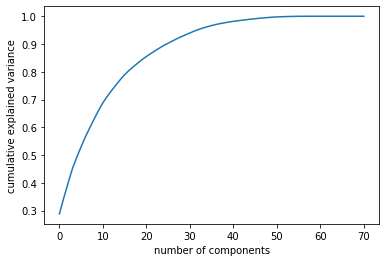

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [45]:
num_components = 50
pca = PCA(num_components, random_state=SEED)
feat_pca = pca.fit_transform(scaled_features)

In [46]:
feat_importance = pd.DataFrame(pca.components_, columns = train_data[features].columns)

In [47]:
n_pcs = pca.n_components_
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = train_data[features].columns
most_important_cols = list(set([initial_feature_names[most_important[i]] for i in range(n_pcs)]))

In [48]:

folds = 3
use_gpu = False

params = {
                'boosting_type': 'gbdt',
                'device_type': 'gpu' if use_gpu else 'cpu',
                #'gpu_use_dp': 'true',
                'n_jobs': -1,
                'learning_rate': 0.008,
                #'bagging_fraction': 0.85,
                #'bagging_freq': 10, 
                'colsample_bytree': 0.85,
                'colsample_bynode': 0.85,
                'min_data_per_leaf': 25,
                'max_bin':63,
                'num_leaves': 125,
                'lambda_l1': 0.5,
                'lambda_l2': 0.5,
                "metric": "mae",
#                 "min_delta":0.0003,
                'seed': SEED,
                'verbose':-1,
                # 'categorical_feature':[f'name:{c}' for c in categorical]
              }  
base_cv_models = train_base_models(train_data, folds, True, pca_cols=most_important_cols)

Training model for timestep 1 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[260]	training's l1: 109485	valid_1's l1: 156356


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 88194.9	valid_1's l1: 118791
Early stopping, best iteration is:
[624]	training's l1: 81848.2	valid_1's l1: 117554


Training fold 3
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 86207.7	valid_1's l1: 129004
Early stopping, best iteration is:
[610]	training's l1: 80619.7	valid_1's l1: 127755


/tmp/ipykernel_99107/1401232404.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.loc[:, f'preds_{step}'] = oof[:, step]


Elapsed 0.12 mins
--------------------------------------------------


Training model for timestep 2 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[359]	training's l1: 93735.6	valid_1's l1: 158411


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 85316.7	valid_1's l1: 134044
Early stopping, best iteration is:
[640]	training's l1: 78752.6	valid_1's l1: 133187


Training fold 3
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 91576.6	valid_1's l1: 126048
Early stopping, best iteration is:
[557]	training's l1: 88437.3	valid_1's l1: 125741


/tmp/ipykernel_99107/1401232404.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.loc[:, f'preds_{step}'] = oof[:, step]


Elapsed 0.25 mins
--------------------------------------------------


Training model for timestep 3 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[400]	training's l1: 88729.9	valid_1's l1: 151926


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 85183.9	valid_1's l1: 116166
Early stopping, best iteration is:
[567]	training's l1: 81603	valid_1's l1: 115779


Training fold 3
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 81962.2	valid_1's l1: 130159
Early stopping, best iteration is:
[605]	training's l1: 76928.3	valid_1's l1: 129473


/tmp/ipykernel_99107/1401232404.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.loc[:, f'preds_{step}'] = oof[:, step]


Elapsed 0.37 mins
--------------------------------------------------


Training model for timestep 4 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 82808.2	valid_1's l1: 132853
Early stopping, best iteration is:
[532]	training's l1: 80980.2	valid_1's l1: 132567


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 78563.6	valid_1's l1: 124013
Early stopping, best iteration is:
[755]	training's l1: 68383.4	valid_1's l1: 122304


Training fold 3
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 77762.9	valid_1's l1: 127504
Early stopping, best iteration is:
[631]	training's l1: 71684.2	valid_1's l1: 126725
Elapsed 0.52 mins
--------------------------------------------------




/tmp/ipykernel_99107/1401232404.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.loc[:, f'preds_{step}'] = oof[:, step]


In [53]:
base_val_mae = test_base_model(train_data, folds, base_cv_models, True, pca_cols=most_important_cols)

Making timestep 1 predictions
Val MAE: 134060.44157147006


Making timestep 2 predictions
Val MAE: 139256.81579004583


Making timestep 3 predictions
Val MAE: 132543.33857250676


Making timestep 4 predictions
Val MAE: 127240.2985151079


Average Val MAE: 133275.22361228193


In [1544]:

folds = 3
use_gpu = False

params = dict(#loss_function='mae',
              n_estimators=10000,
              learning_rate=0.02, 
              eval_metric = 'mae',
              early_stopping_rounds=10,
              seed=SEED)

base_cv_models = train_base_models(train_data, folds, True, False, 'xgb', most_important_cols)

Training model for timestep 1 forecasting


Training fold 1
[0]	validation_0-mae:226722.86759	validation_1-mae:242434.02150
[112]	validation_0-mae:104786.37643	validation_1-mae:134325.75859


Training fold 2
[0]	validation_0-mae:233102.56838	validation_1-mae:229895.56934
[148]	validation_0-mae:106176.92840	validation_1-mae:121530.43415


Training fold 3
[0]	validation_0-mae:236219.94678	validation_1-mae:223690.55343
[130]	validation_0-mae:105328.62601	validation_1-mae:130622.74936


/tmp/ipykernel_21615/1401232404.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.loc[:, f'preds_{step}'] = oof[:, step]


Elapsed 0.11 mins
--------------------------------------------------


Training model for timestep 2 forecasting


Training fold 1
[0]	validation_0-mae:212353.44700	validation_1-mae:231853.38559


KeyboardInterrupt: 

In [1536]:
base_val_mae = test_base_model(train_data, folds, base_cv_models, True, most_important_cols)

Making timestep 1 predictions
Val MAE: 128682.16701197444


Making timestep 2 predictions
Val MAE: 128531.45901417965


Making timestep 3 predictions
Val MAE: 124059.75111604239


Making timestep 4 predictions
Val MAE: 119843.99243099688


Average Val MAE: 125279.34239329834


In [54]:
target_cols = [f'target_{i}' for i in range(N_STEPS)]
pred_cols = [f'preds_{i}' for i in range(N_STEPS)]

In [63]:
target_arr = train_data[target_cols].values.reshape(-1,1)
pred_arr = train_data[pred_cols].values.reshape(-1,1)

In [64]:
train_cols = [c for c in train_data if c not in target_cols+pred_cols]
train_expanded = train_data.loc[train_data.index.repeat(N_STEPS)][train_cols].reset_index(drop=True)

train_expanded['target'] = target_arr
train_expanded['preds'] = pred_arr
train_expanded['time_step'] = train_expanded.groupby(['sku_name','month','year']).cumcount()

In [65]:
meta_dates = sorted([(m+N_STEPS, y) if m+N_STEPS<=12 else (m+N_STEPS-12, y+1)for y,m in train_expanded[['year','month']].apply(tuple, axis=1)], key=lambda d: (d[1], d[0]))


In [66]:
train_expanded[['month','year']] = pd.DataFrame(meta_dates, columns=['month','year'])

In [59]:

# train_expanded = lag_shift(train_expanded, ['sku_name'], ['preds'], [1,2])

In [60]:

folds = 3#len(dates)
use_gpu = False

params = dict(#loss_function='mae',
              n_estimators=10000,
              learning_rate=0.02, 
              eval_metric = 'mae',
              early_stopping_rounds=10,
              seed=SEED)

meta_cv_models,oof = train_meta_model(train_expanded, folds, False, 'xgb')



Training fold 1
[0]	validation_0-mae:207439.50222	validation_1-mae:225619.61104
[114]	validation_0-mae:115962.37204	validation_1-mae:136921.93732


Training fold 2
[0]	validation_0-mae:211662.18976	validation_1-mae:217274.95102
[99]	validation_0-mae:121921.91840	validation_1-mae:121650.28566


Training fold 3
[0]	validation_0-mae:221399.44430	validation_1-mae:197442.53034
[86]	validation_0-mae:125309.24316	validation_1-mae:117063.89118


In [61]:
meta_val_mae = test_meta_model(train_expanded, folds, meta_cv_models)



Making fold 1 predictions
Val MAE: 120391.9284811345




Making fold 2 predictions
Val MAE: 120919.41801687339




Making fold 3 predictions
Val MAE: 128885.90796192079


Average Val MAE: 122647.2957352658


In [67]:

folds = 3#len(dates)
use_gpu = False

params = dict(loss_function='MAE',
              n_estimators=10000,
              learning_rate=0.02, 
              eval_metric = 'MAE',
              random_seed=SEED)

meta_cv_models,oof = train_meta_model(train_expanded, folds )



Training fold 1
0:	learn: 204106.8859721	test: 204106.8859721	test1: 222569.4035885	best: 222569.4035885 (0)	total: 83.5ms	remaining: 13m 54s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 130393.2494
bestIteration = 305

Shrink model to first 306 iterations.


Training fold 2
0:	learn: 208491.5873282	test: 208491.5873282	test1: 213326.0472824	best: 213326.0472824 (0)	total: 13.8ms	remaining: 2m 18s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 117465.2392
bestIteration = 319

Shrink model to first 320 iterations.


Training fold 3
0:	learn: 217962.2814764	test: 217962.2814764	test1: 194666.1515577	best: 194666.1515577 (0)	total: 8.44ms	remaining: 1m 24s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 111945.0652
bestIteration = 381

Shrink model to first 382 iterations.


In [68]:
meta_val_mae = test_meta_model(train_expanded, folds, meta_cv_models)



Making fold 1 predictions
Val MAE: 115818.86125419111




Making fold 2 predictions
Val MAE: 116957.95936149756




Making fold 3 predictions
Val MAE: 123886.23781130605


Average Val MAE: 118120.47992029472


In [904]:

folds = 3#len(dates)
use_gpu = False

params = dict(loss_function='MAE',
              n_estimators=10000,
              learning_rate=0.02, 
              eval_metric = 'MAE',
              random_seed=SEED)

meta_cv_models,oof = train_meta_model(train_expanded, folds, pca_cols=None)



Training fold 1
0:	learn: 204120.2809092	test: 204120.2809092	test1: 222659.4453958	best: 222659.4453958 (0)	total: 9.35ms	remaining: 1m 33s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 130084.6208
bestIteration = 302

Shrink model to first 303 iterations.


Training fold 2
0:	learn: 208470.5061168	test: 208470.5061168	test1: 213346.7135947	best: 213346.7135947 (0)	total: 8.09ms	remaining: 1m 20s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 117428.4619
bestIteration = 342

Shrink model to first 343 iterations.


Training fold 3
0:	learn: 217770.1616576	test: 217770.1616576	test1: 194473.5281576	best: 194473.5281576 (0)	total: 9.32ms	remaining: 1m 33s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 111736.6526
bestIteration = 363

Shrink model to first 364 iterations.


In [905]:
meta_val_mae = test_meta_model(train_expanded, folds, meta_cv_models)



Making fold 1 predictions
Val MAE: 115920.96517843423




Making fold 2 predictions
Val MAE: 116642.79079995645




Making fold 3 predictions
Val MAE: 122857.3910793358


Average Val MAE: 117835.52805903673


In [188]:

# folds = 3#len(dates)
# use_gpu = False

# params = dict(loss_function='MAE',
#               n_estimators=10000,
#               learning_rate=0.002, 
#               eval_metric = 'MAE',
#               random_seed=SEED)

# cat_cv_models = train_cv_models(train_data, folds, True, False, 'cat', most_important_cols)

In [187]:
# val_mae = test_model(train_data, folds, cat_cv_models, True, most_important_cols)

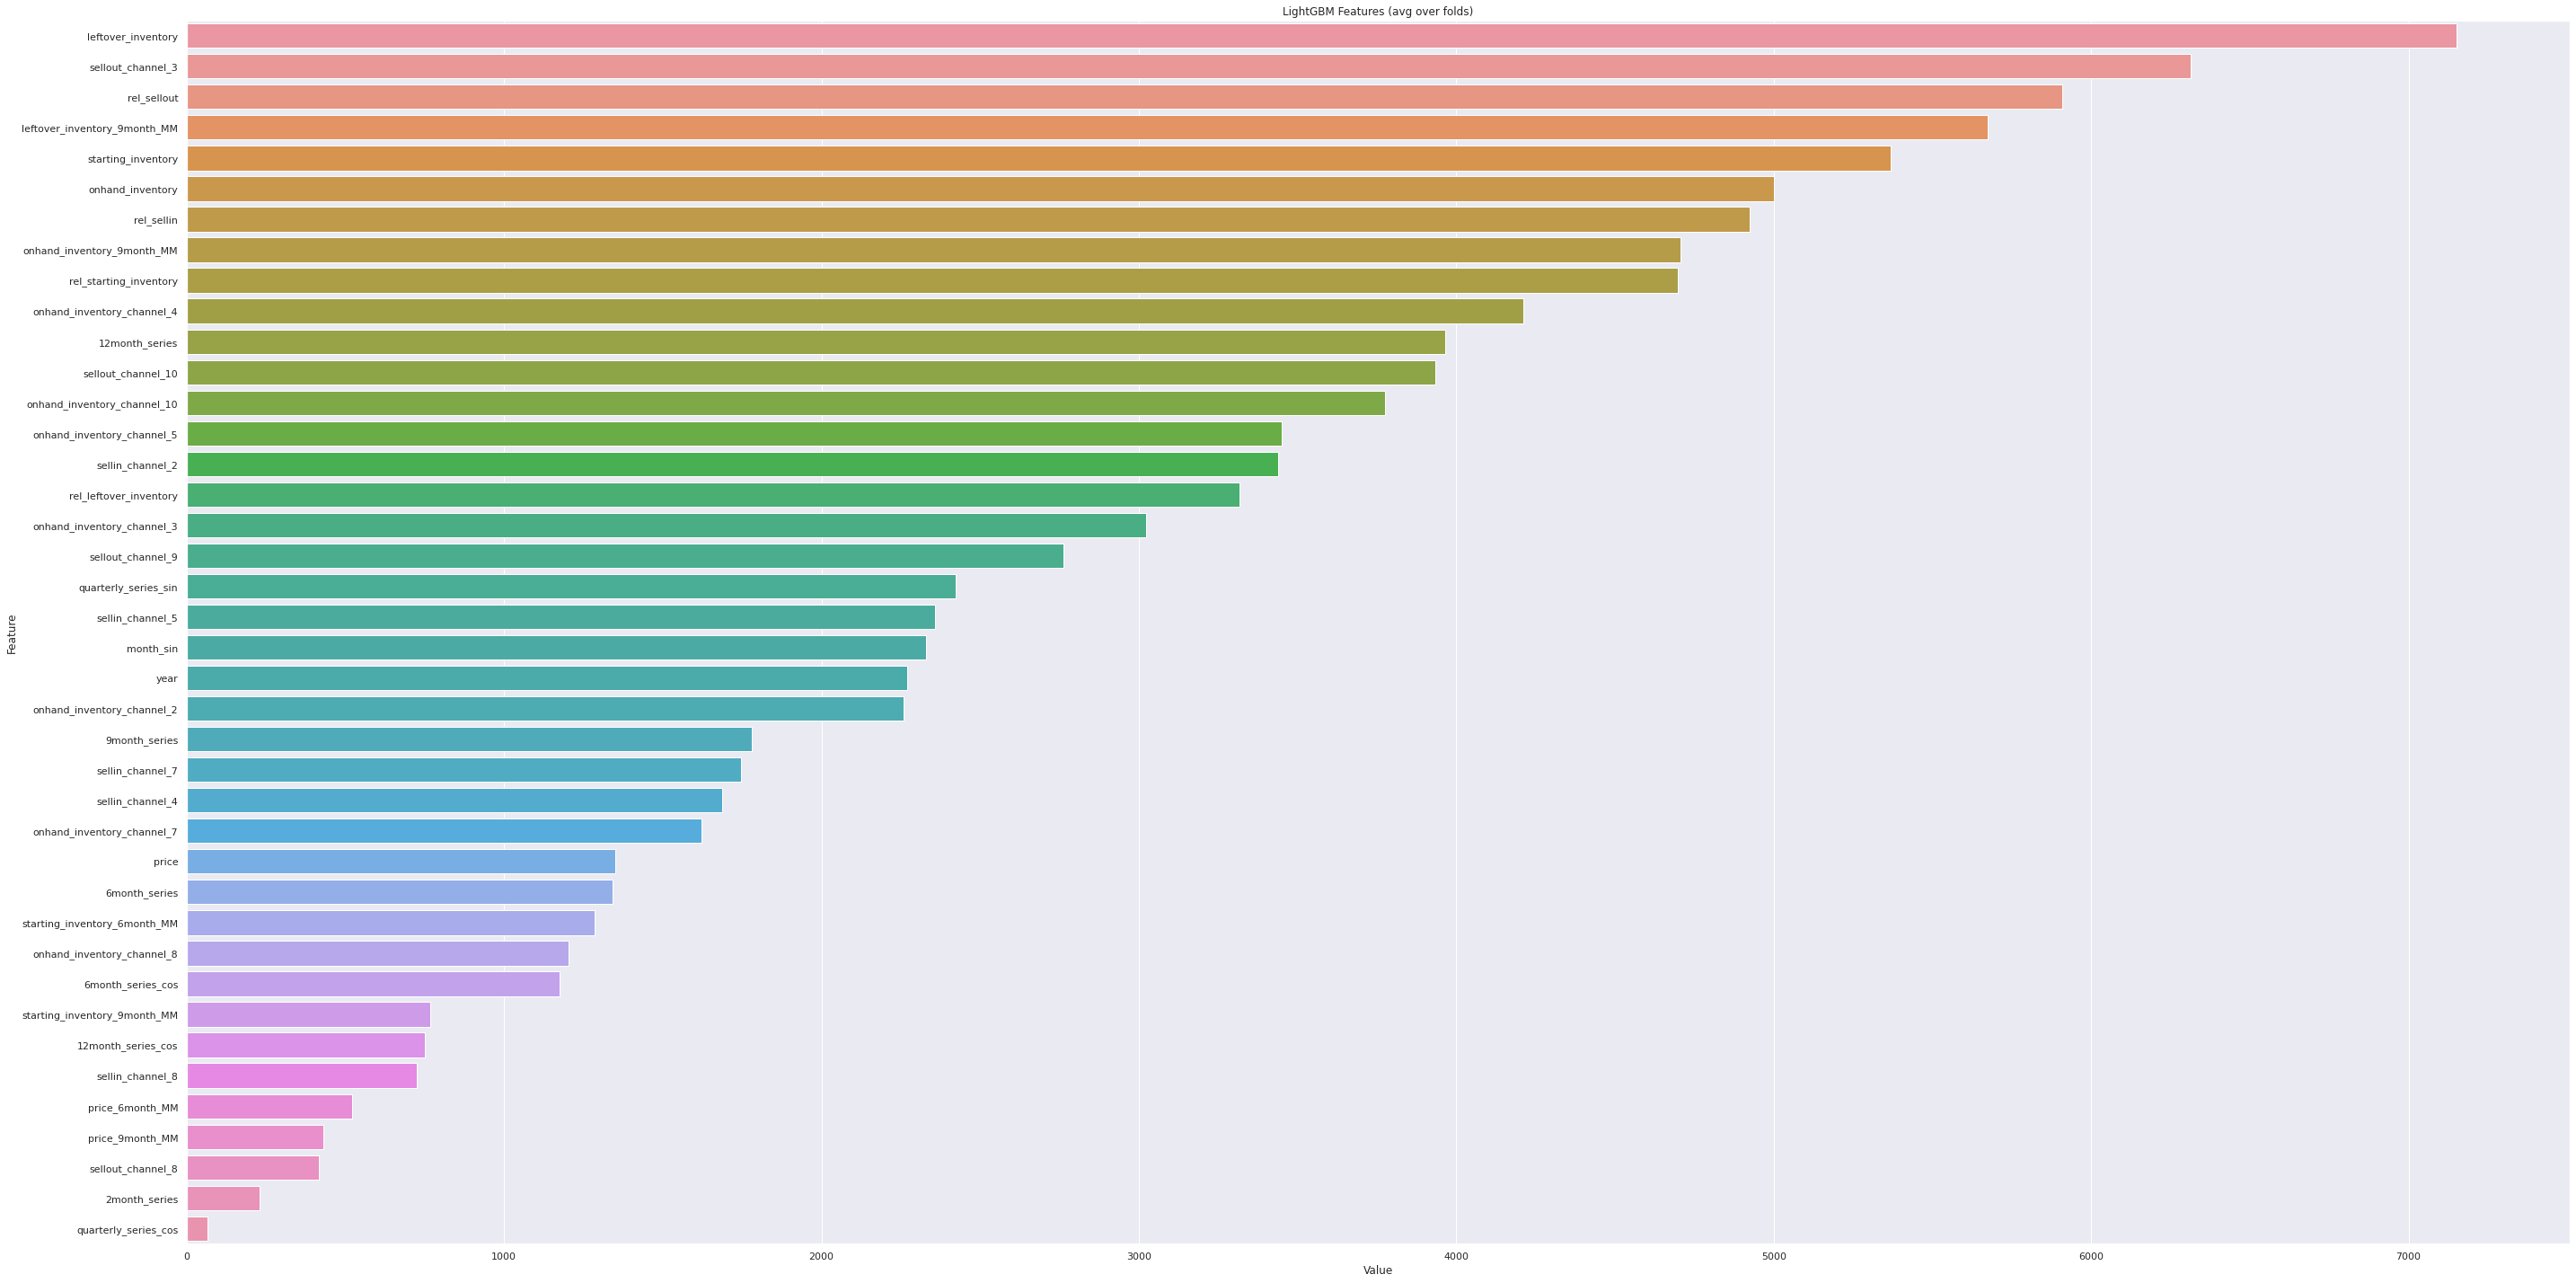

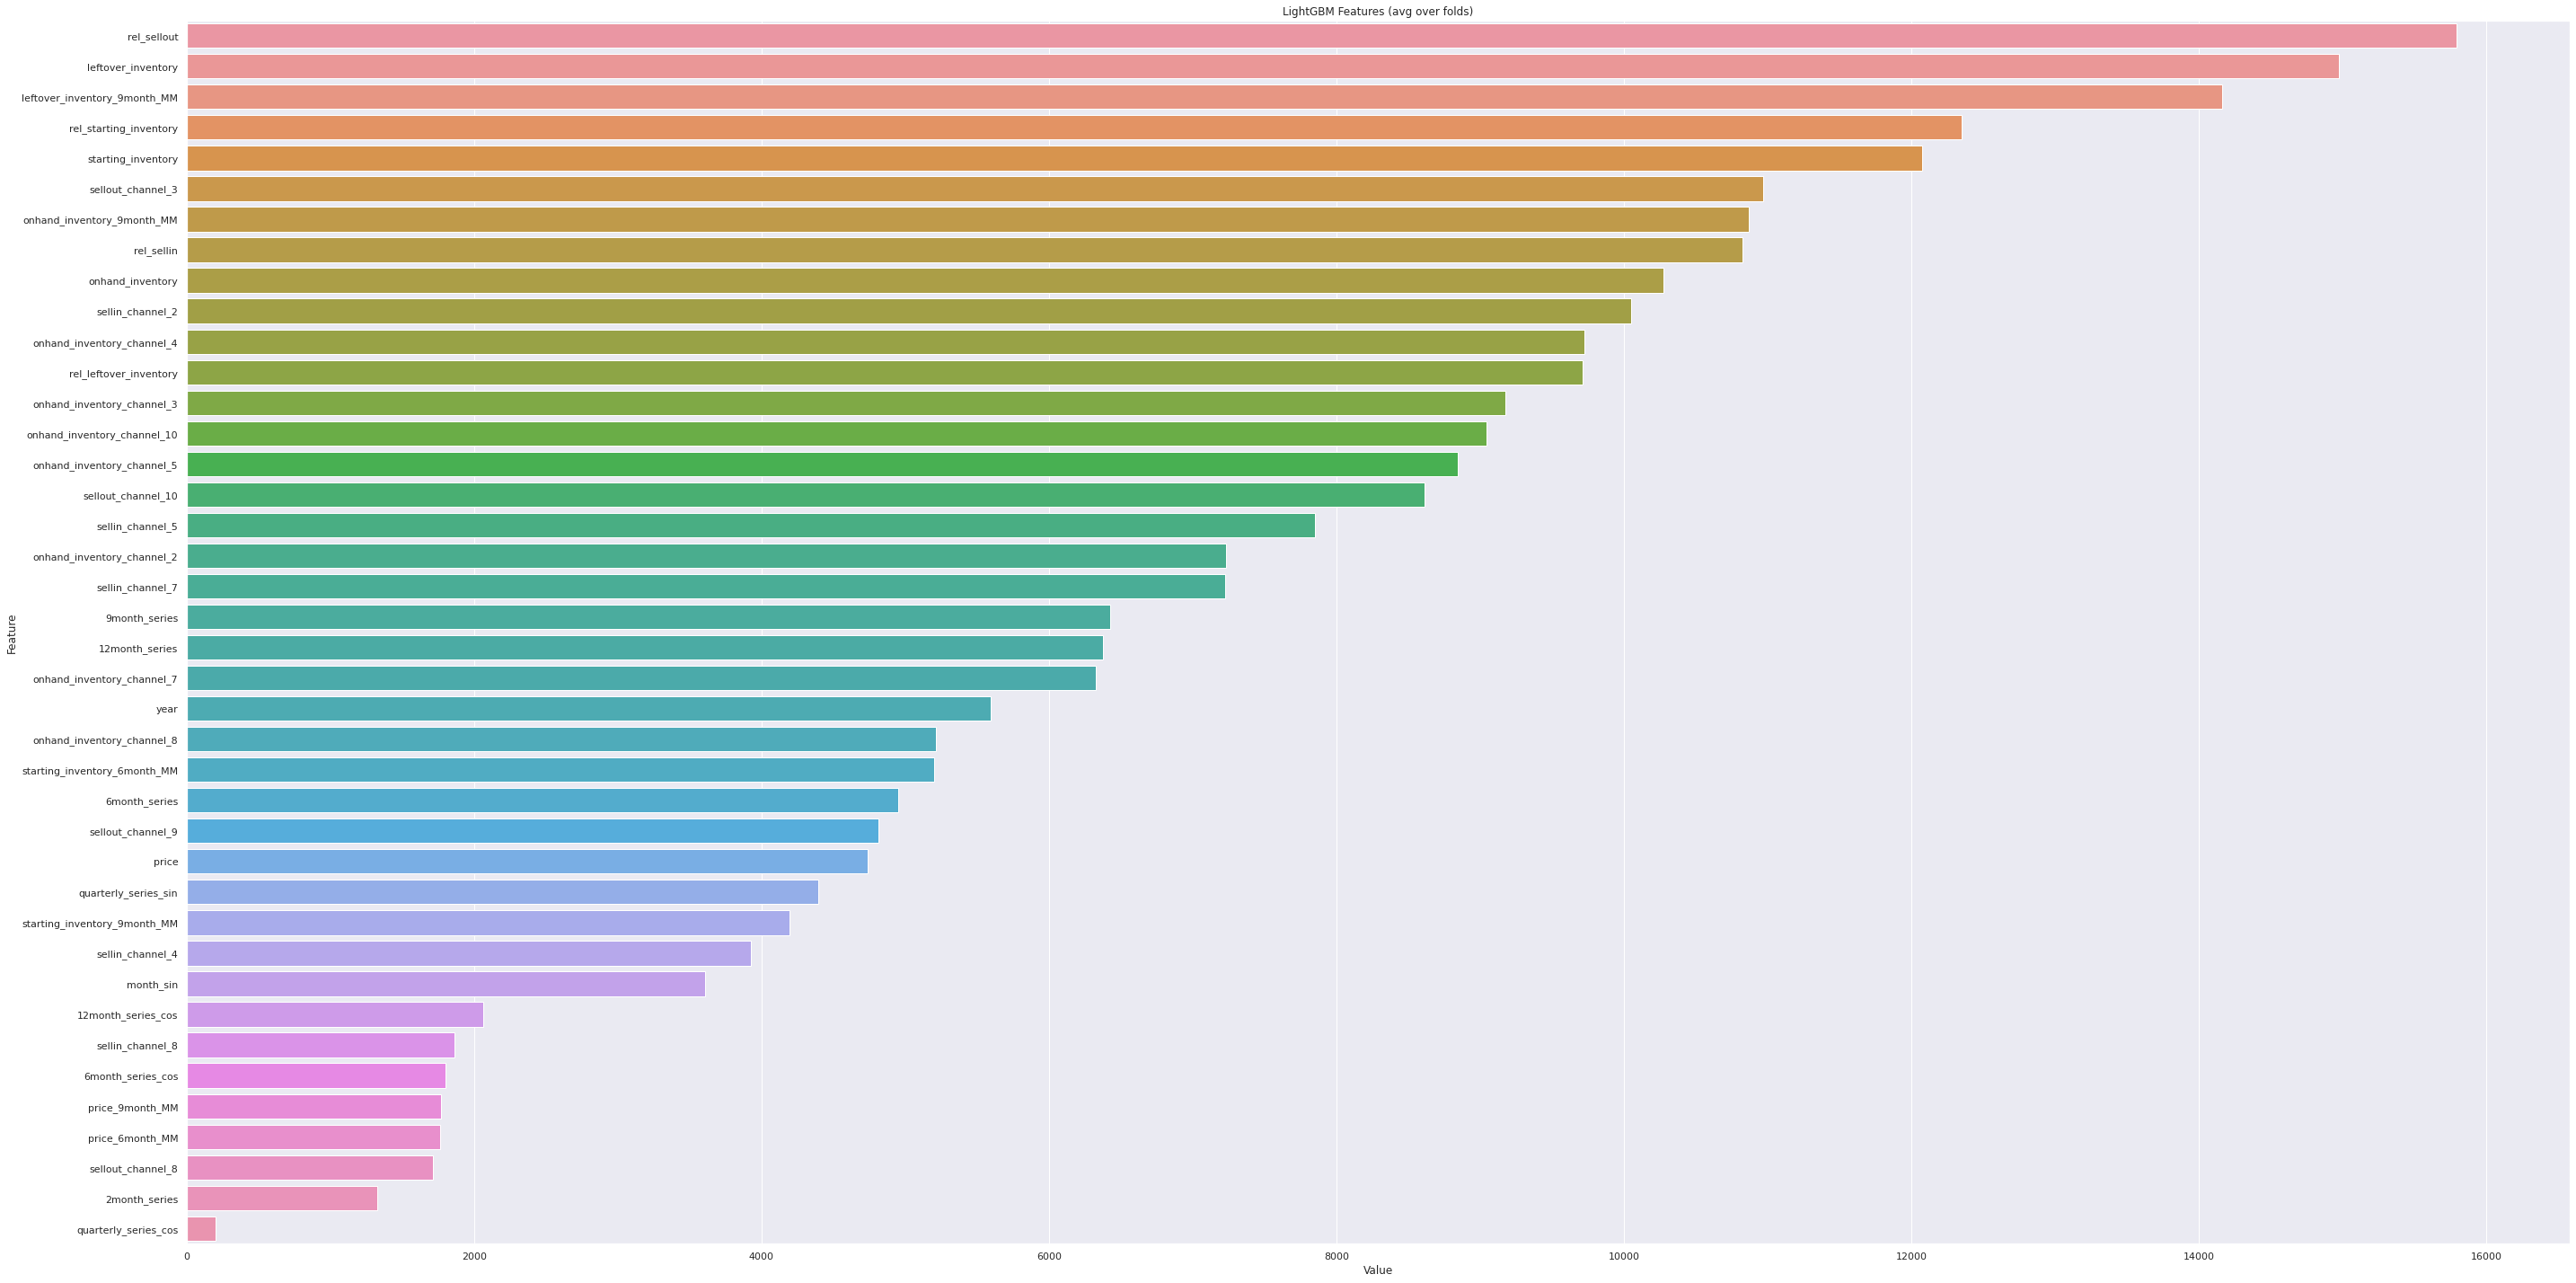

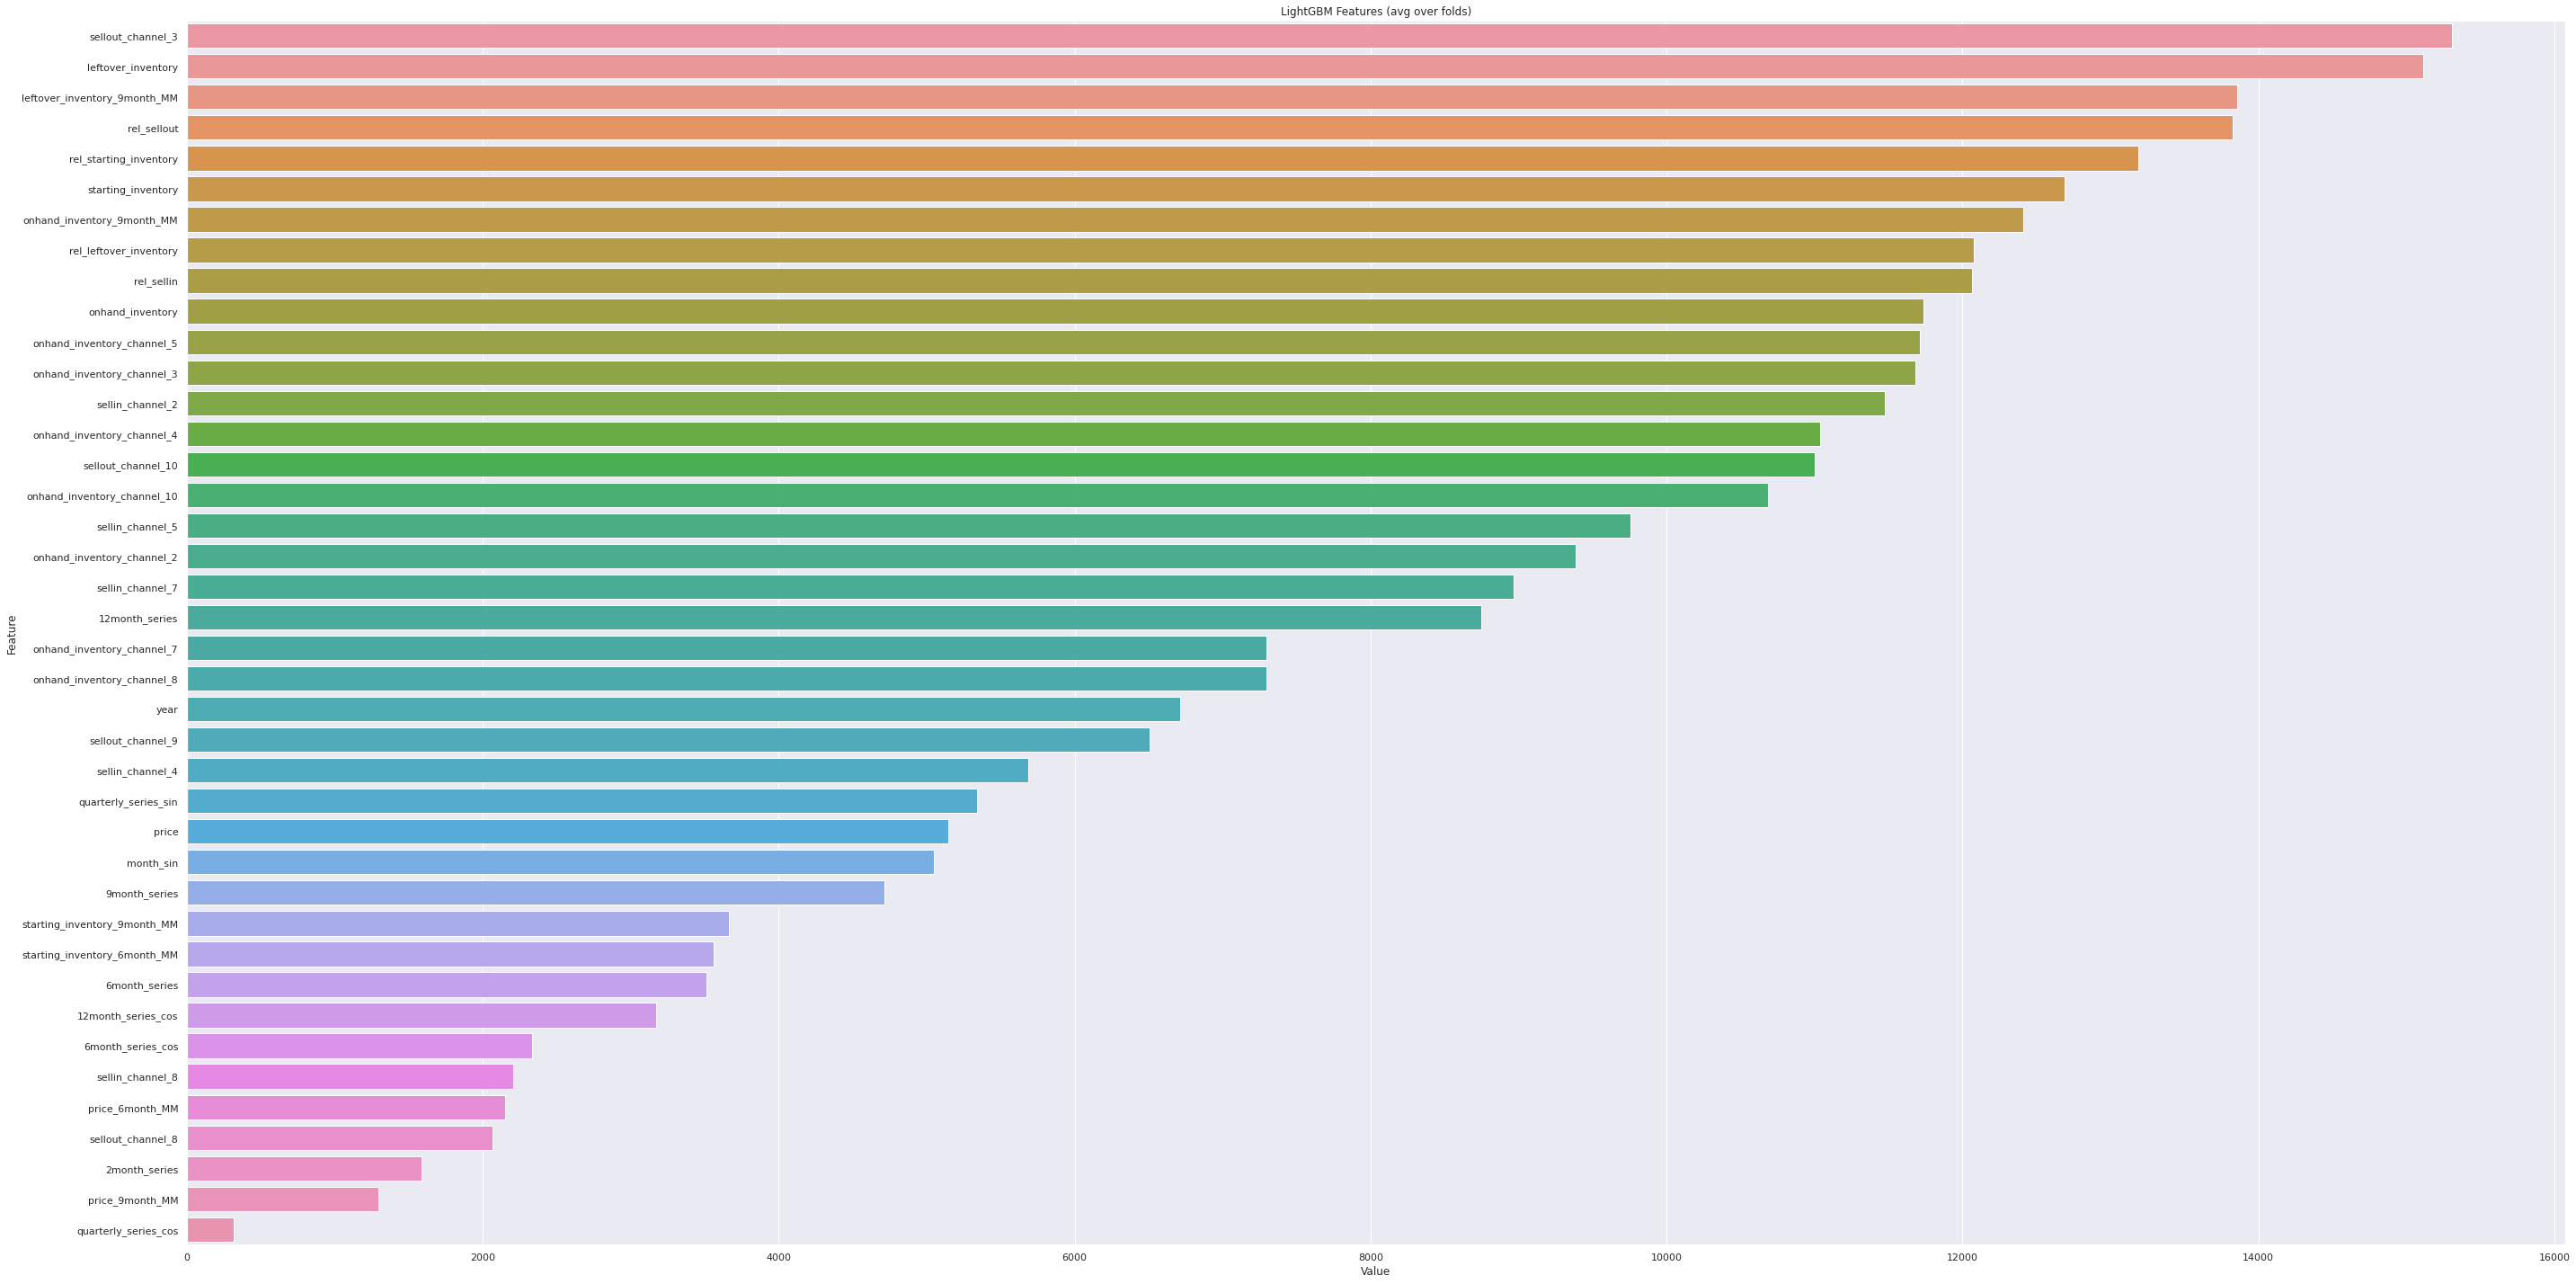

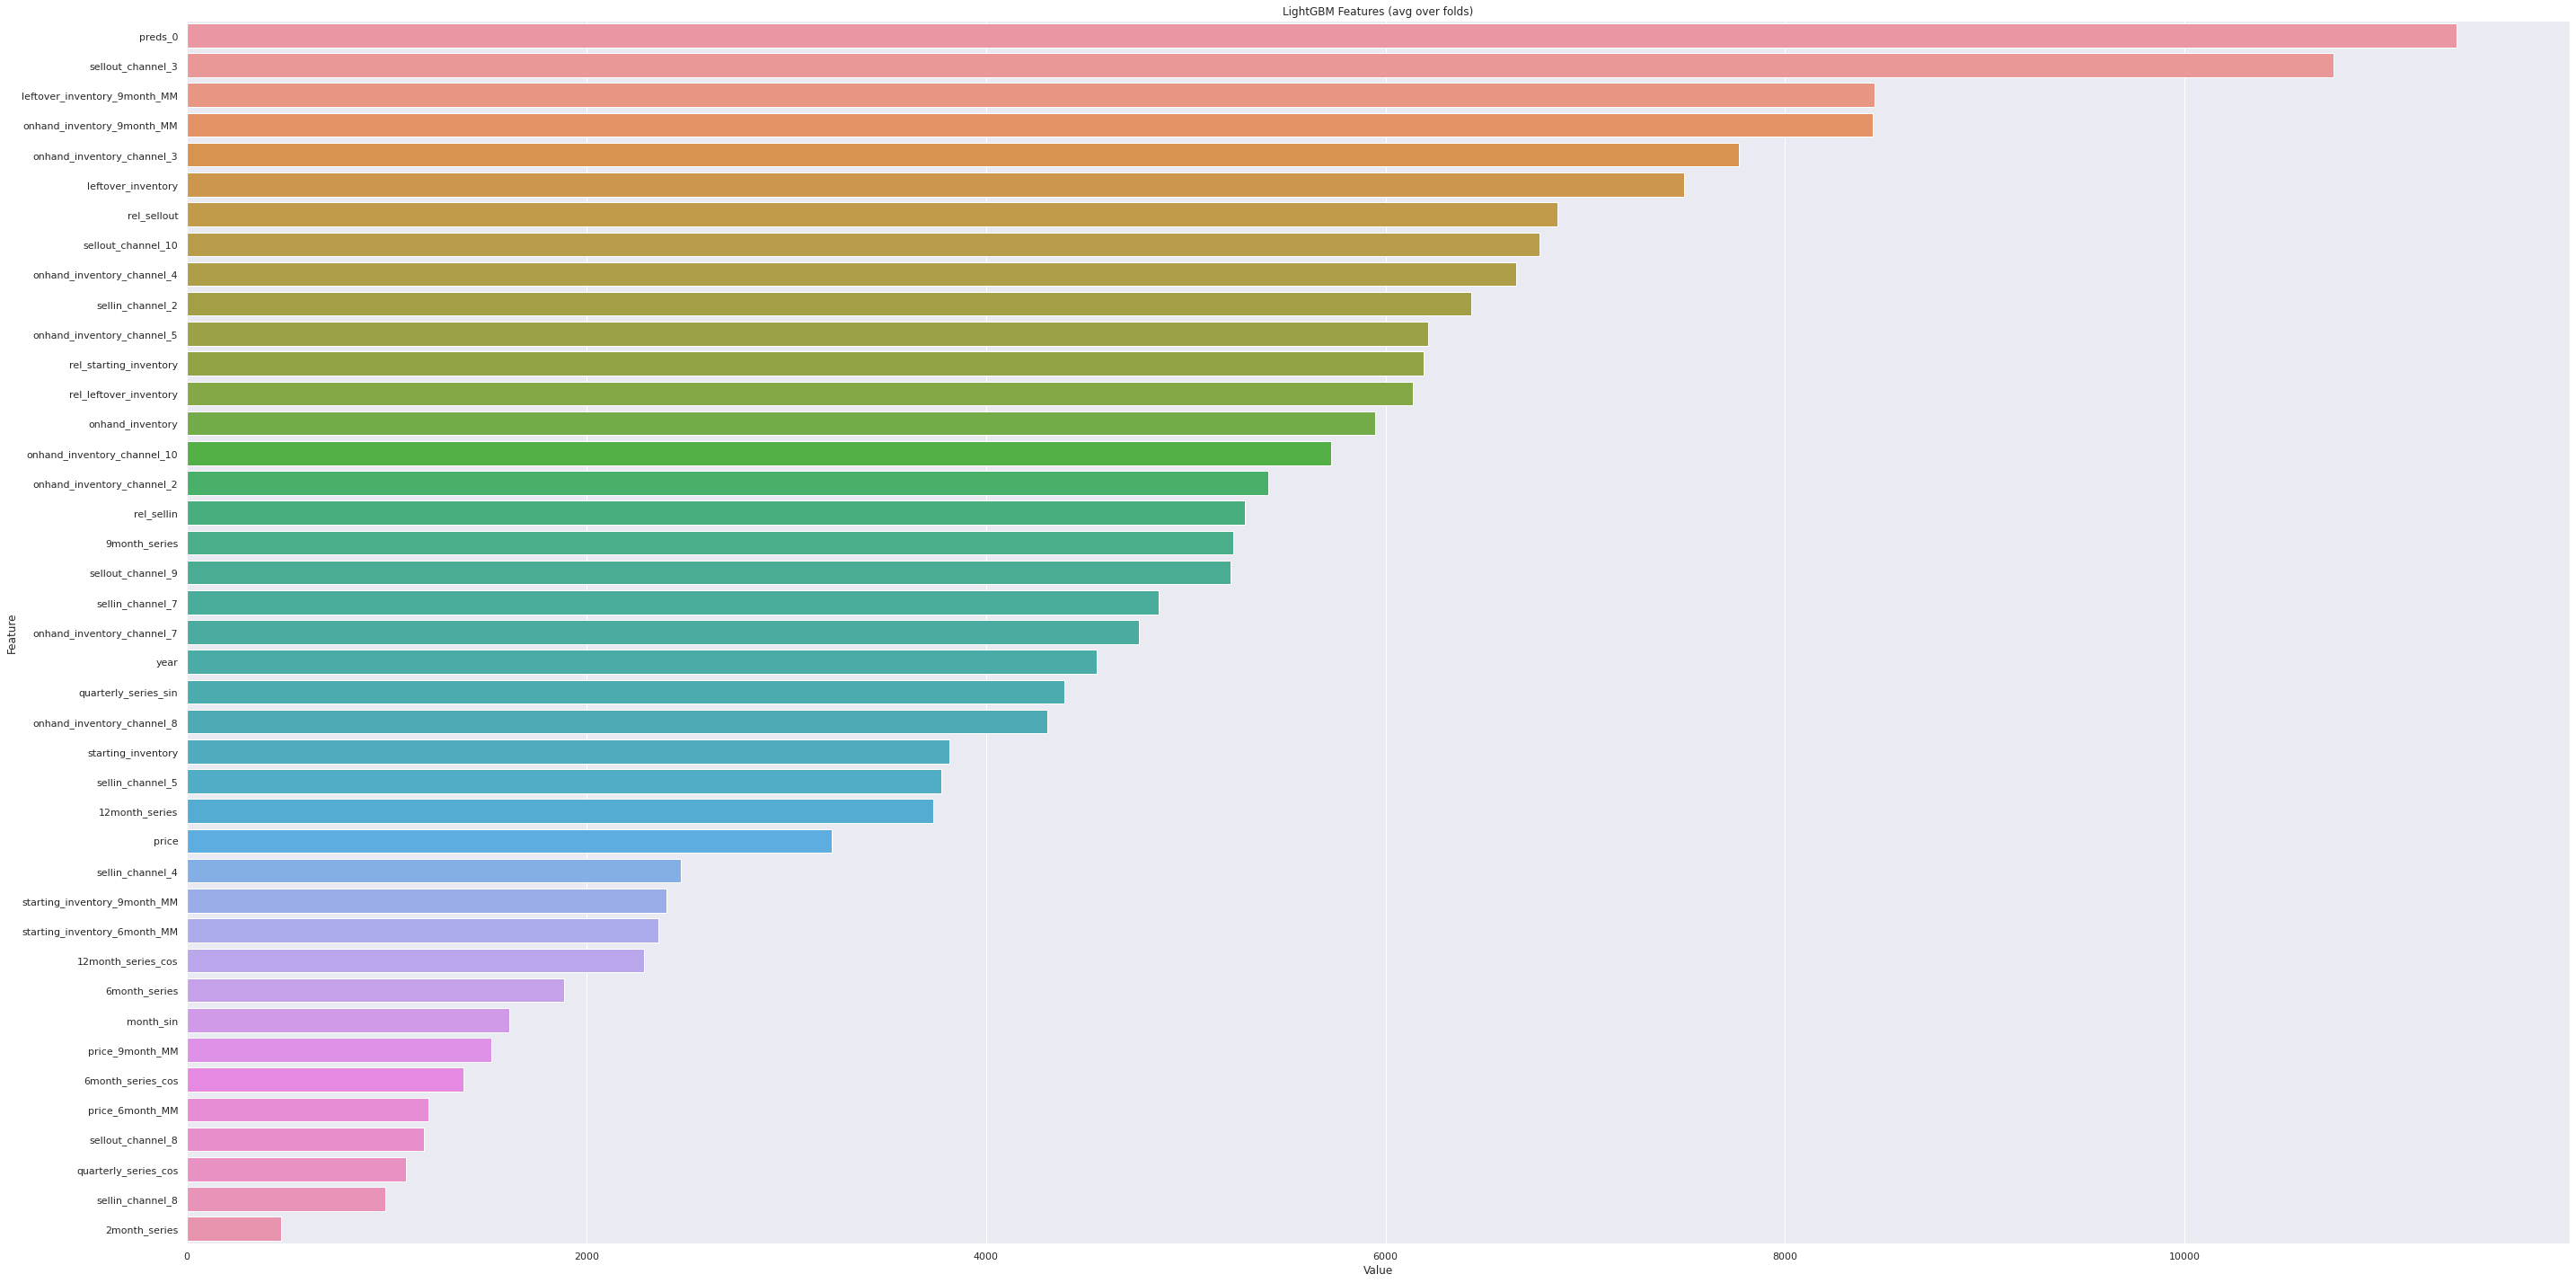

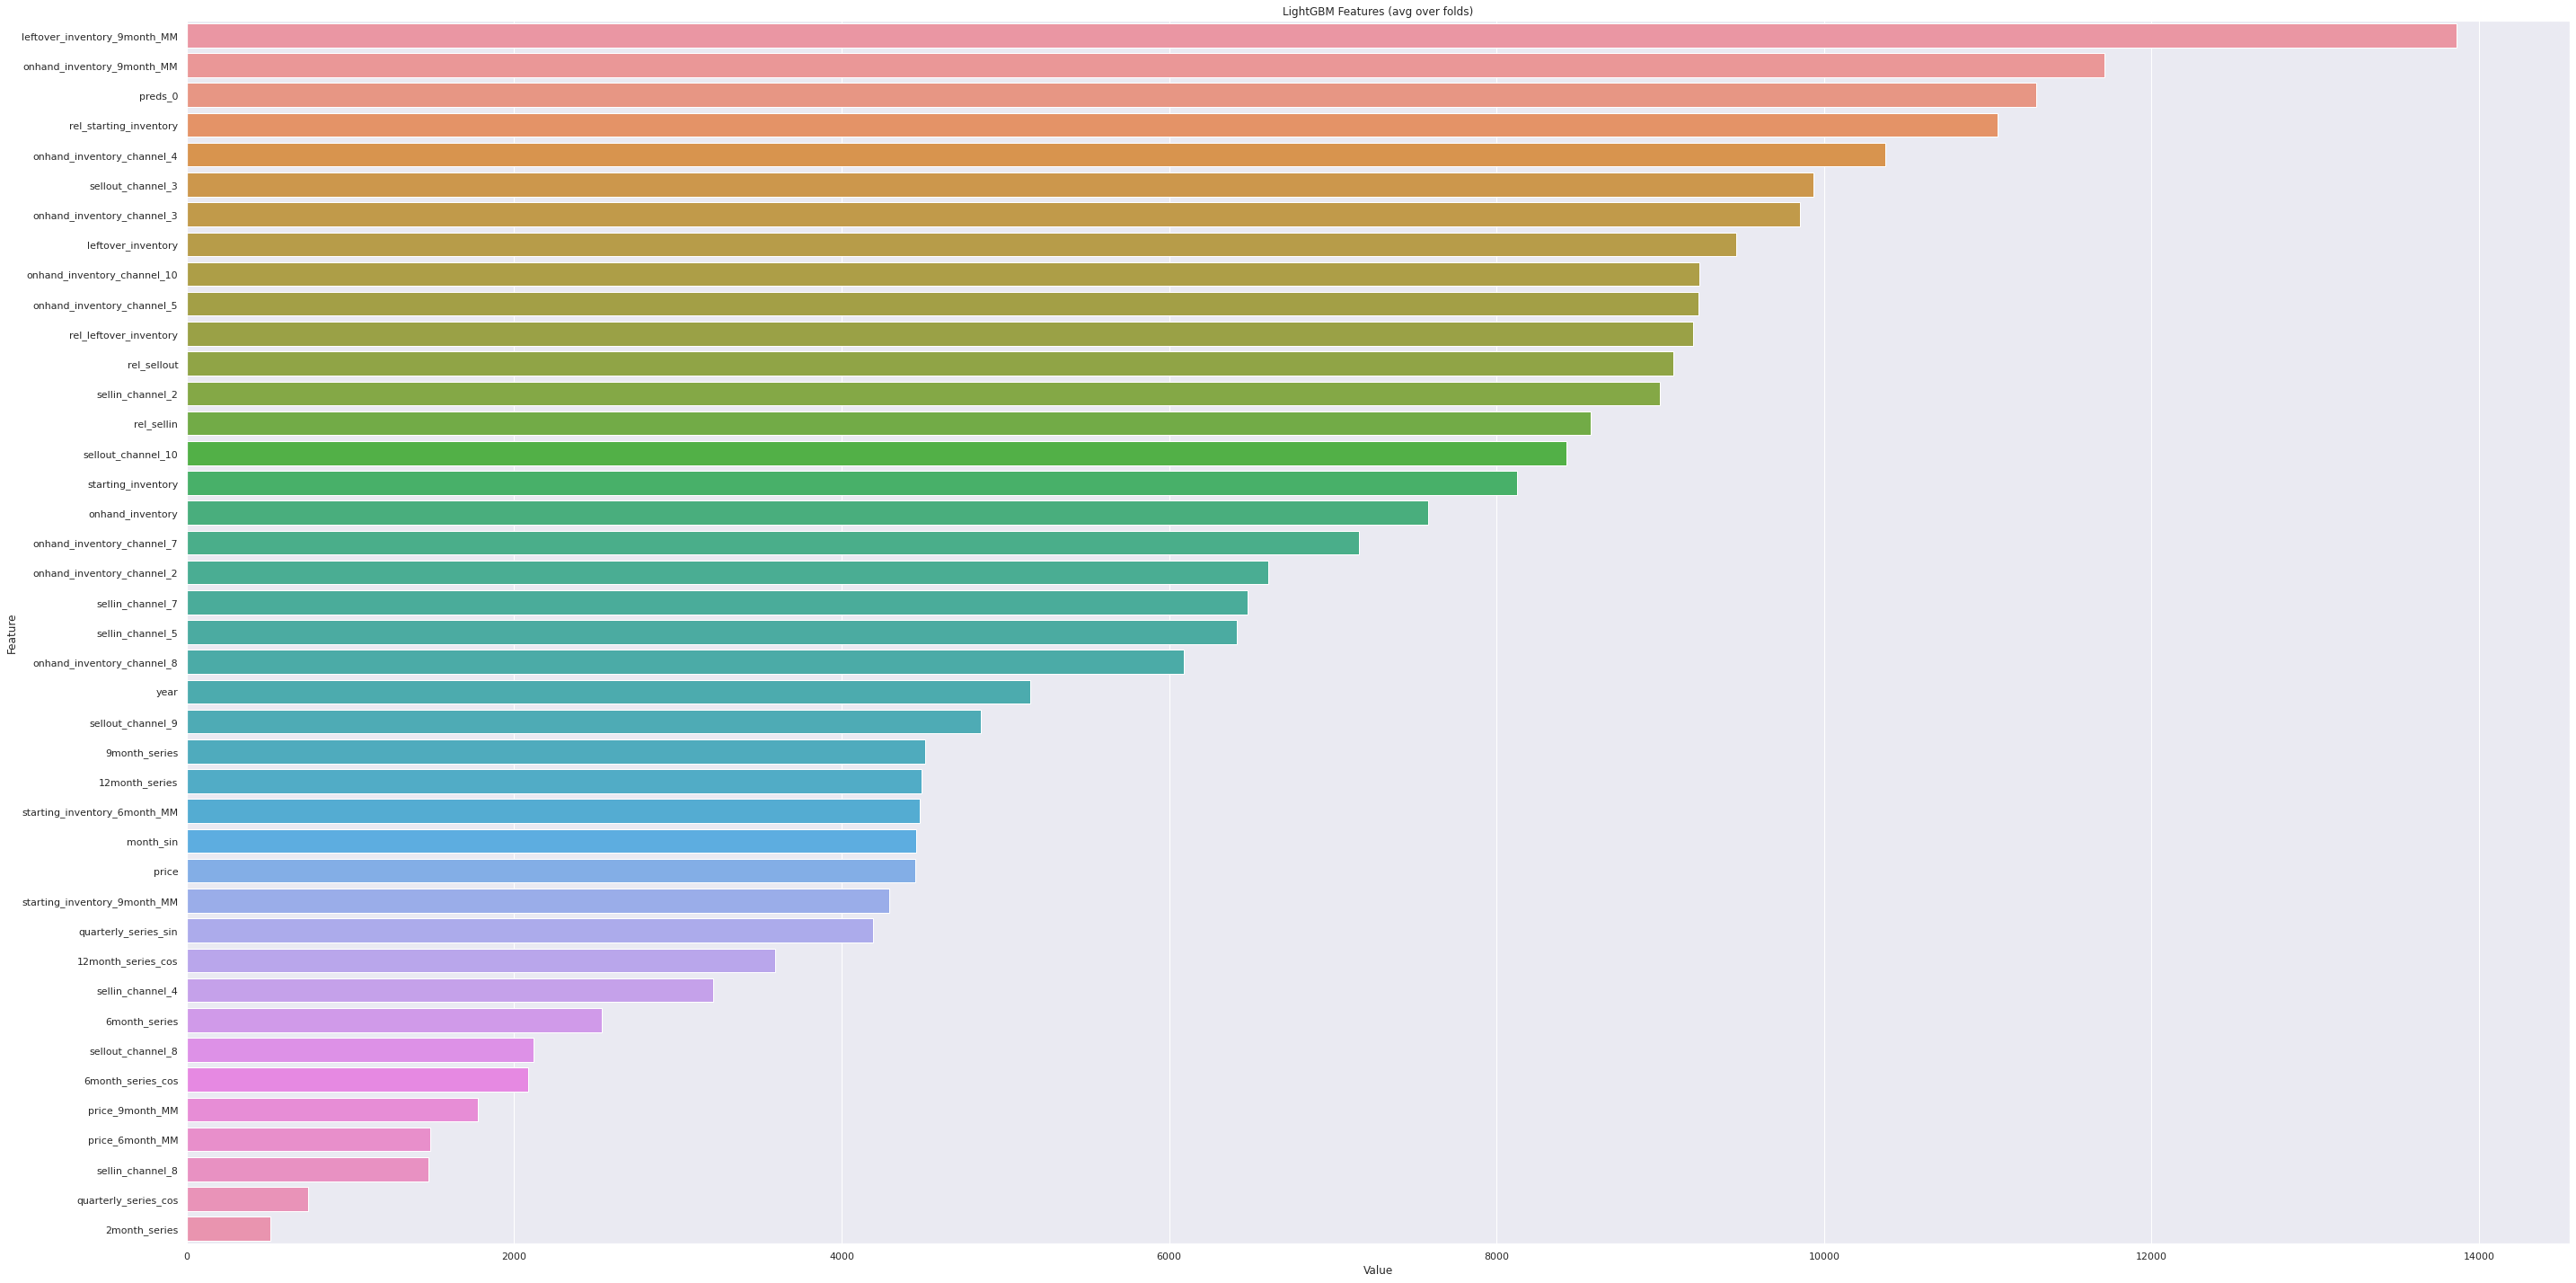

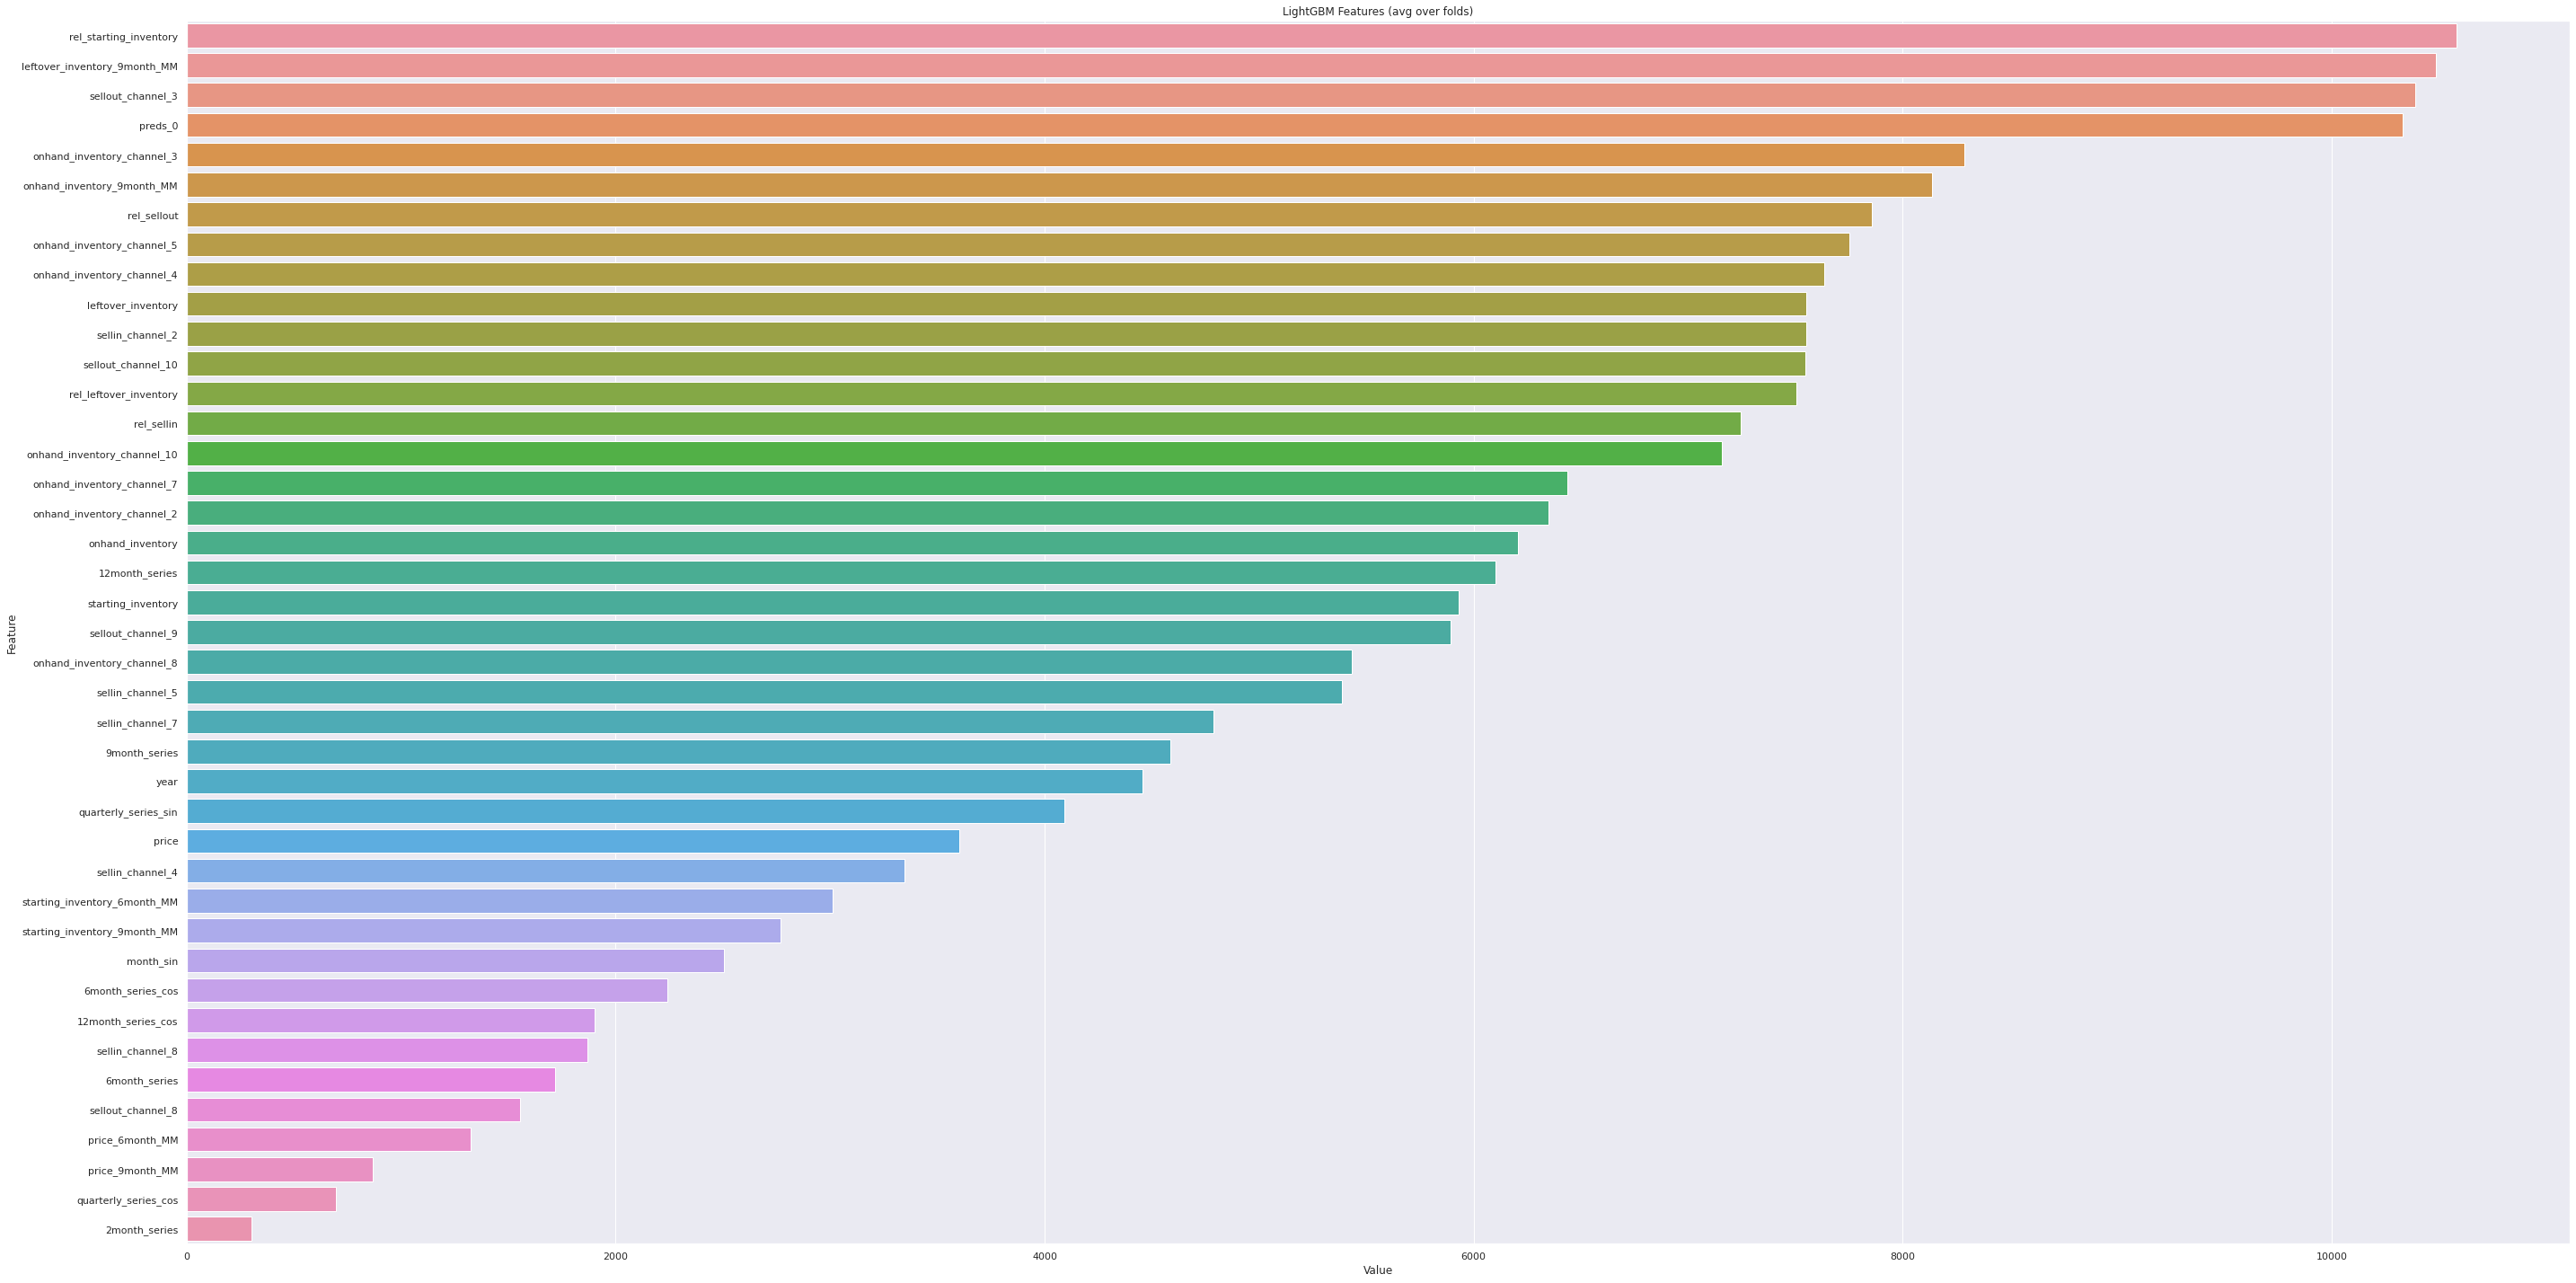

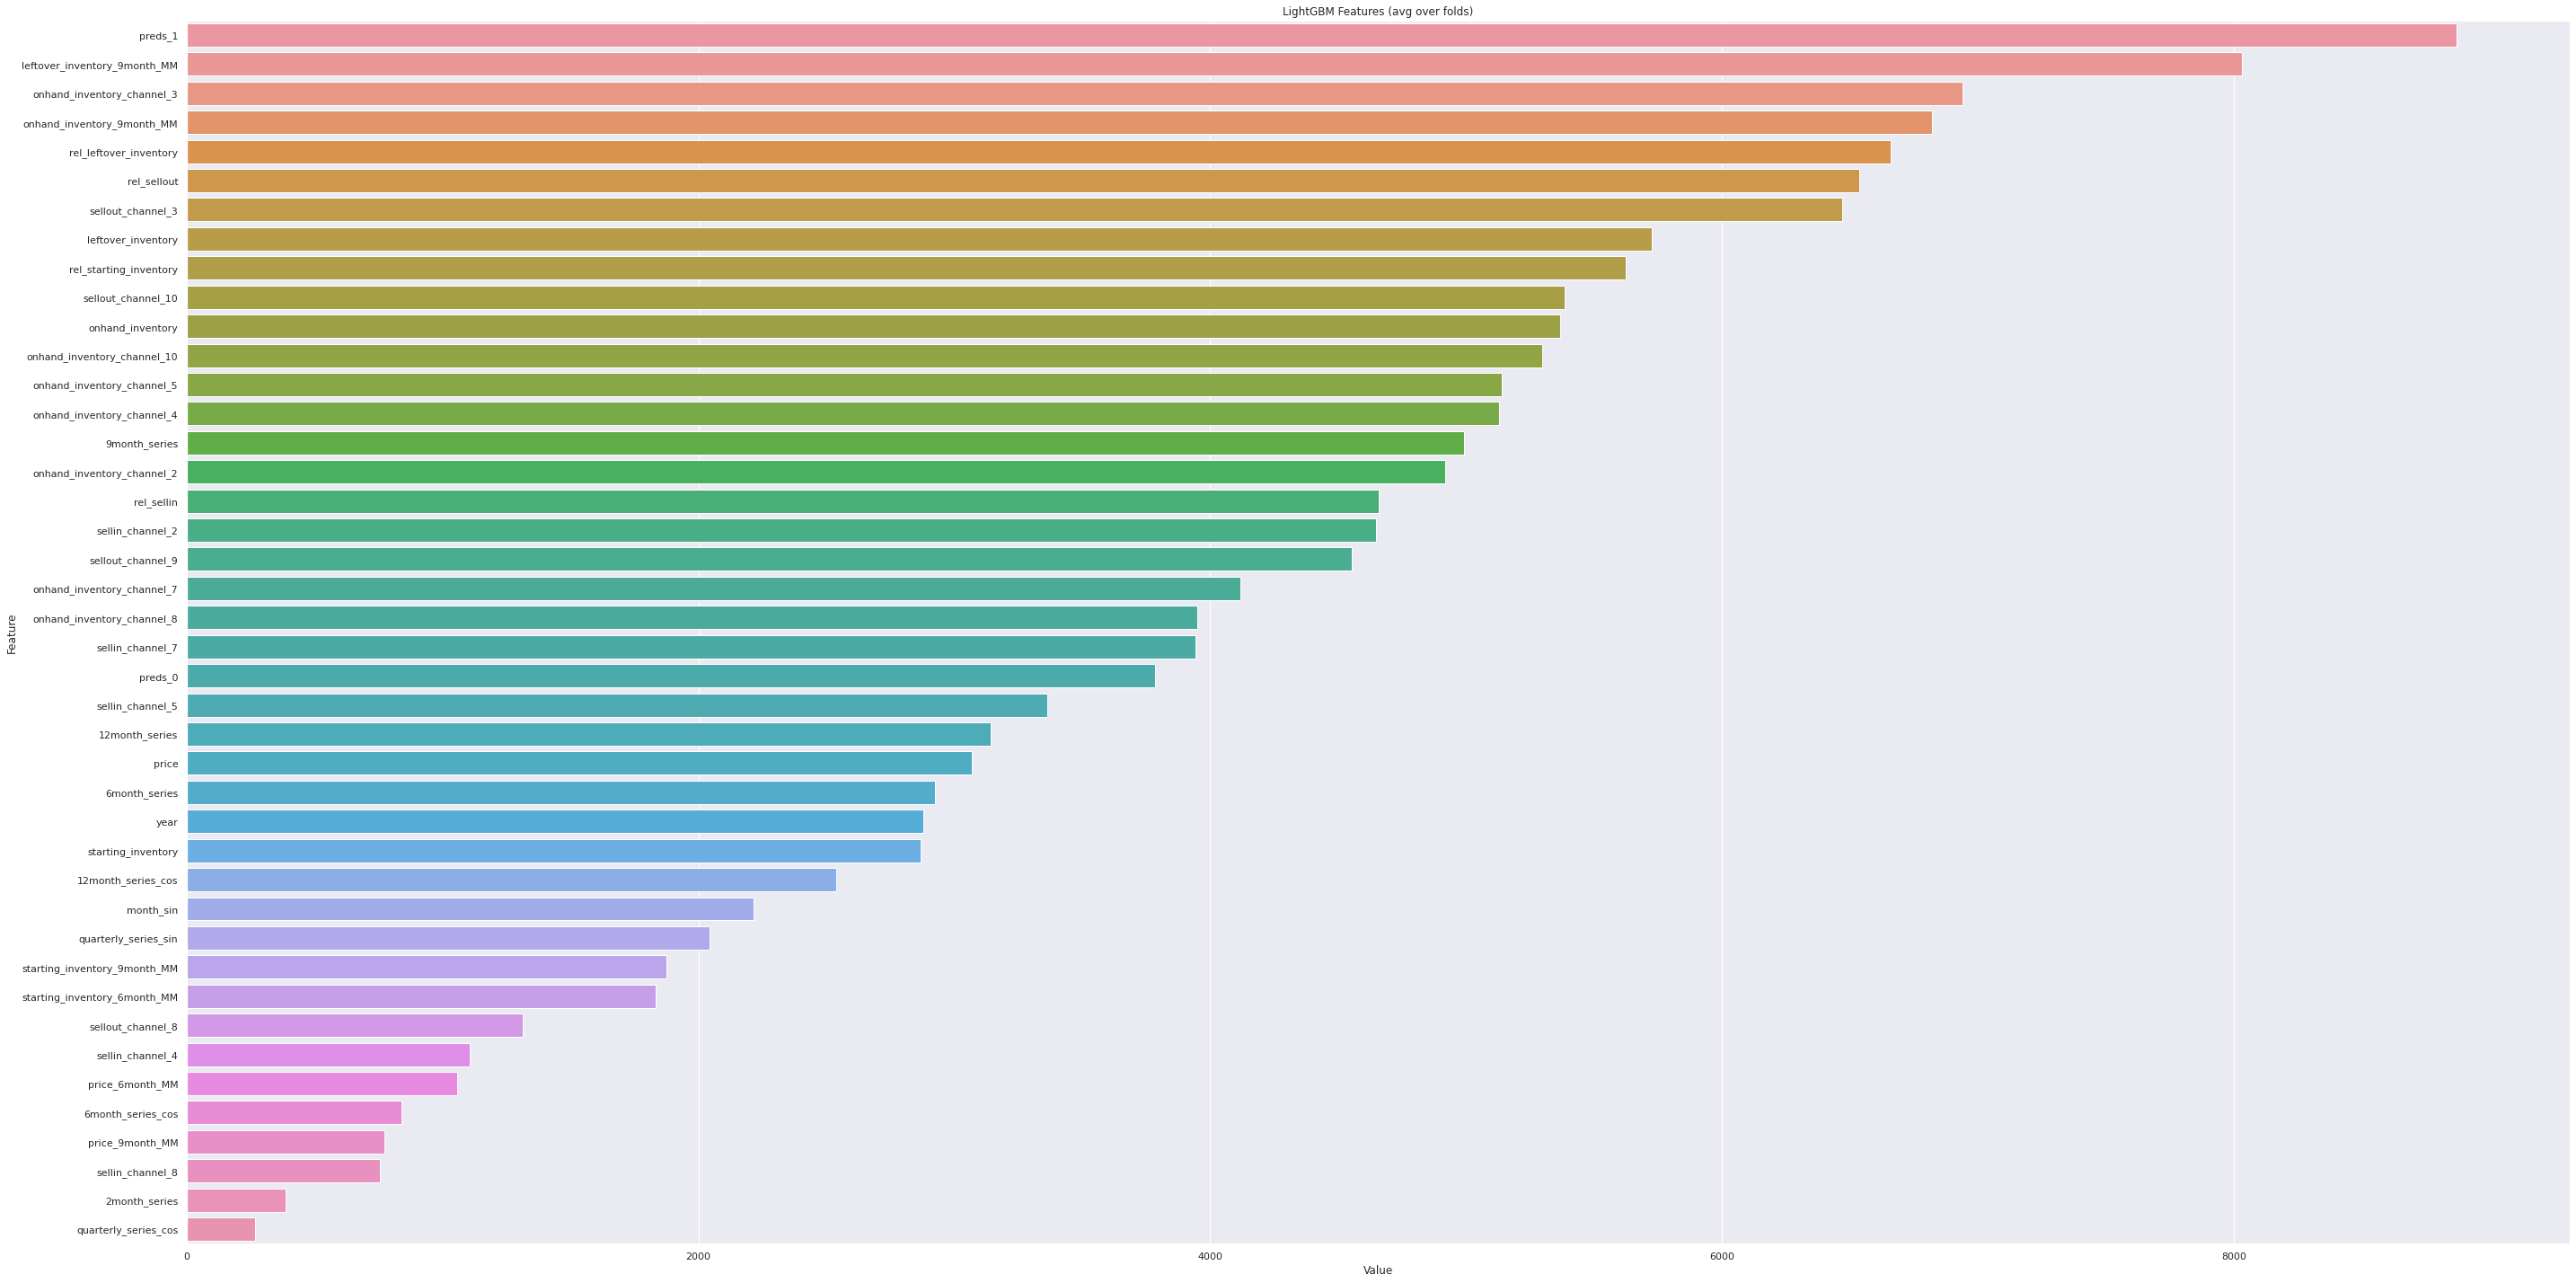

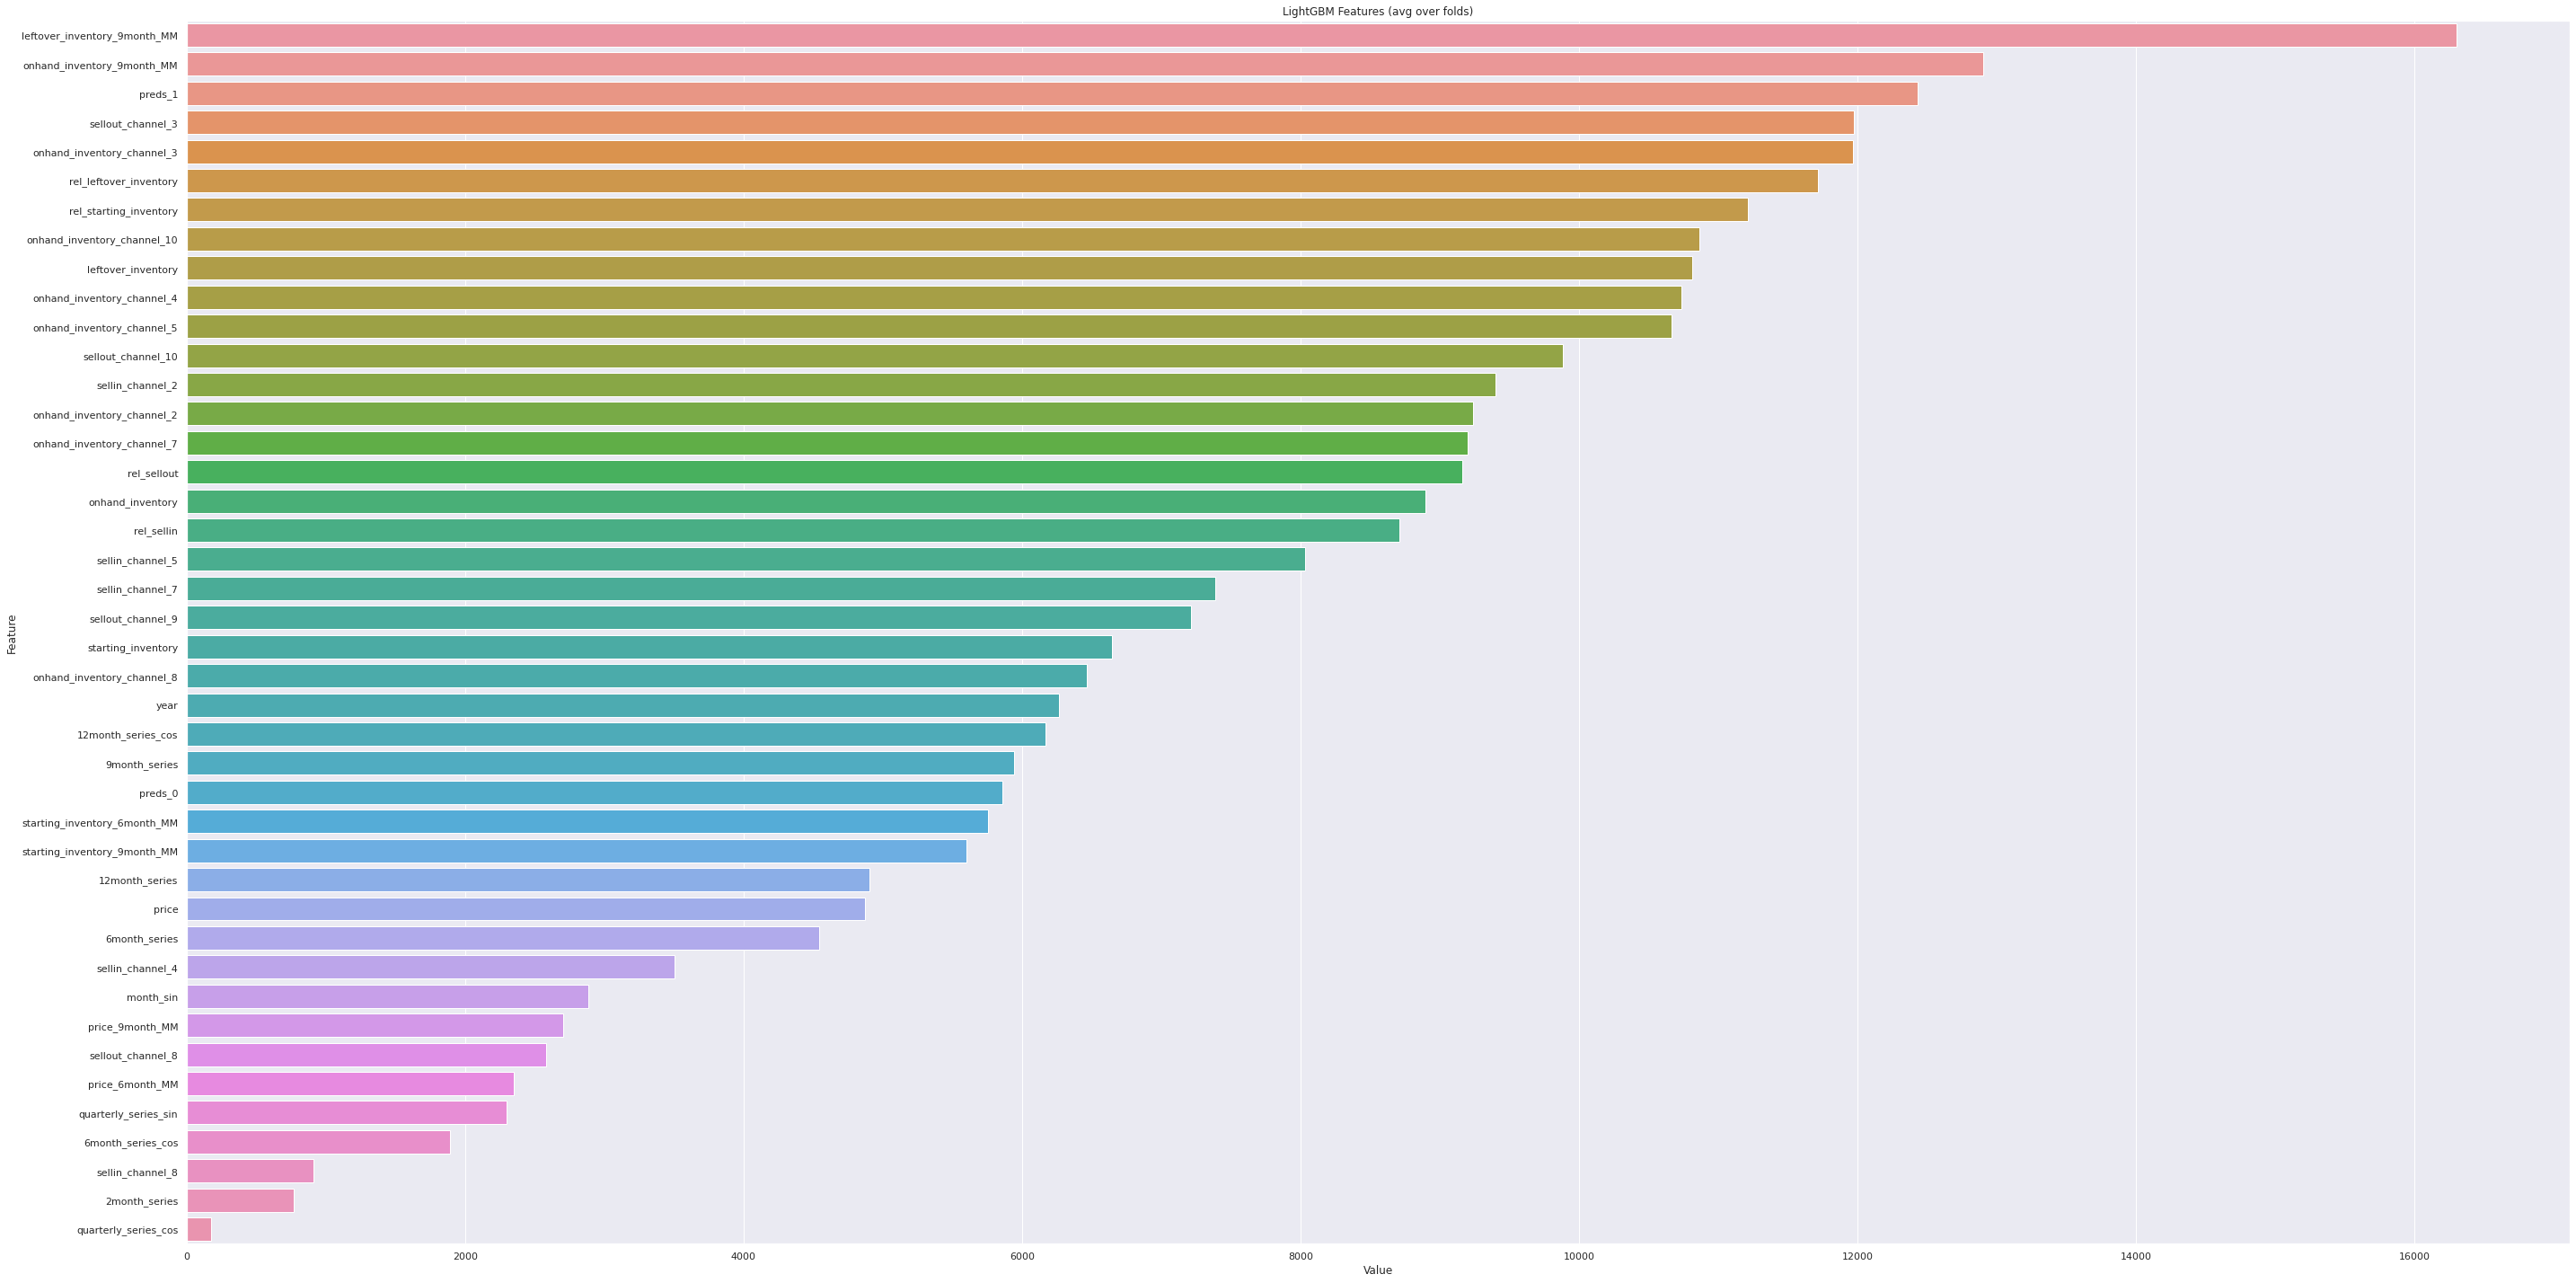

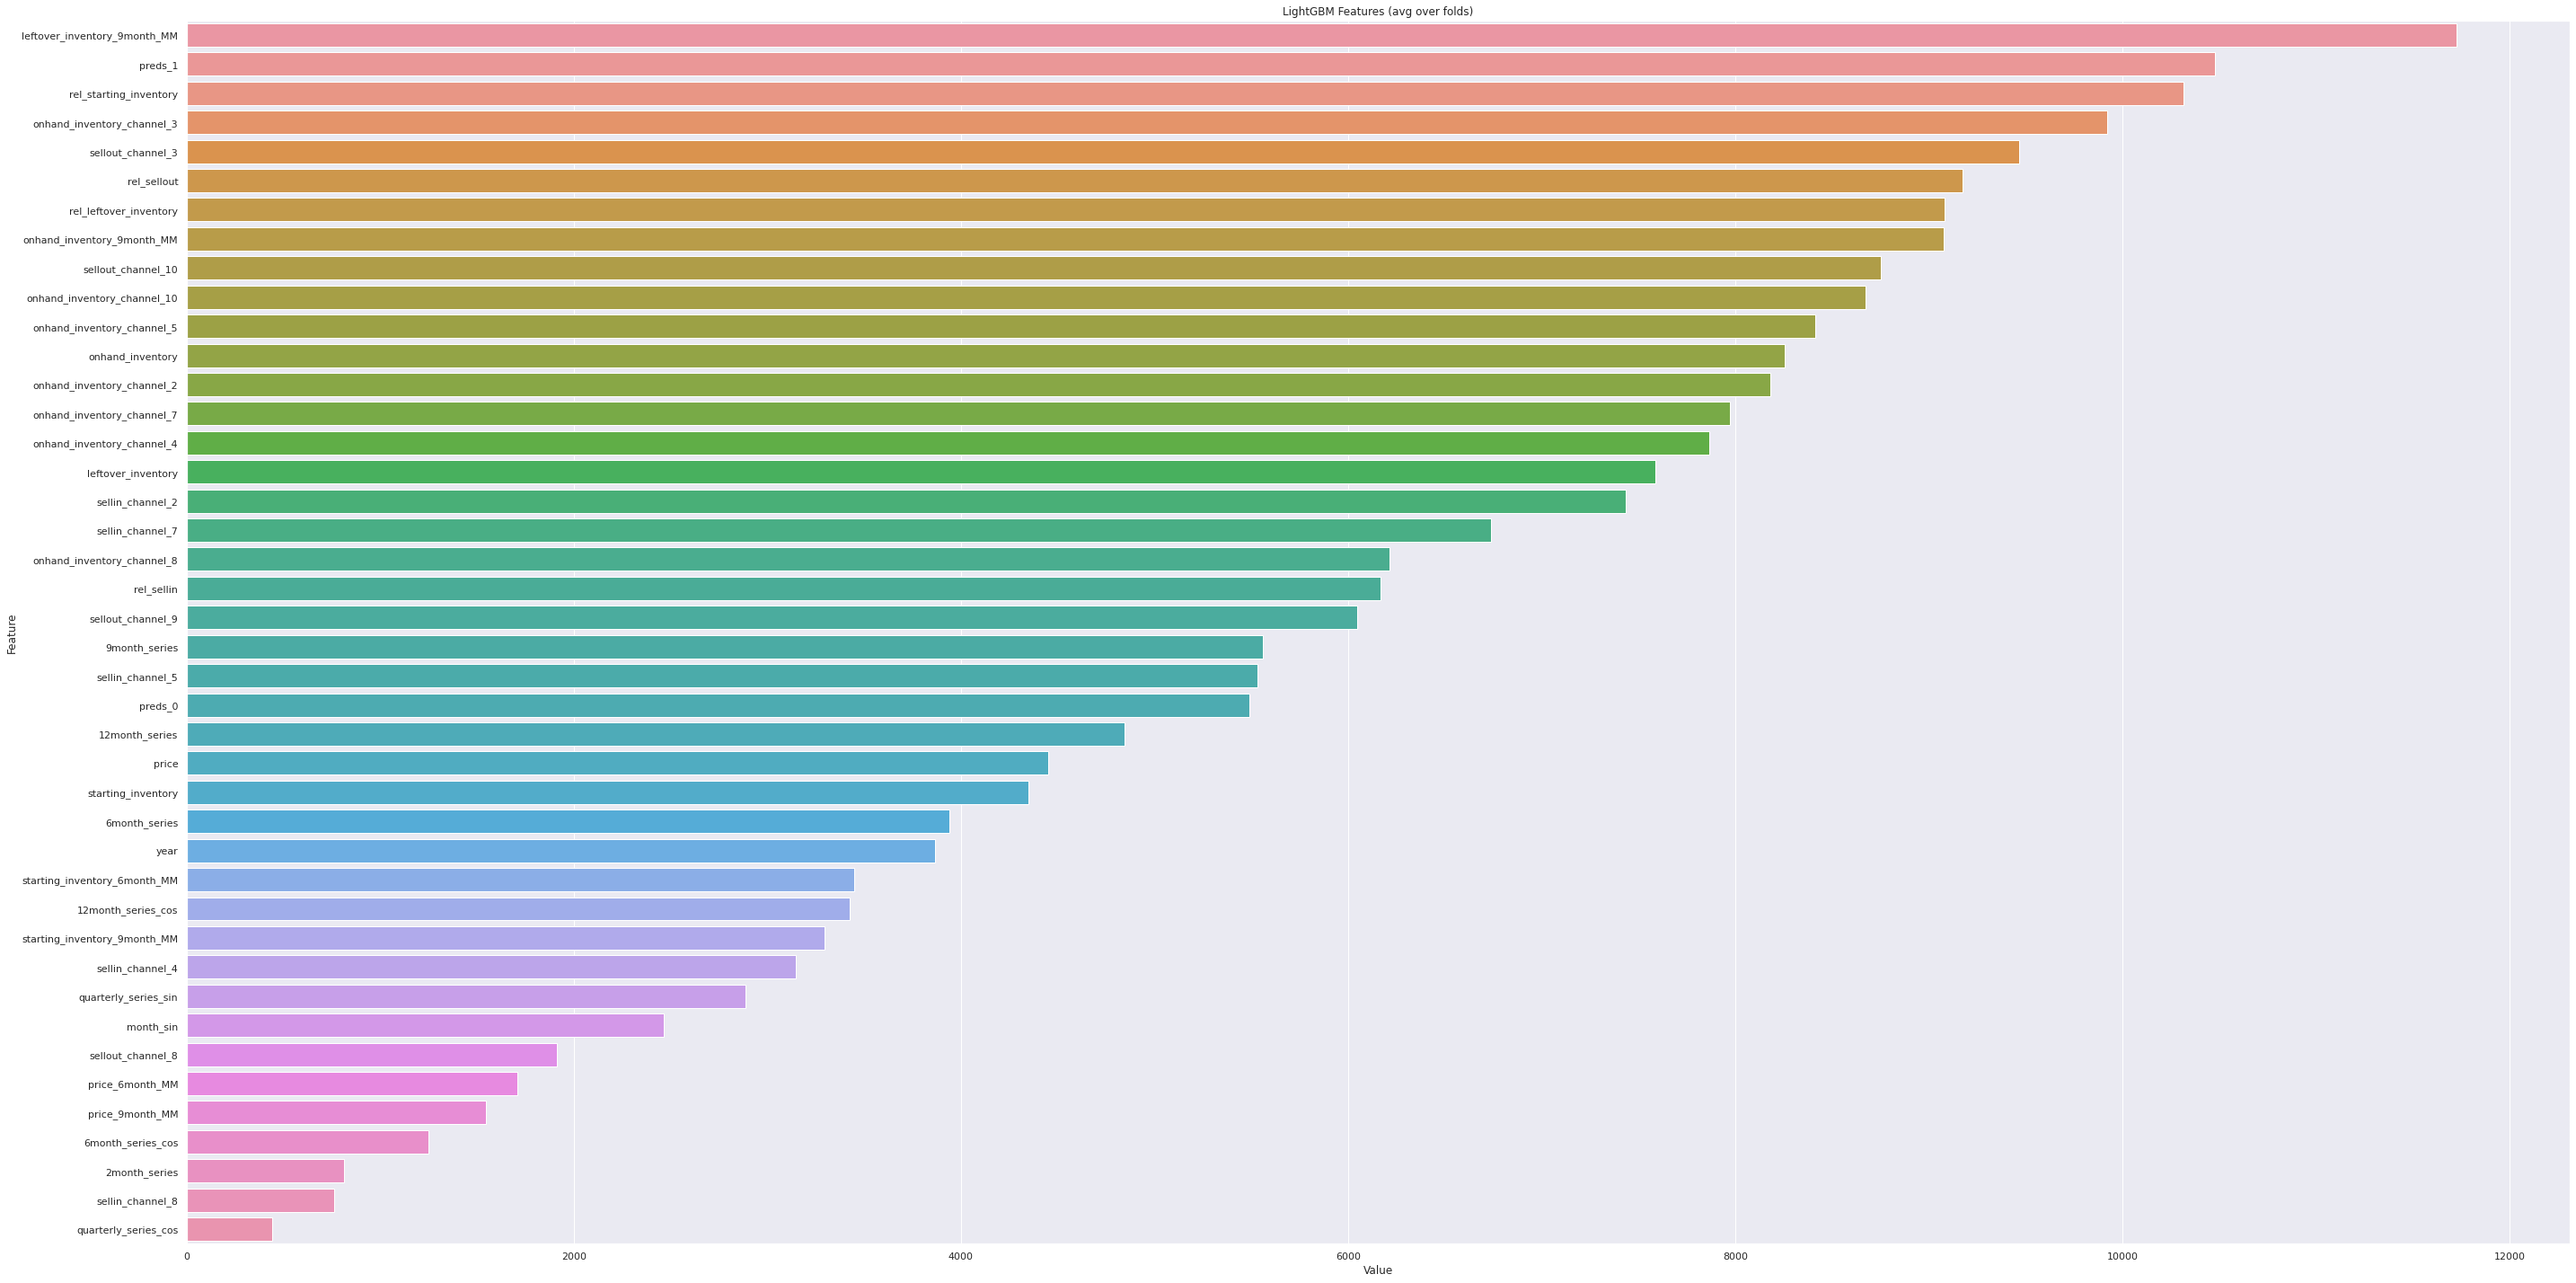

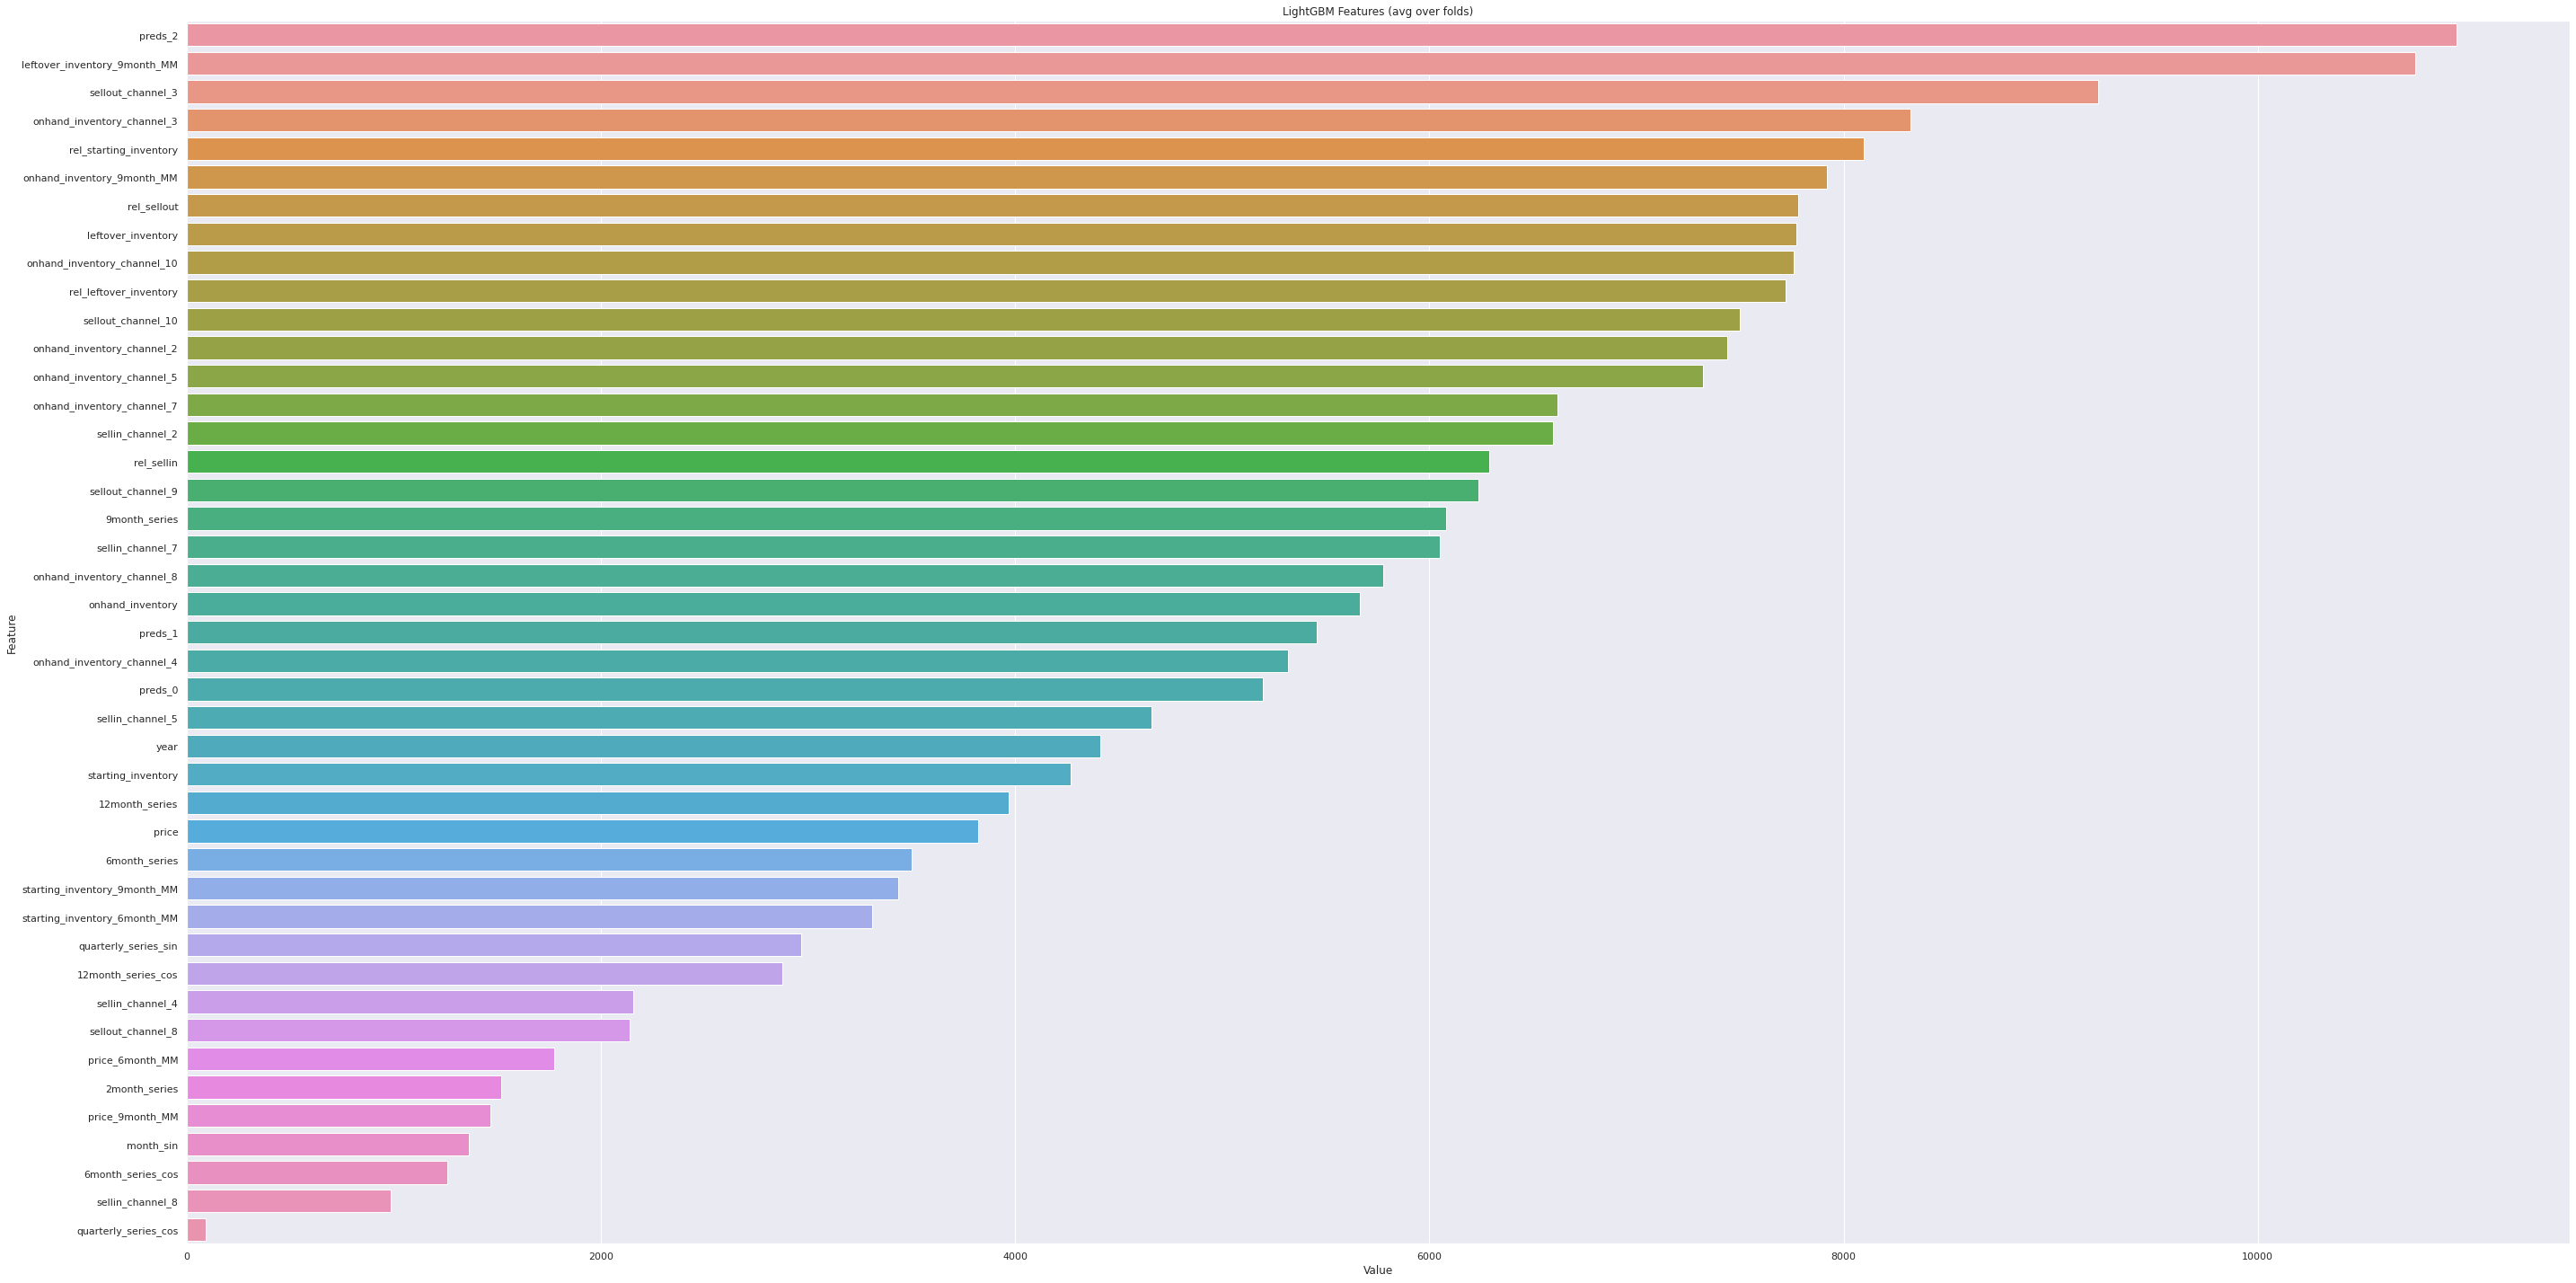

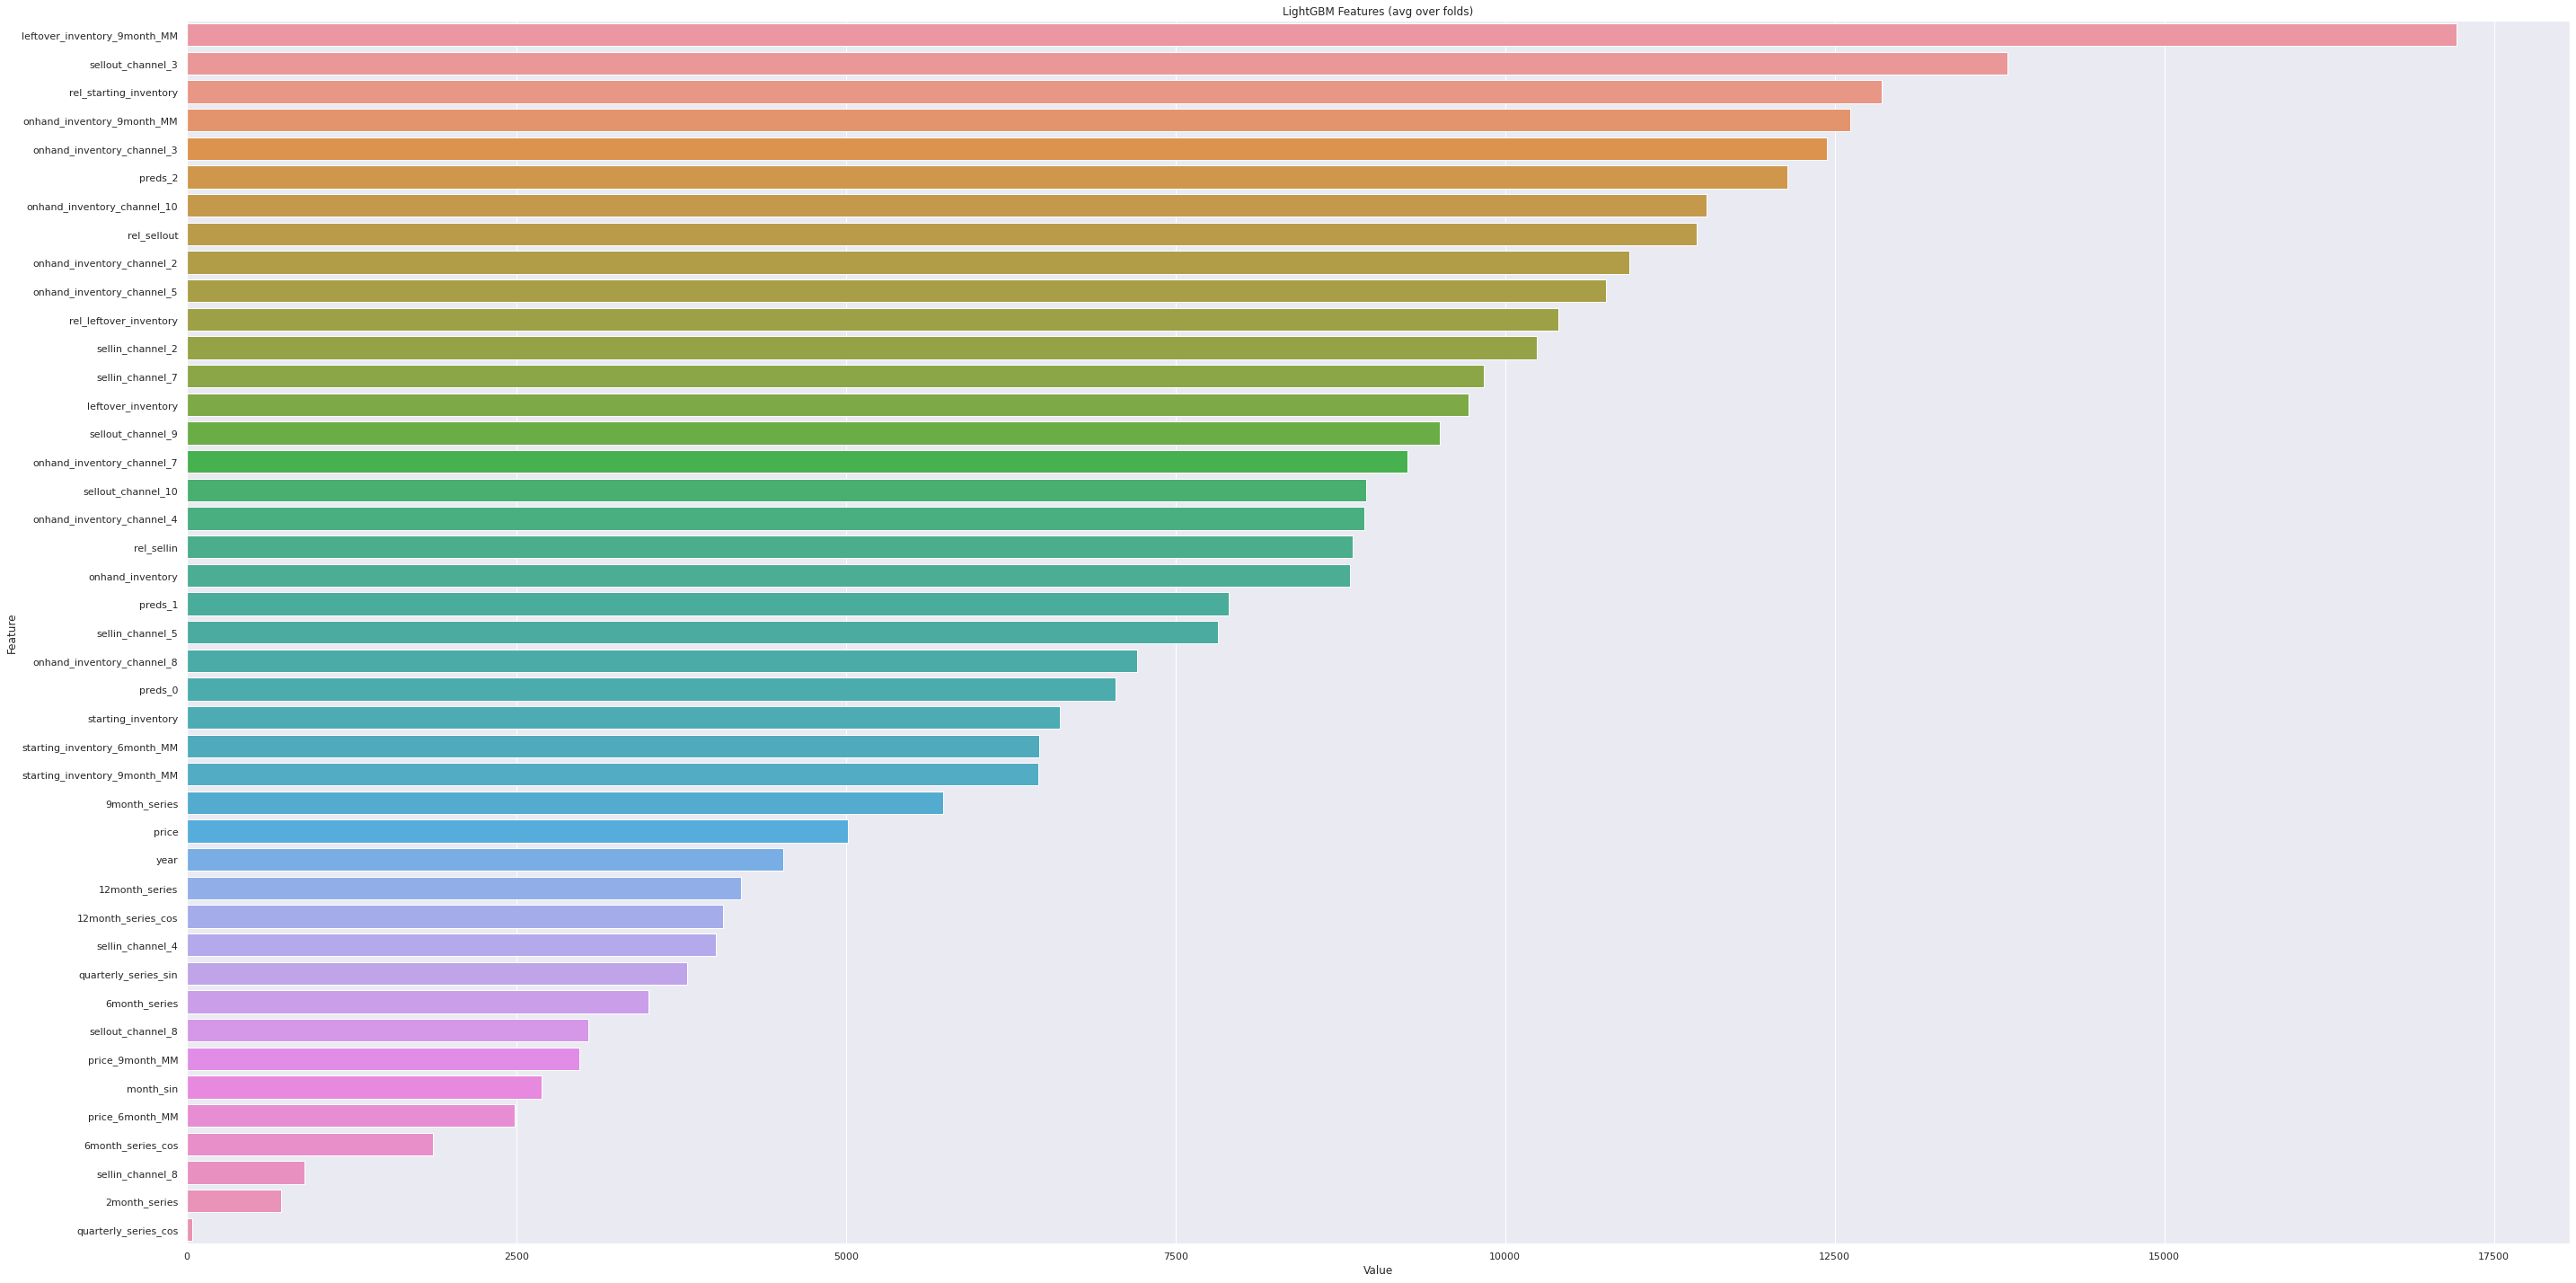

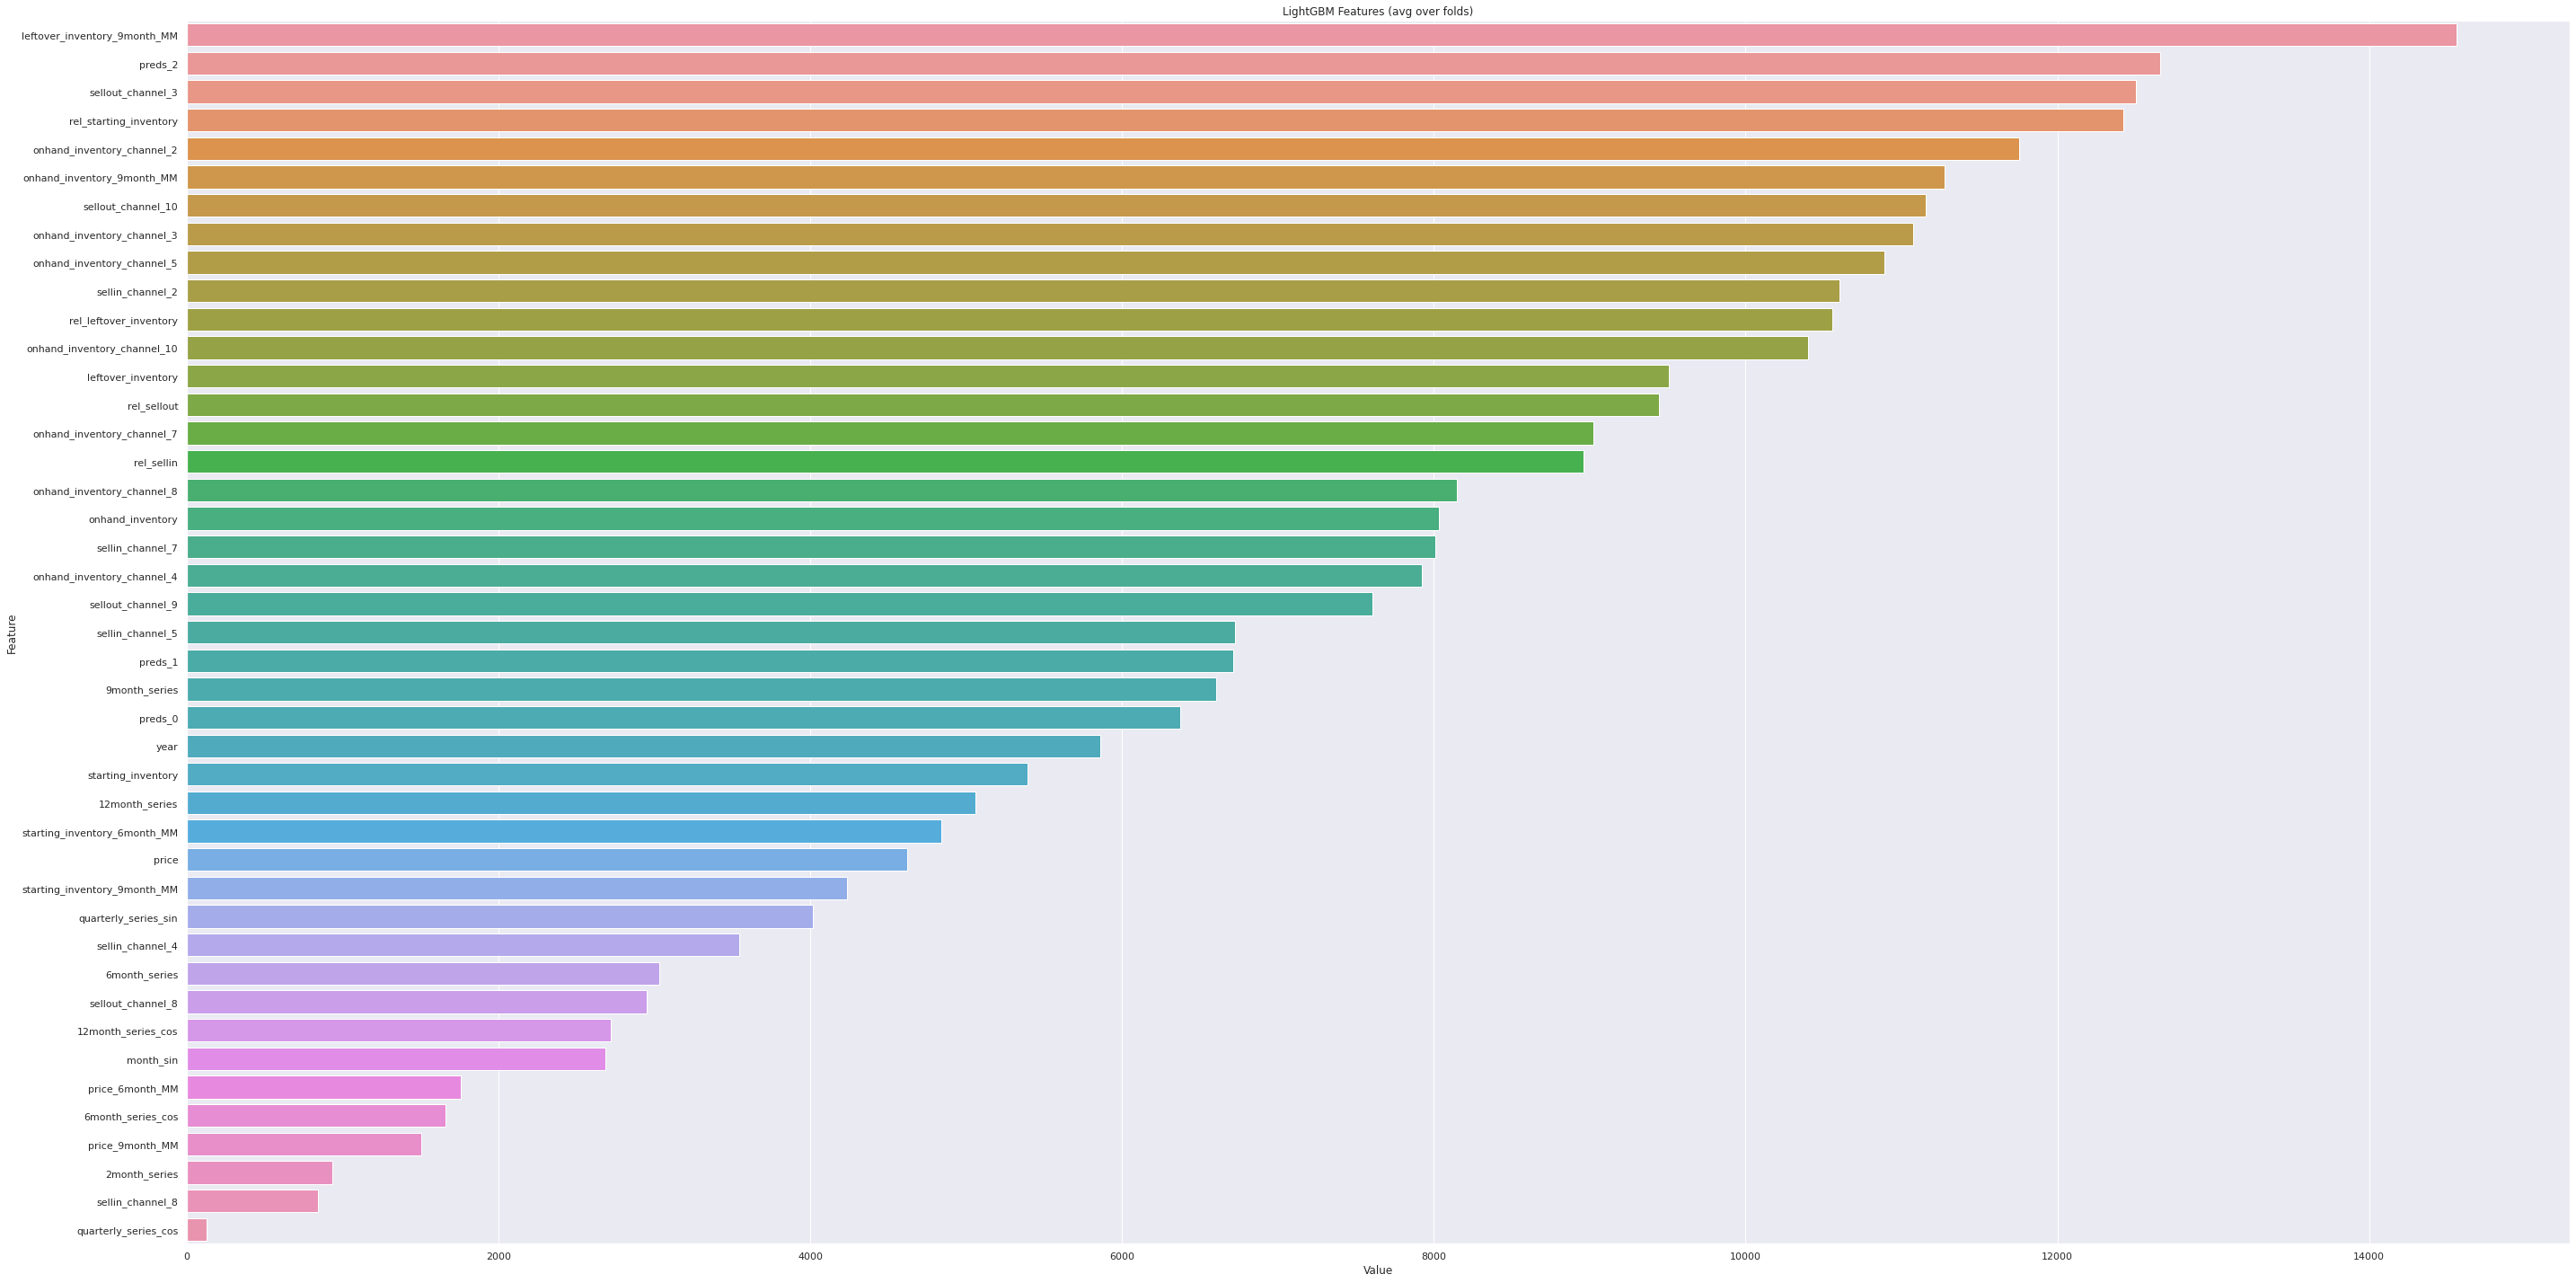

In [369]:
feature_importance = cv_feature_importance_plot(
    train_data.drop(columns=[f'preds_{i}' for i in range(N_STEPS)]), 
    folds, 
    lgb_cv_models,
    True,
    pca_cols=most_important_cols)

In [1556]:
train_data.drop(columns=[f'preds_{i}' for i in range(N_STEPS)], inplace=True)

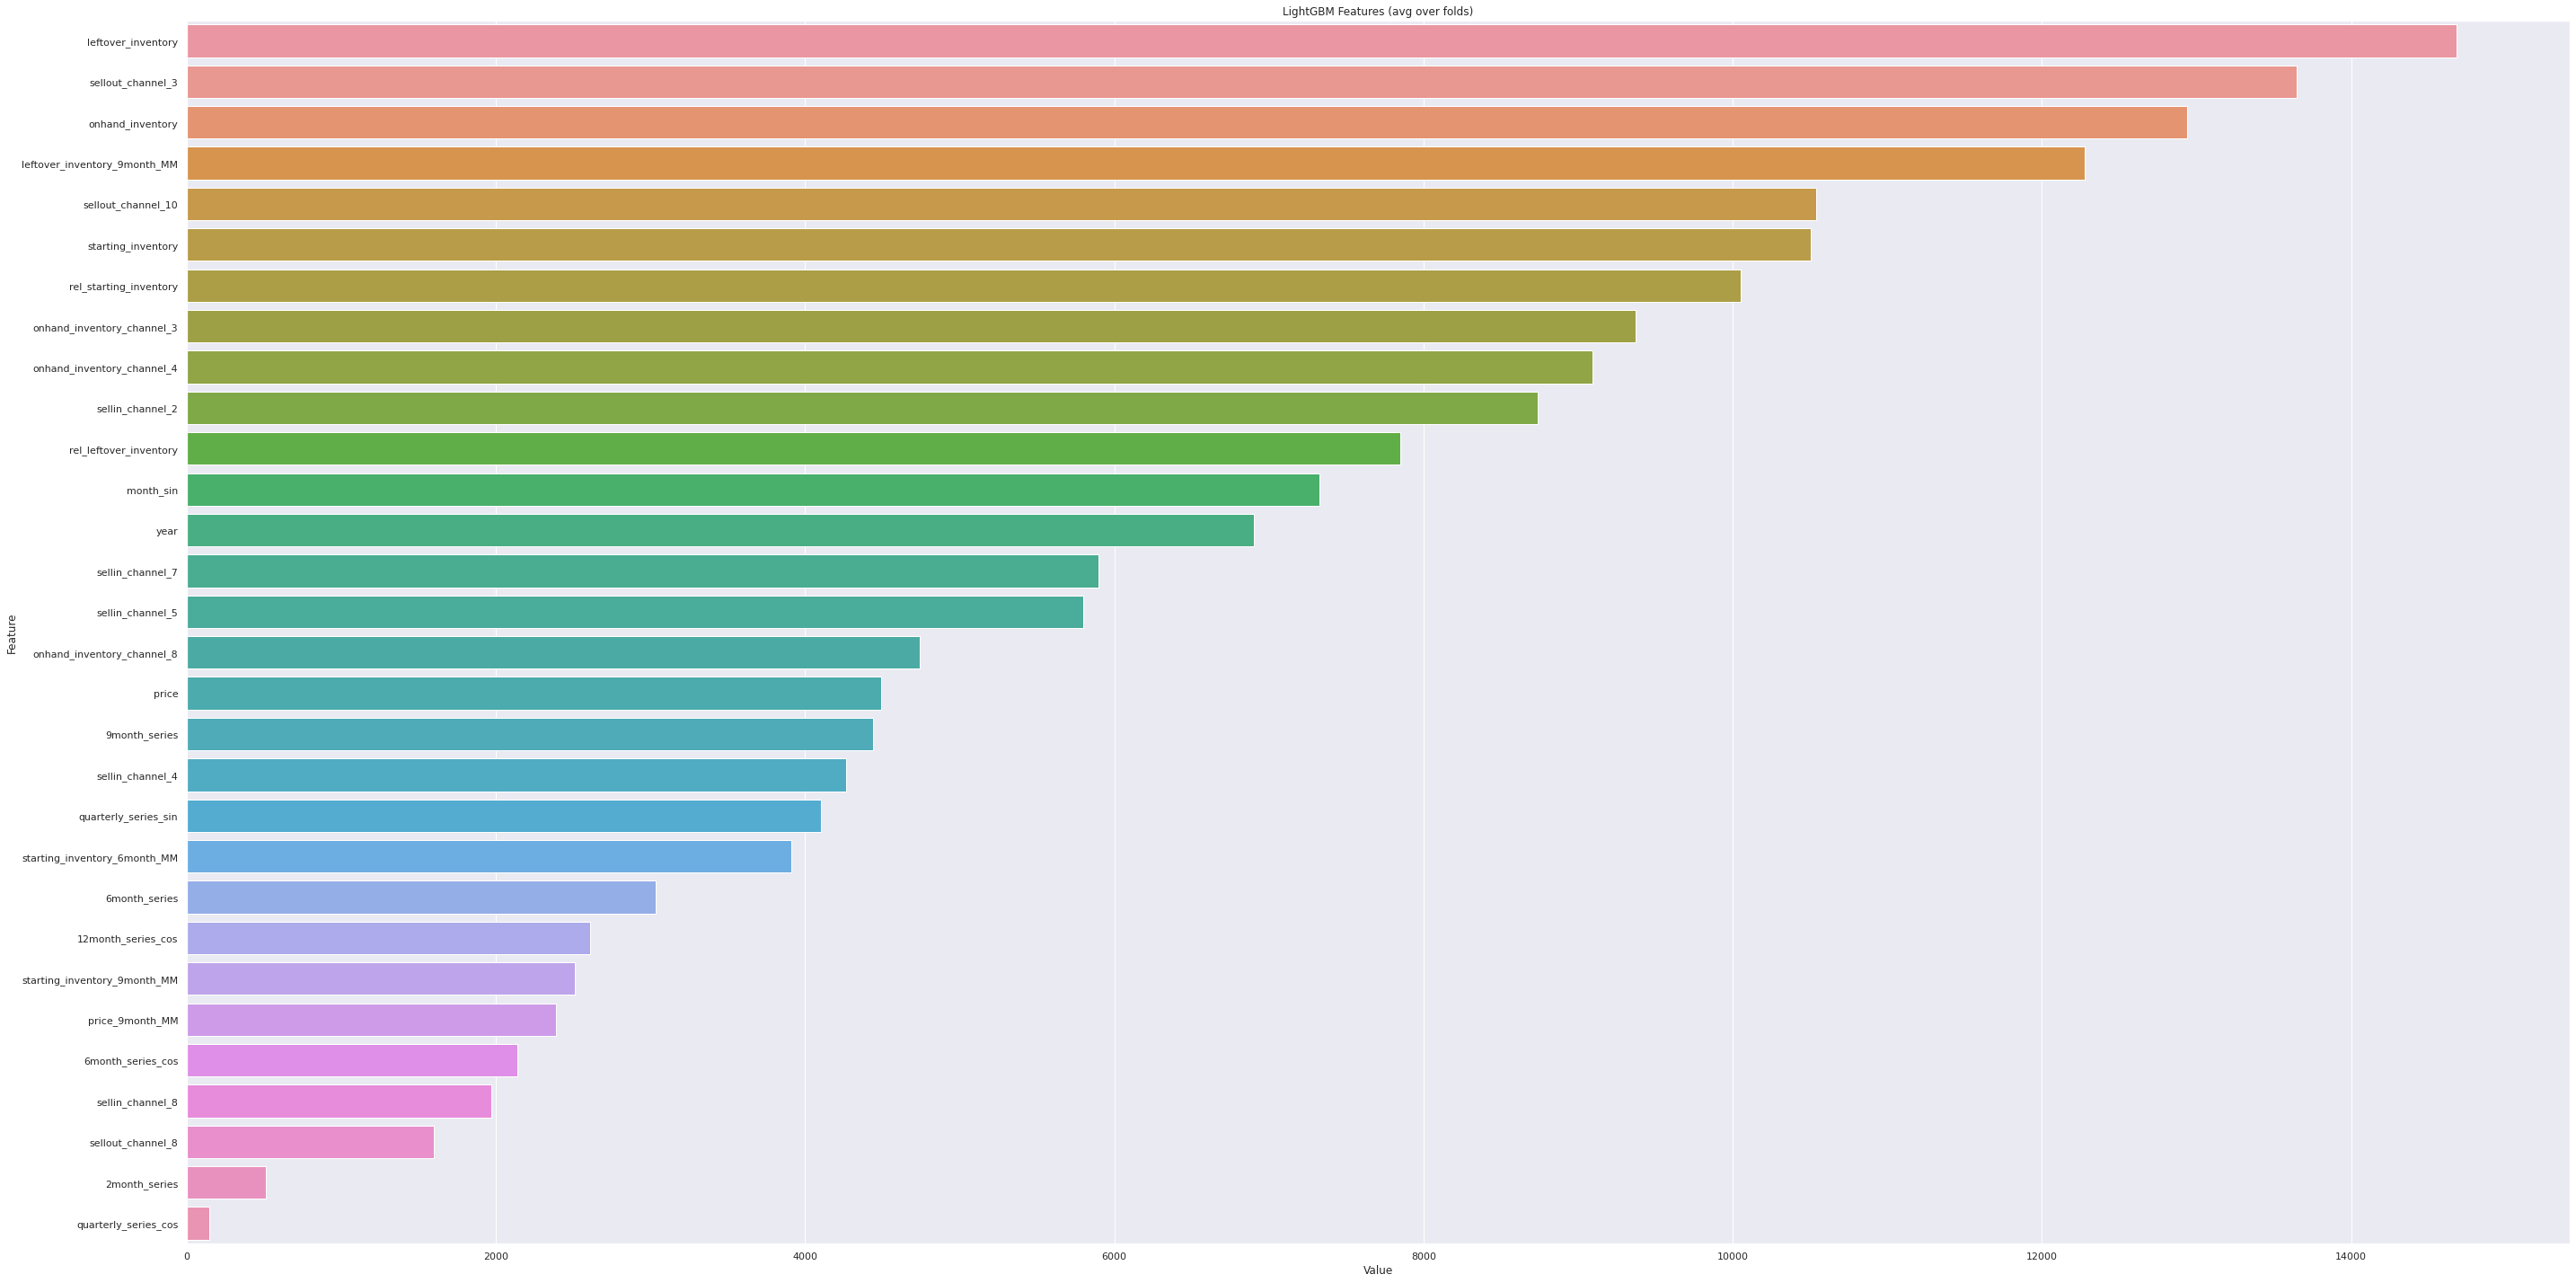

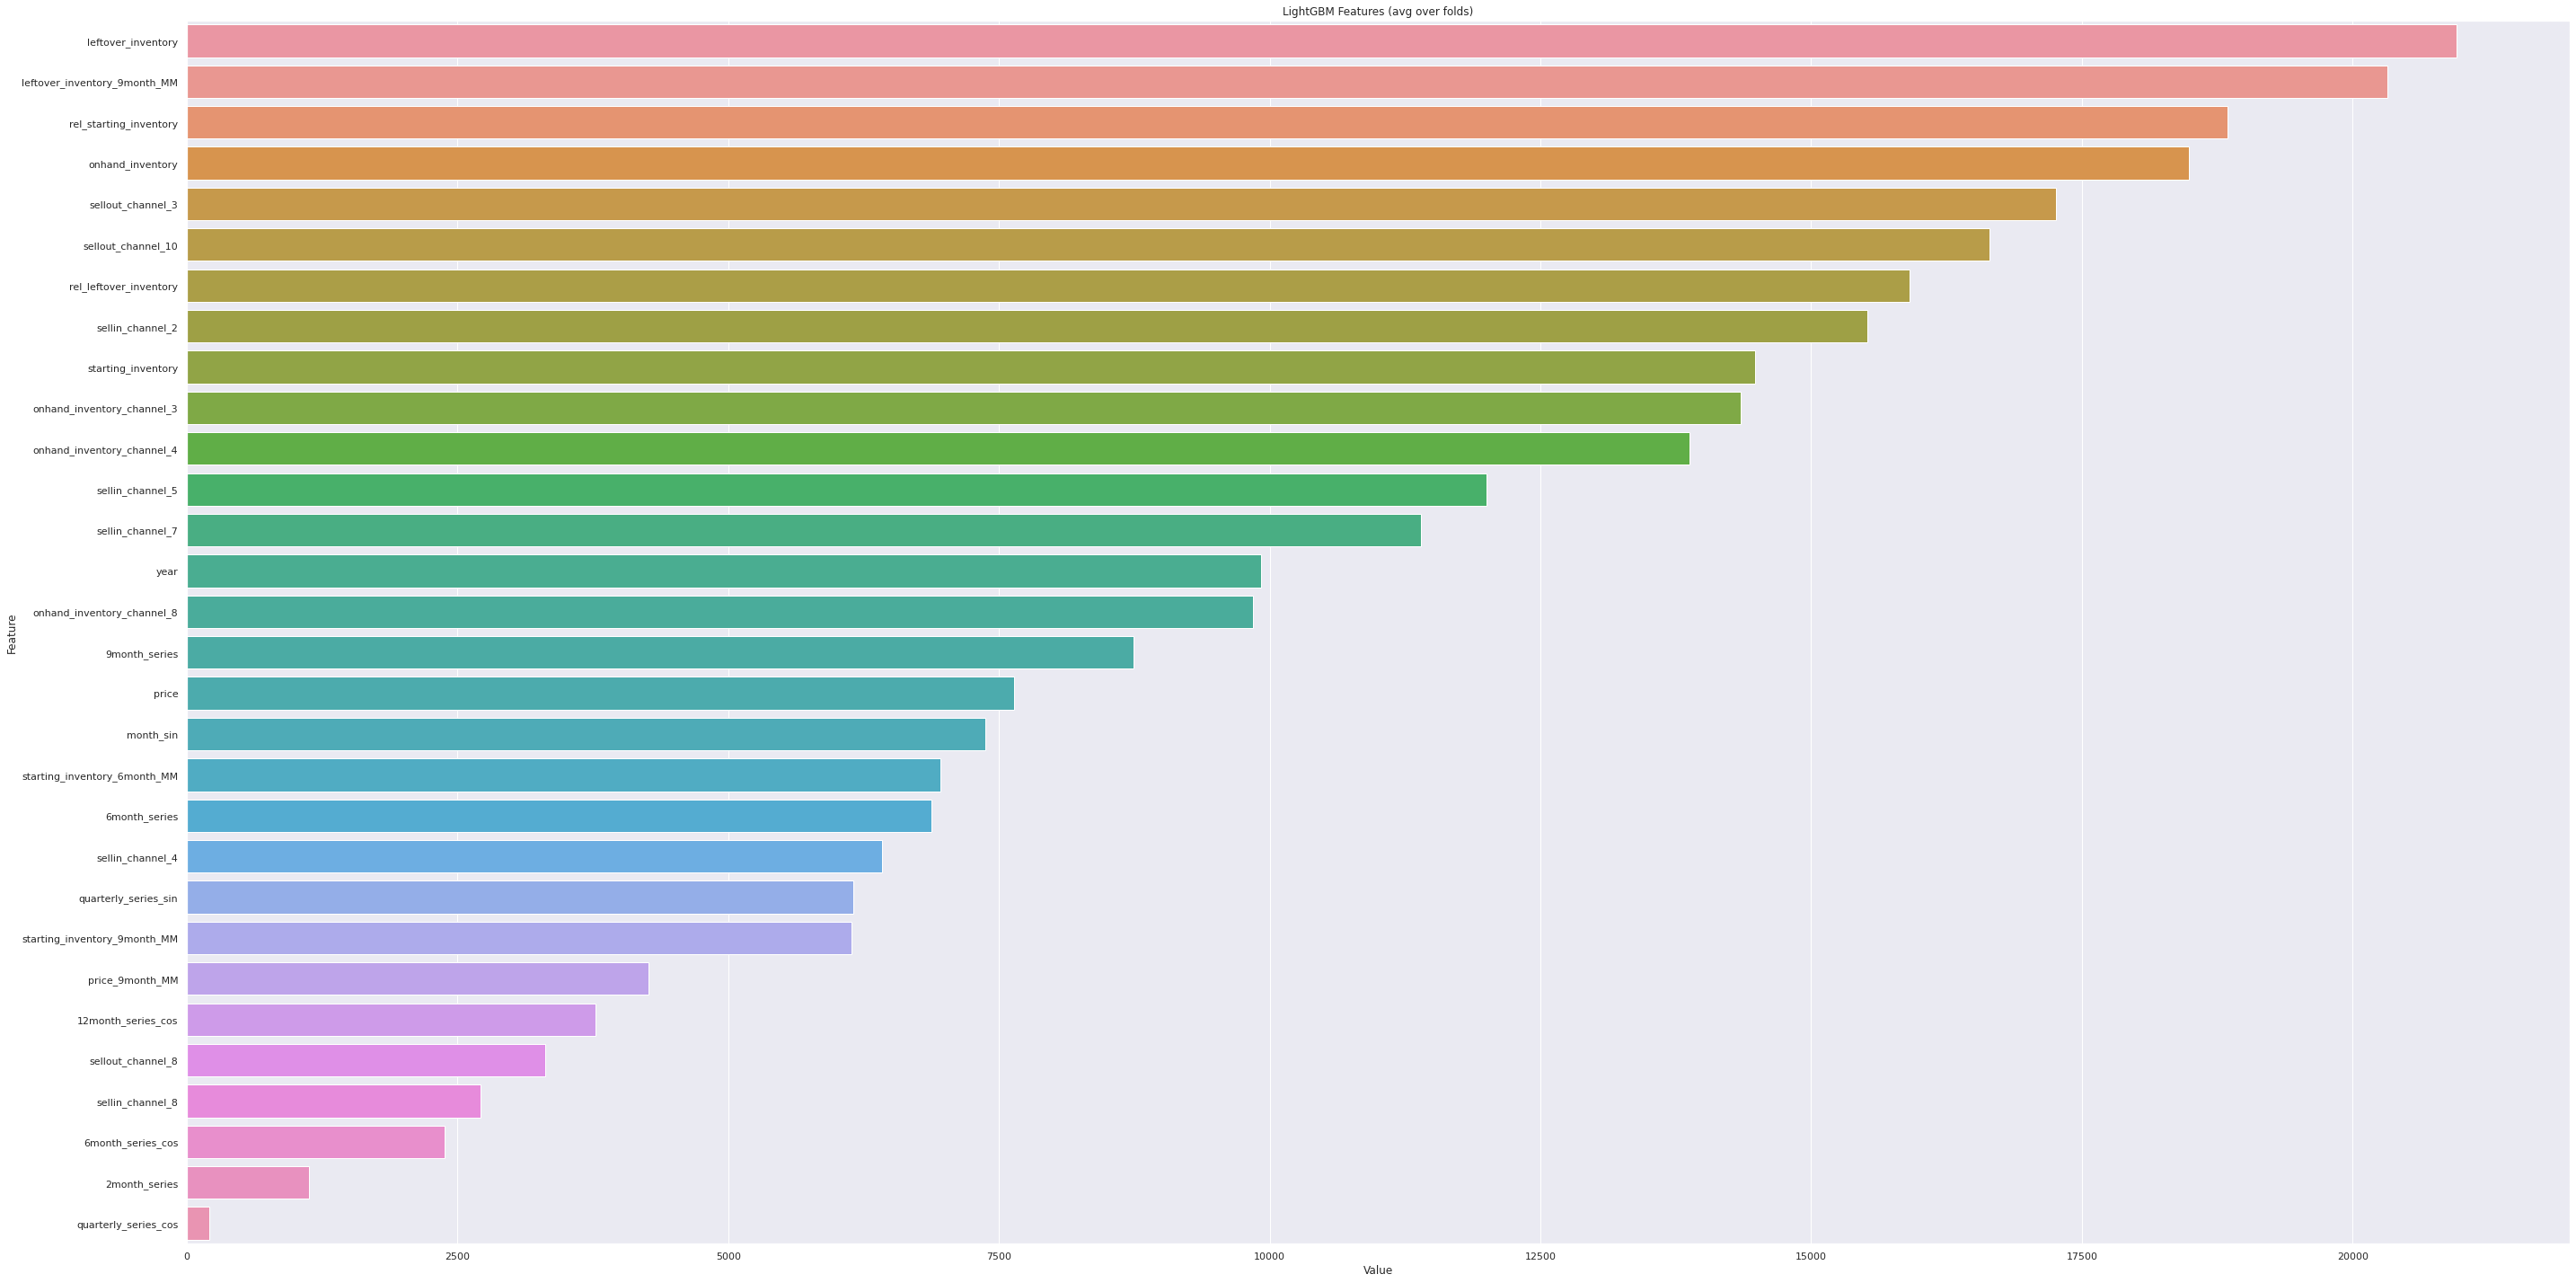

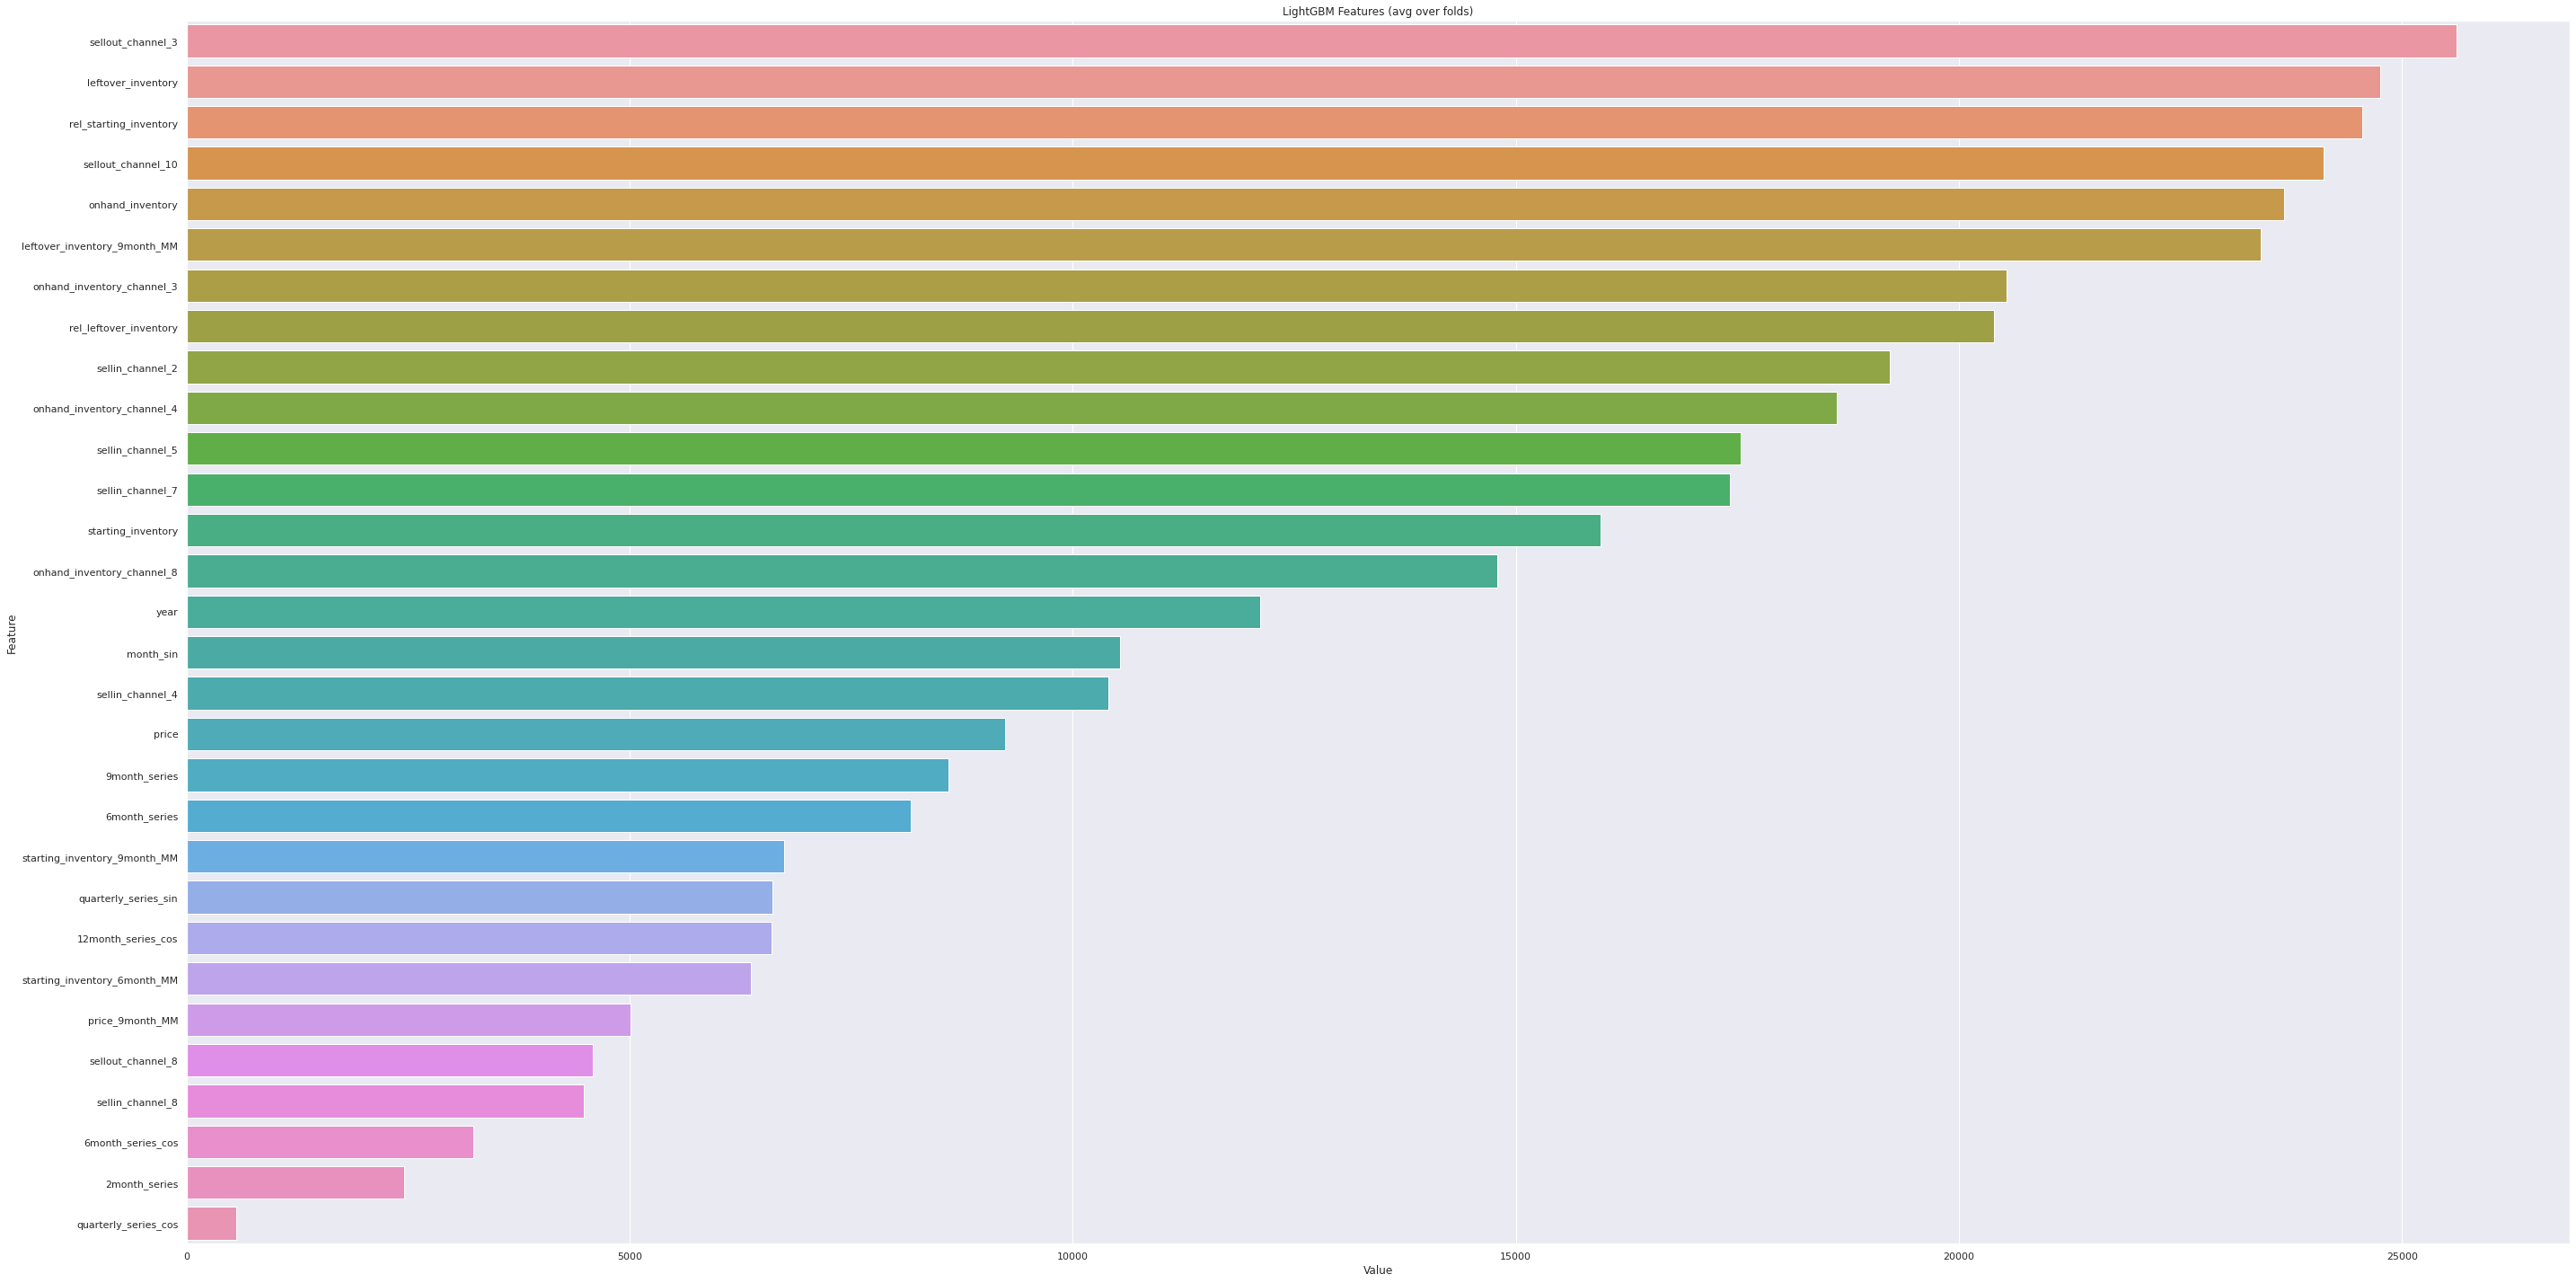

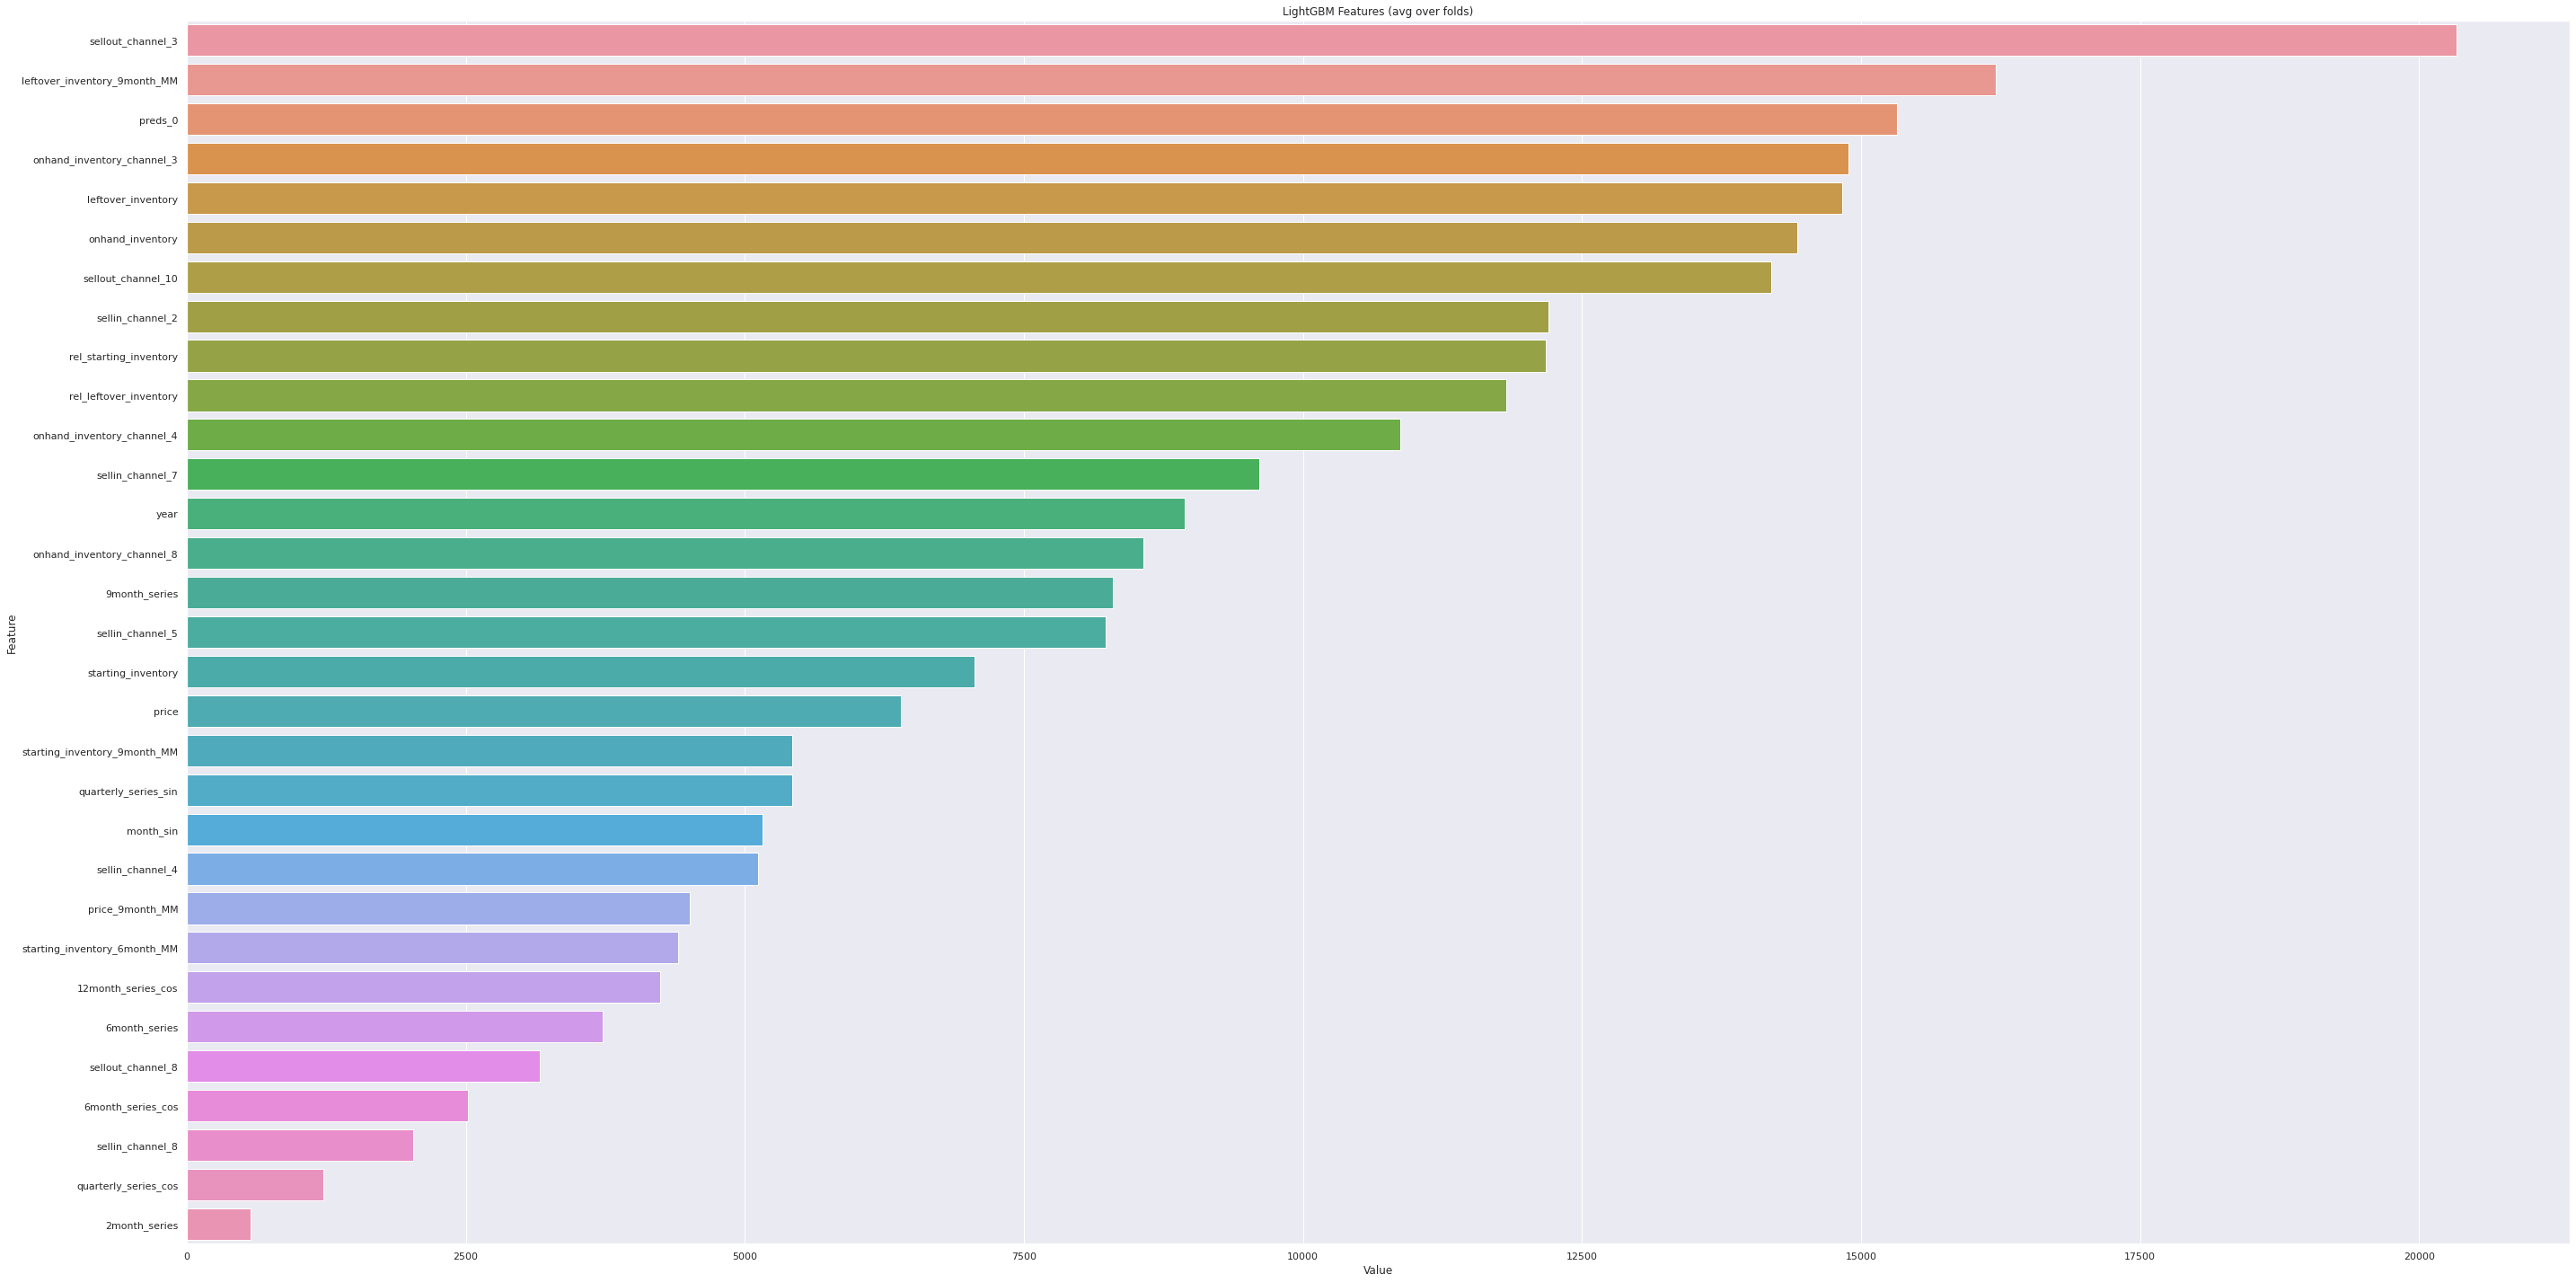

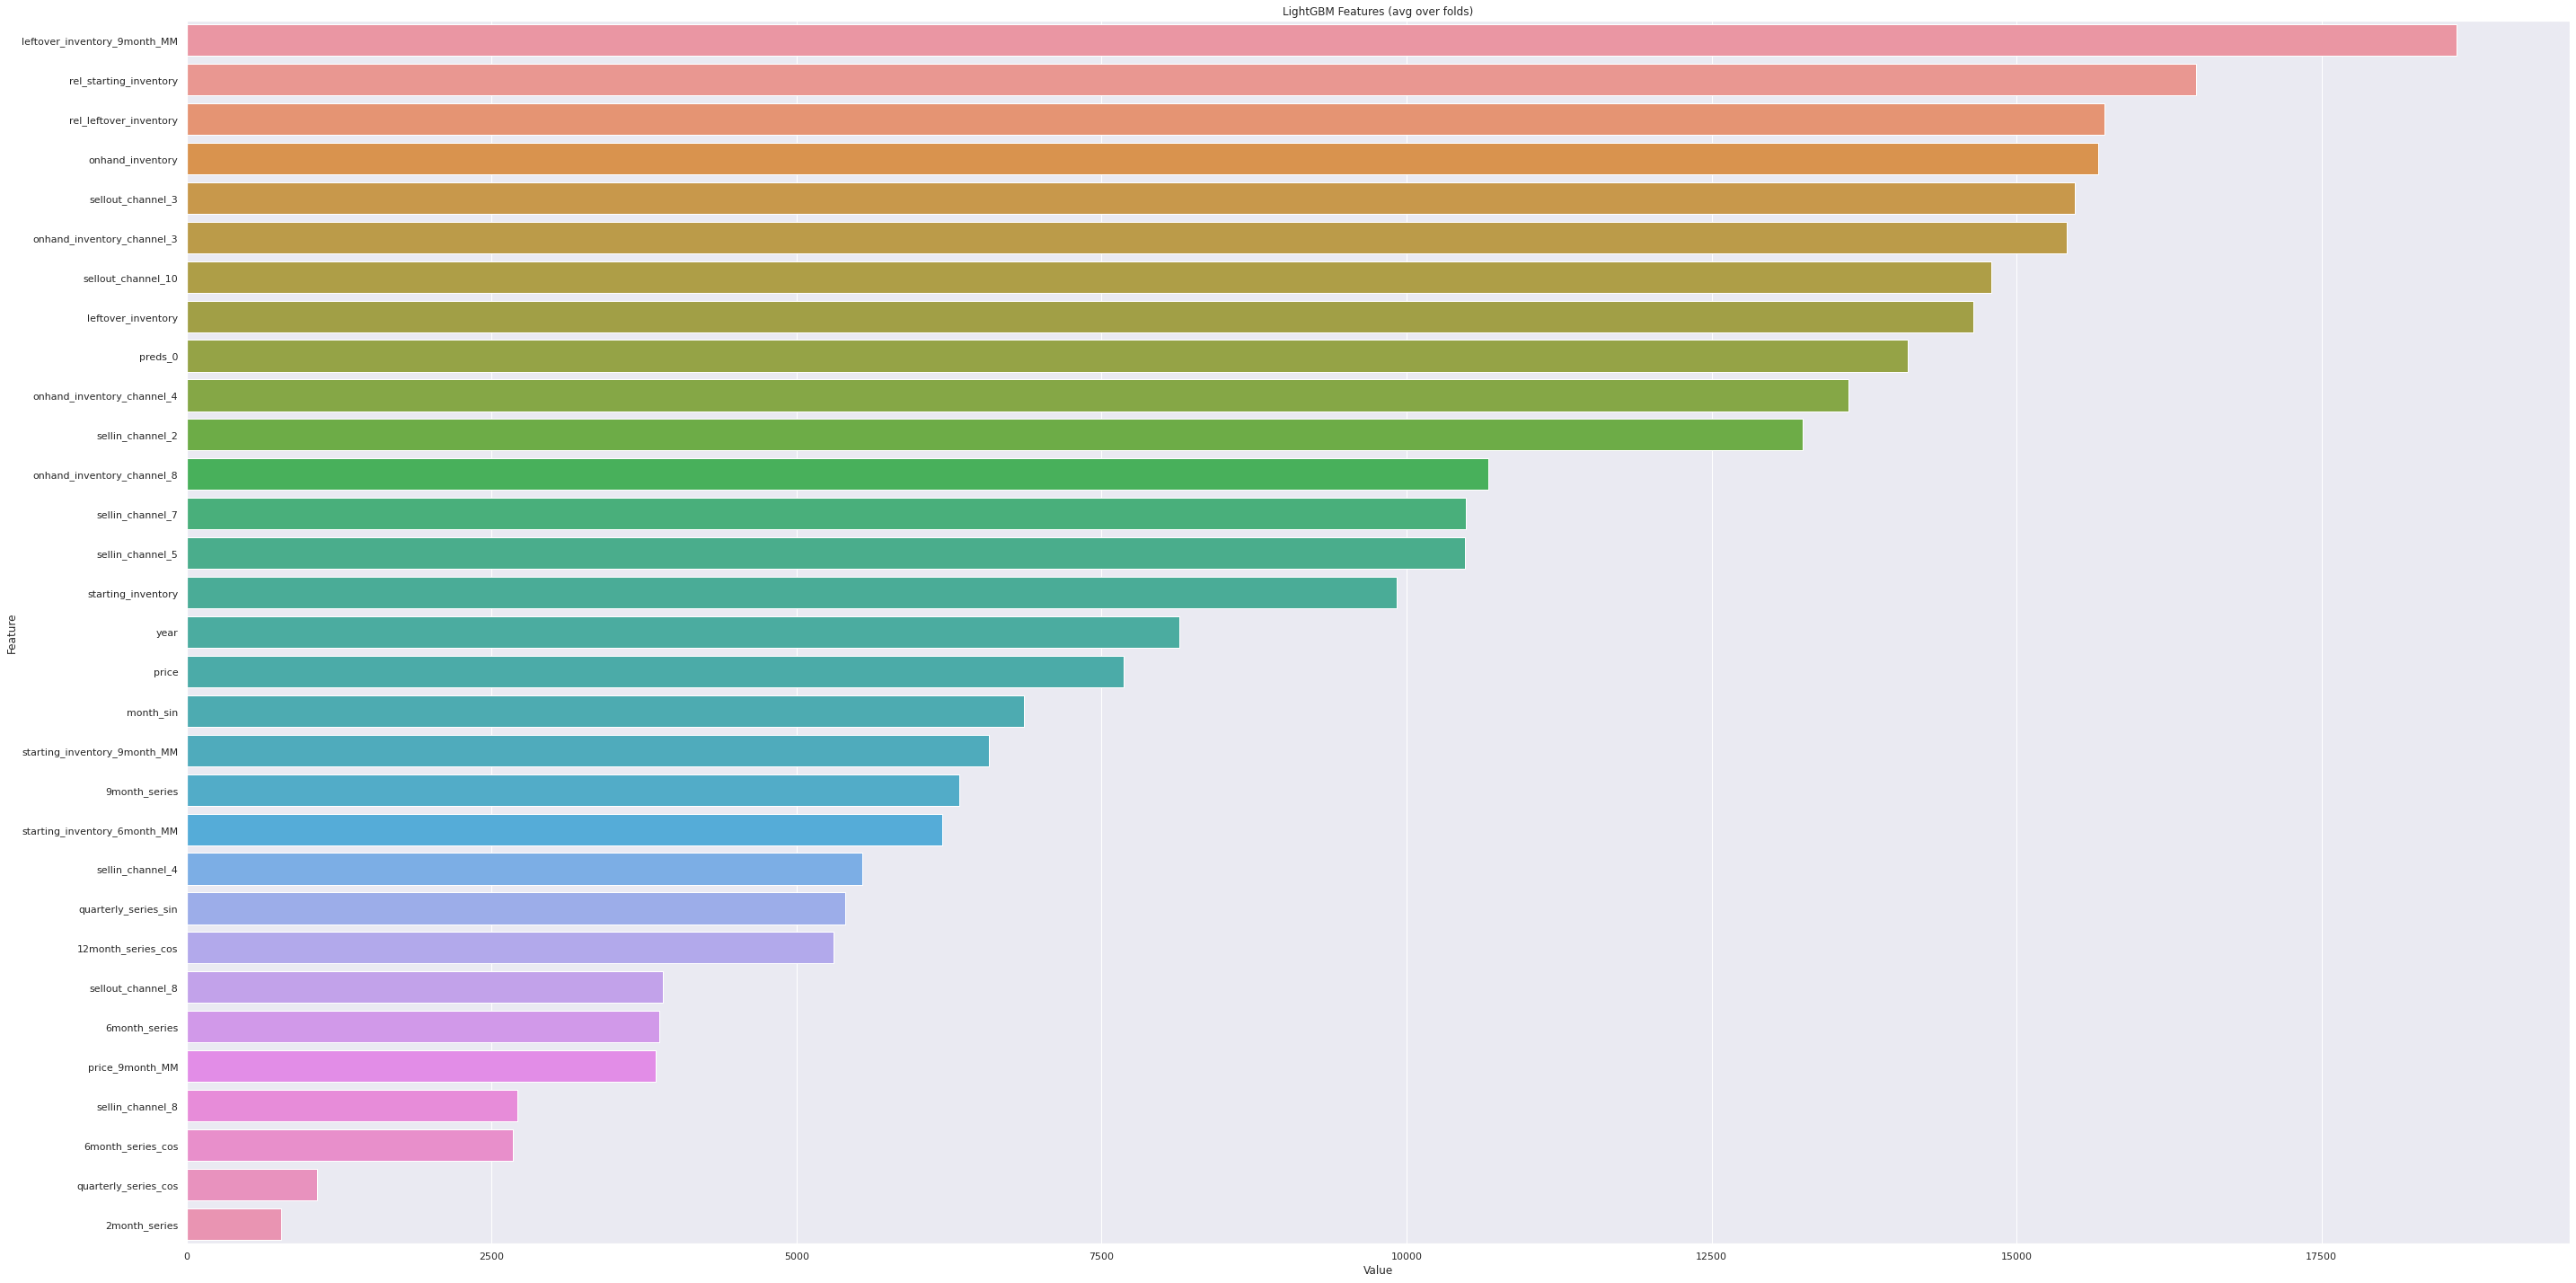

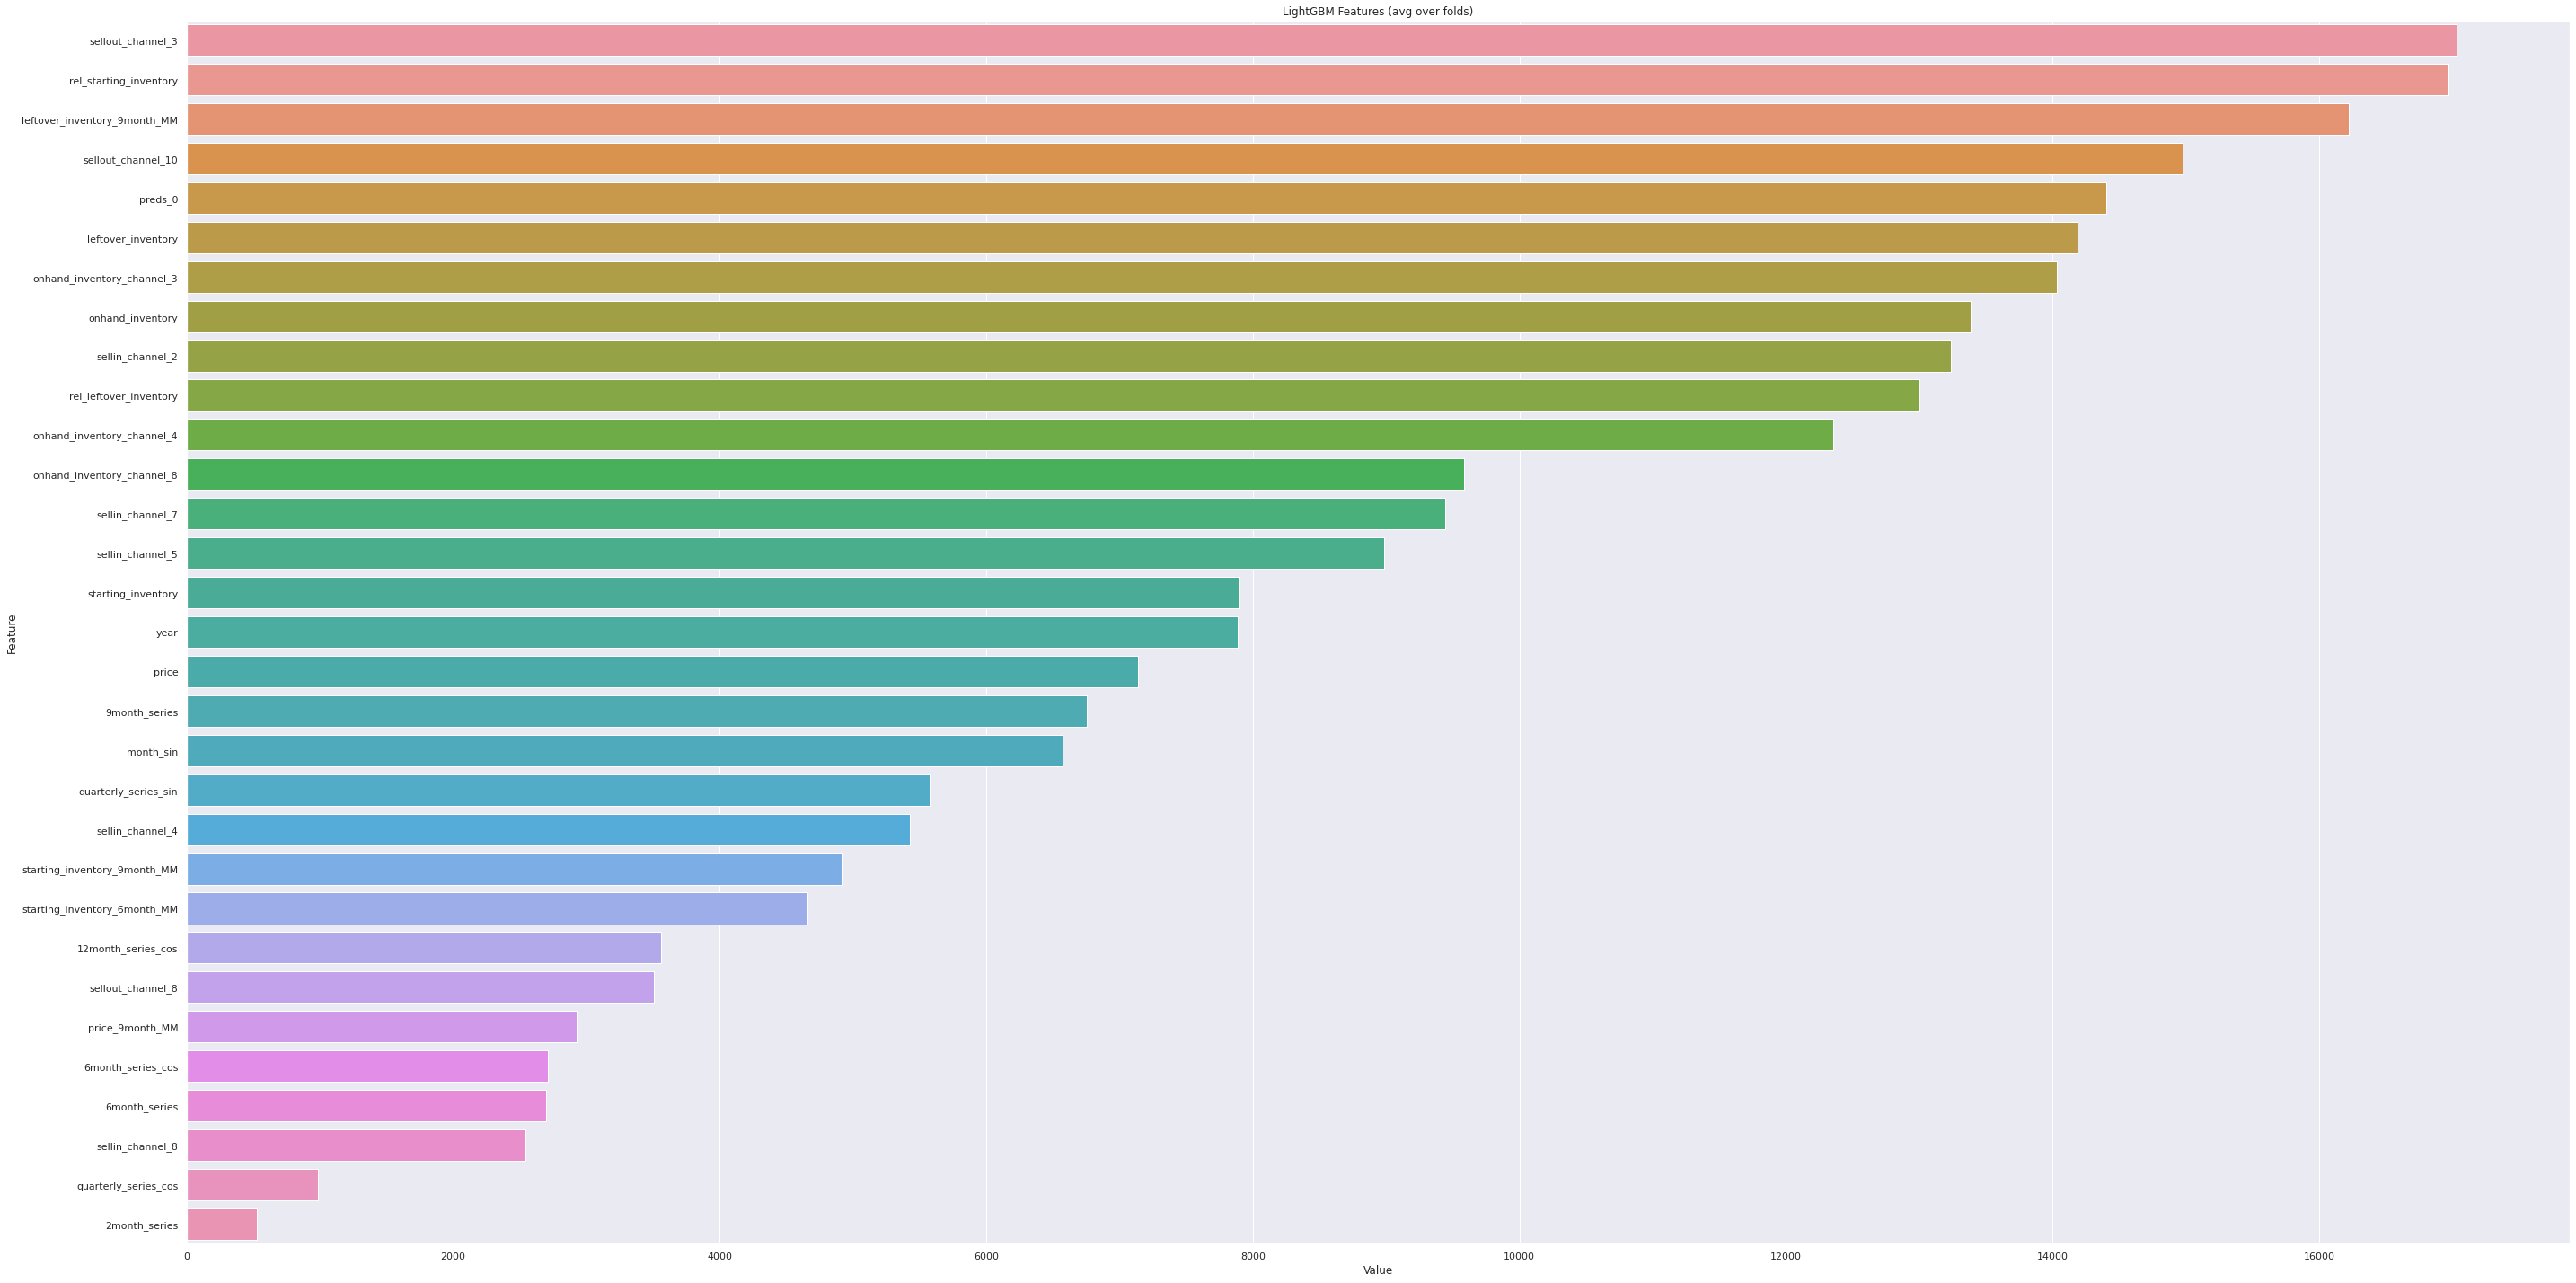

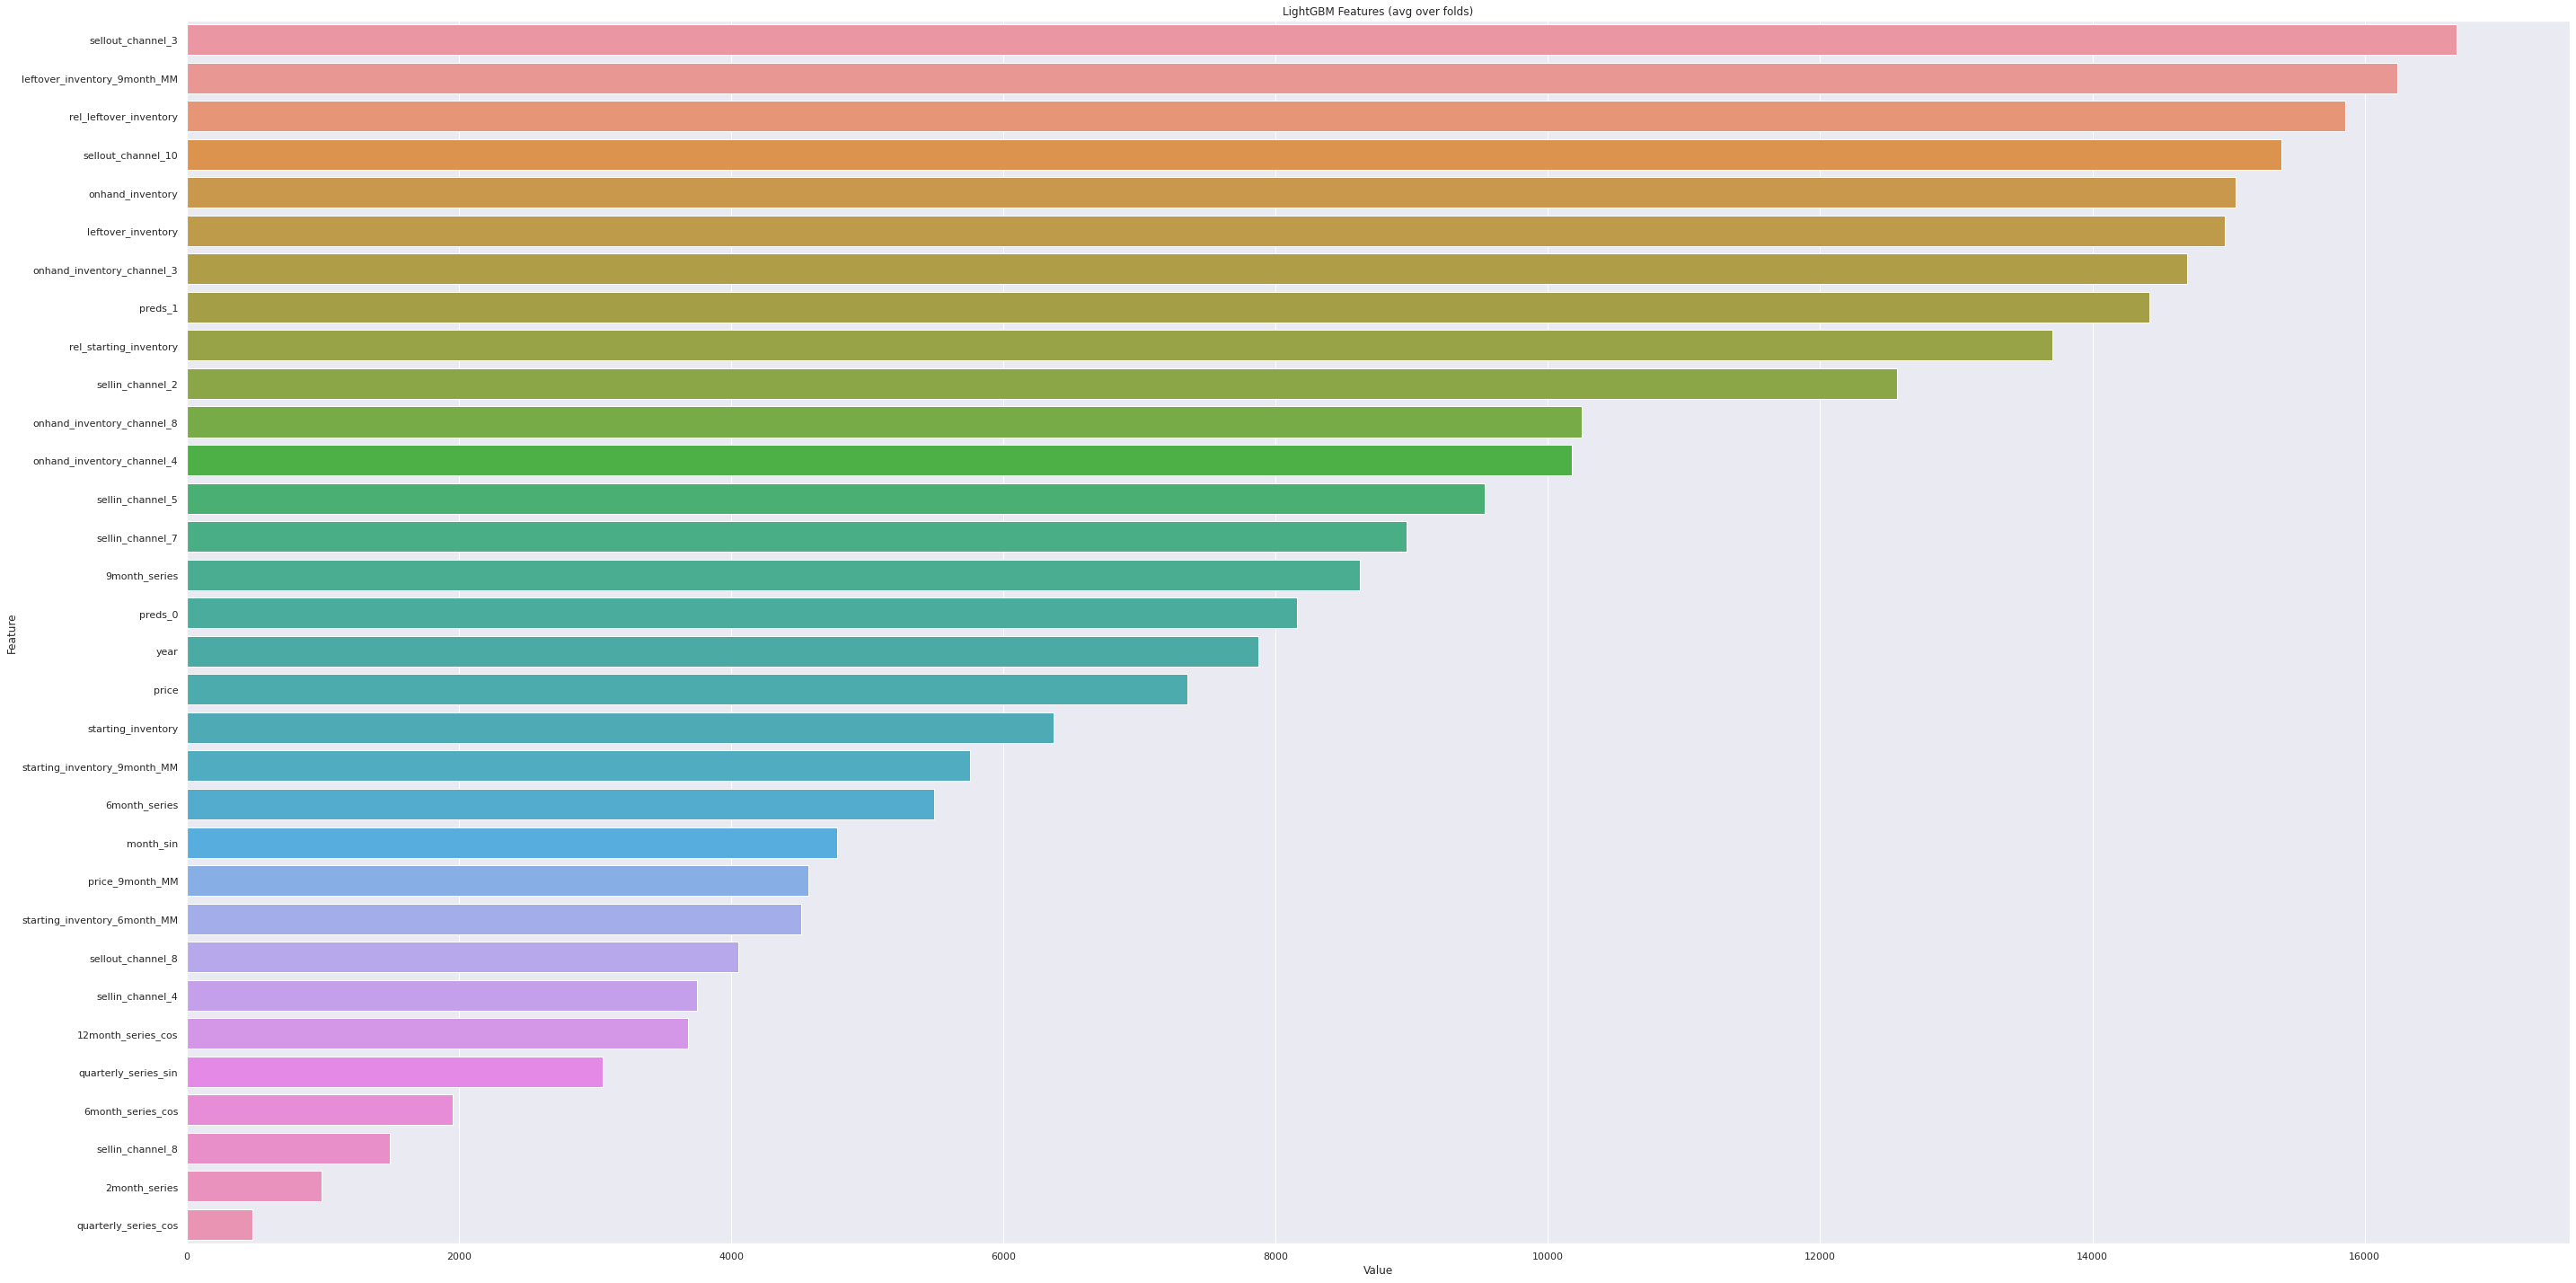

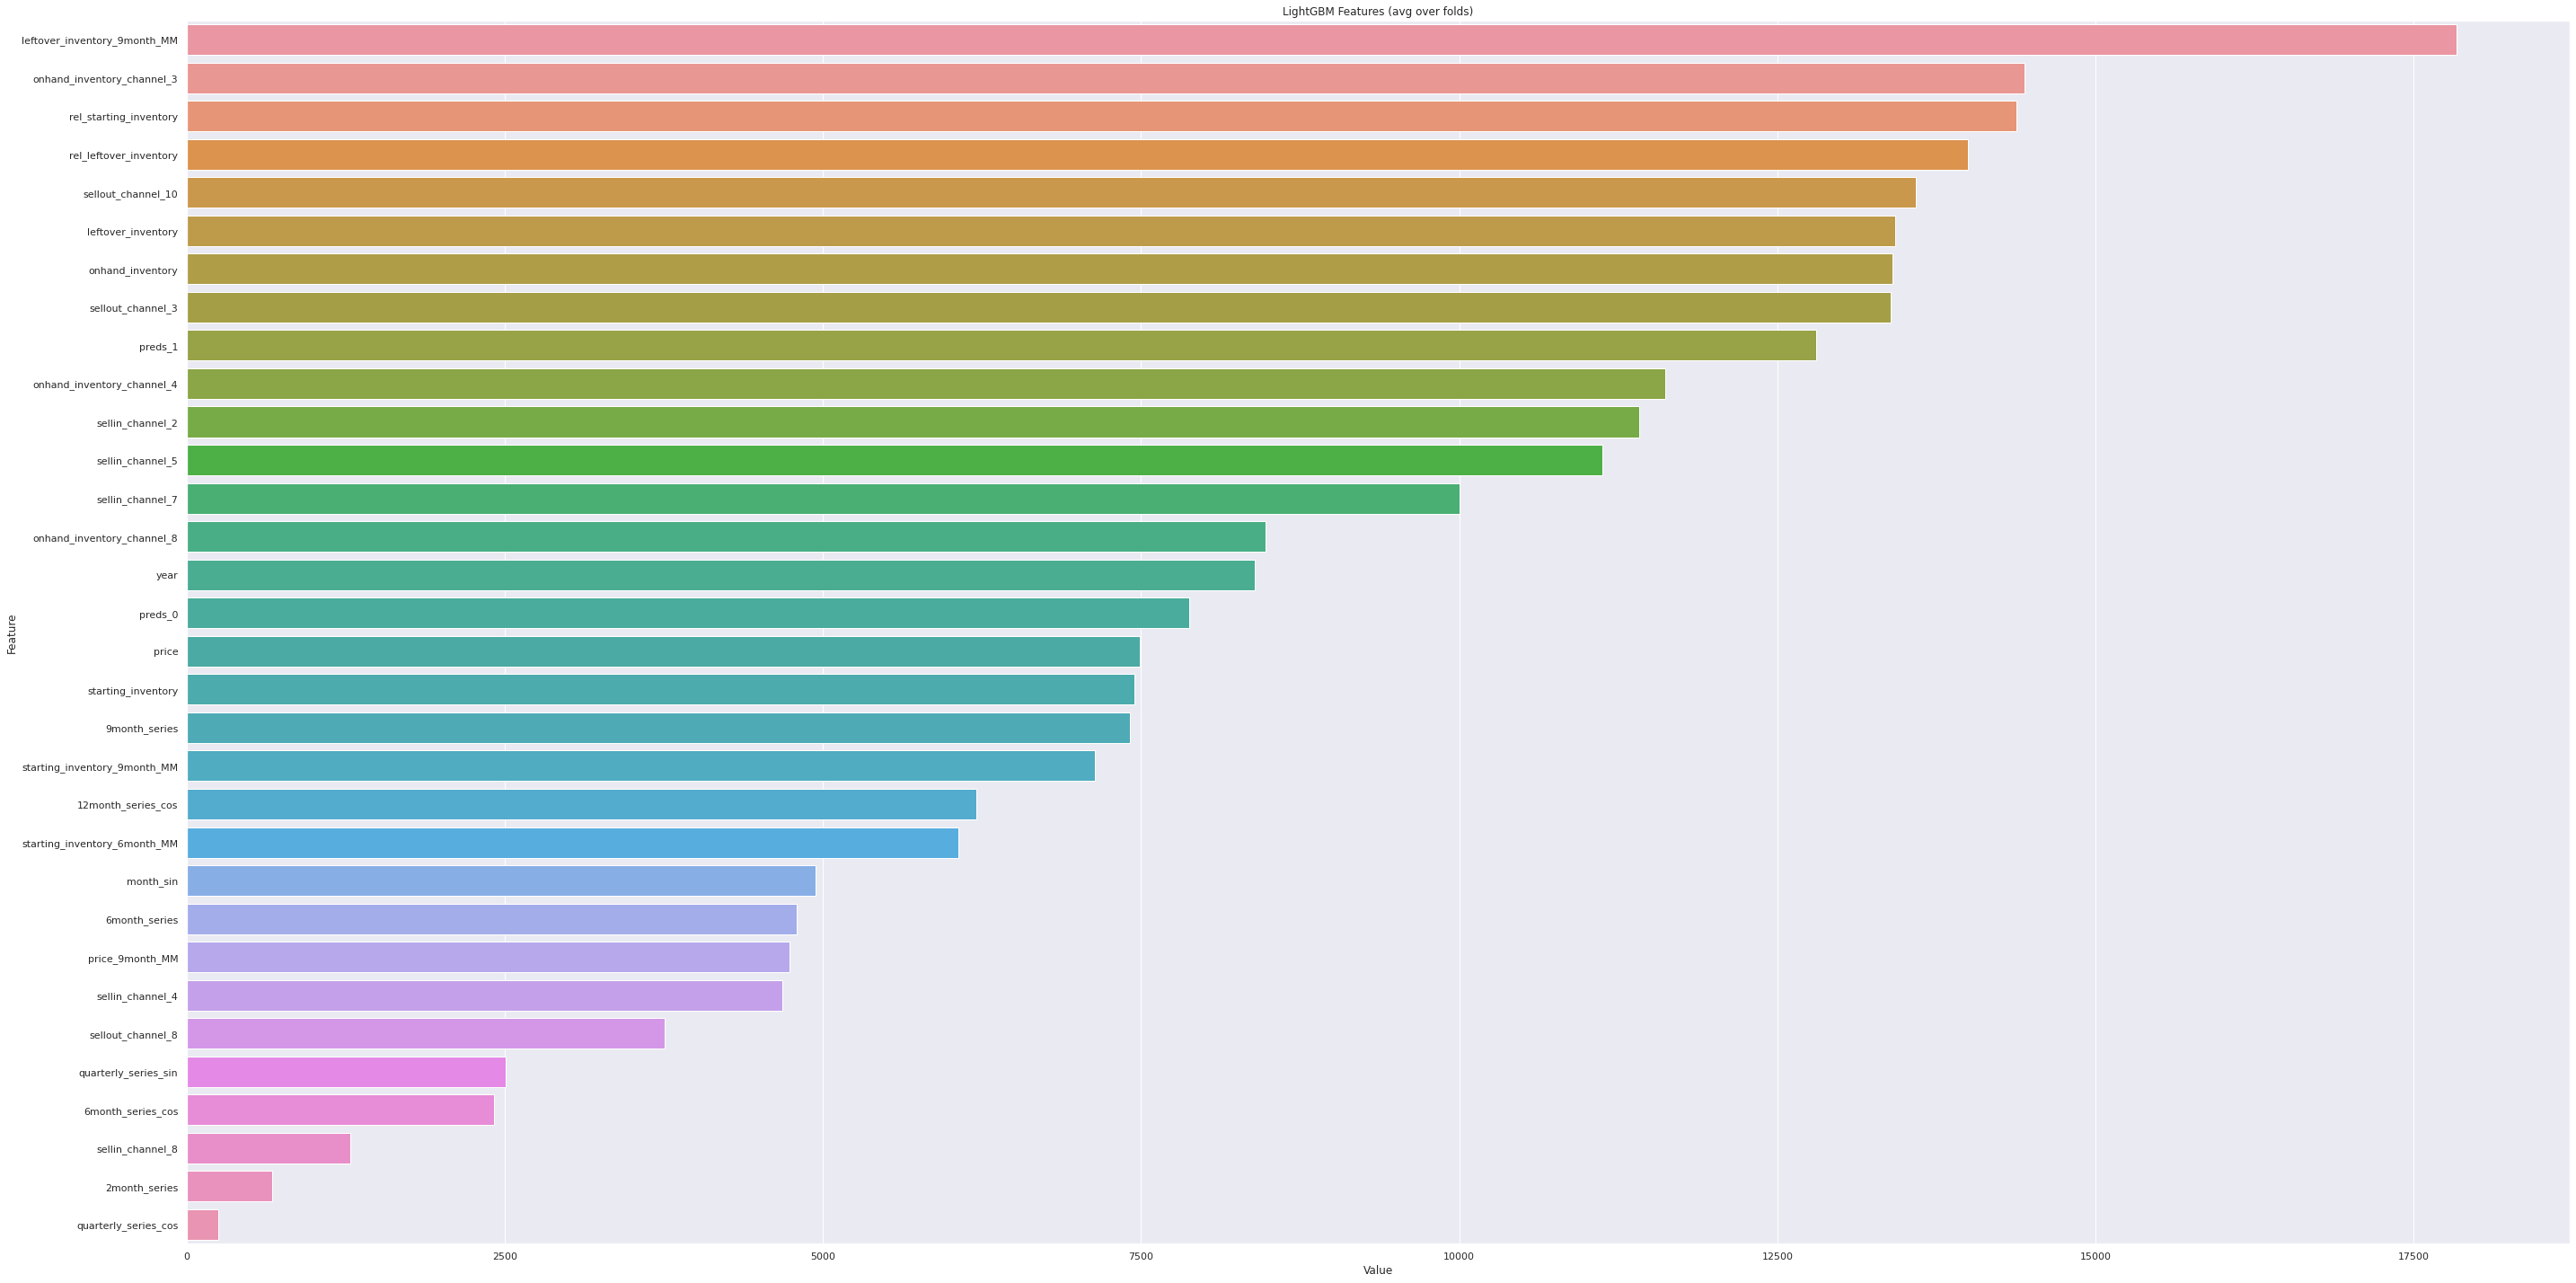

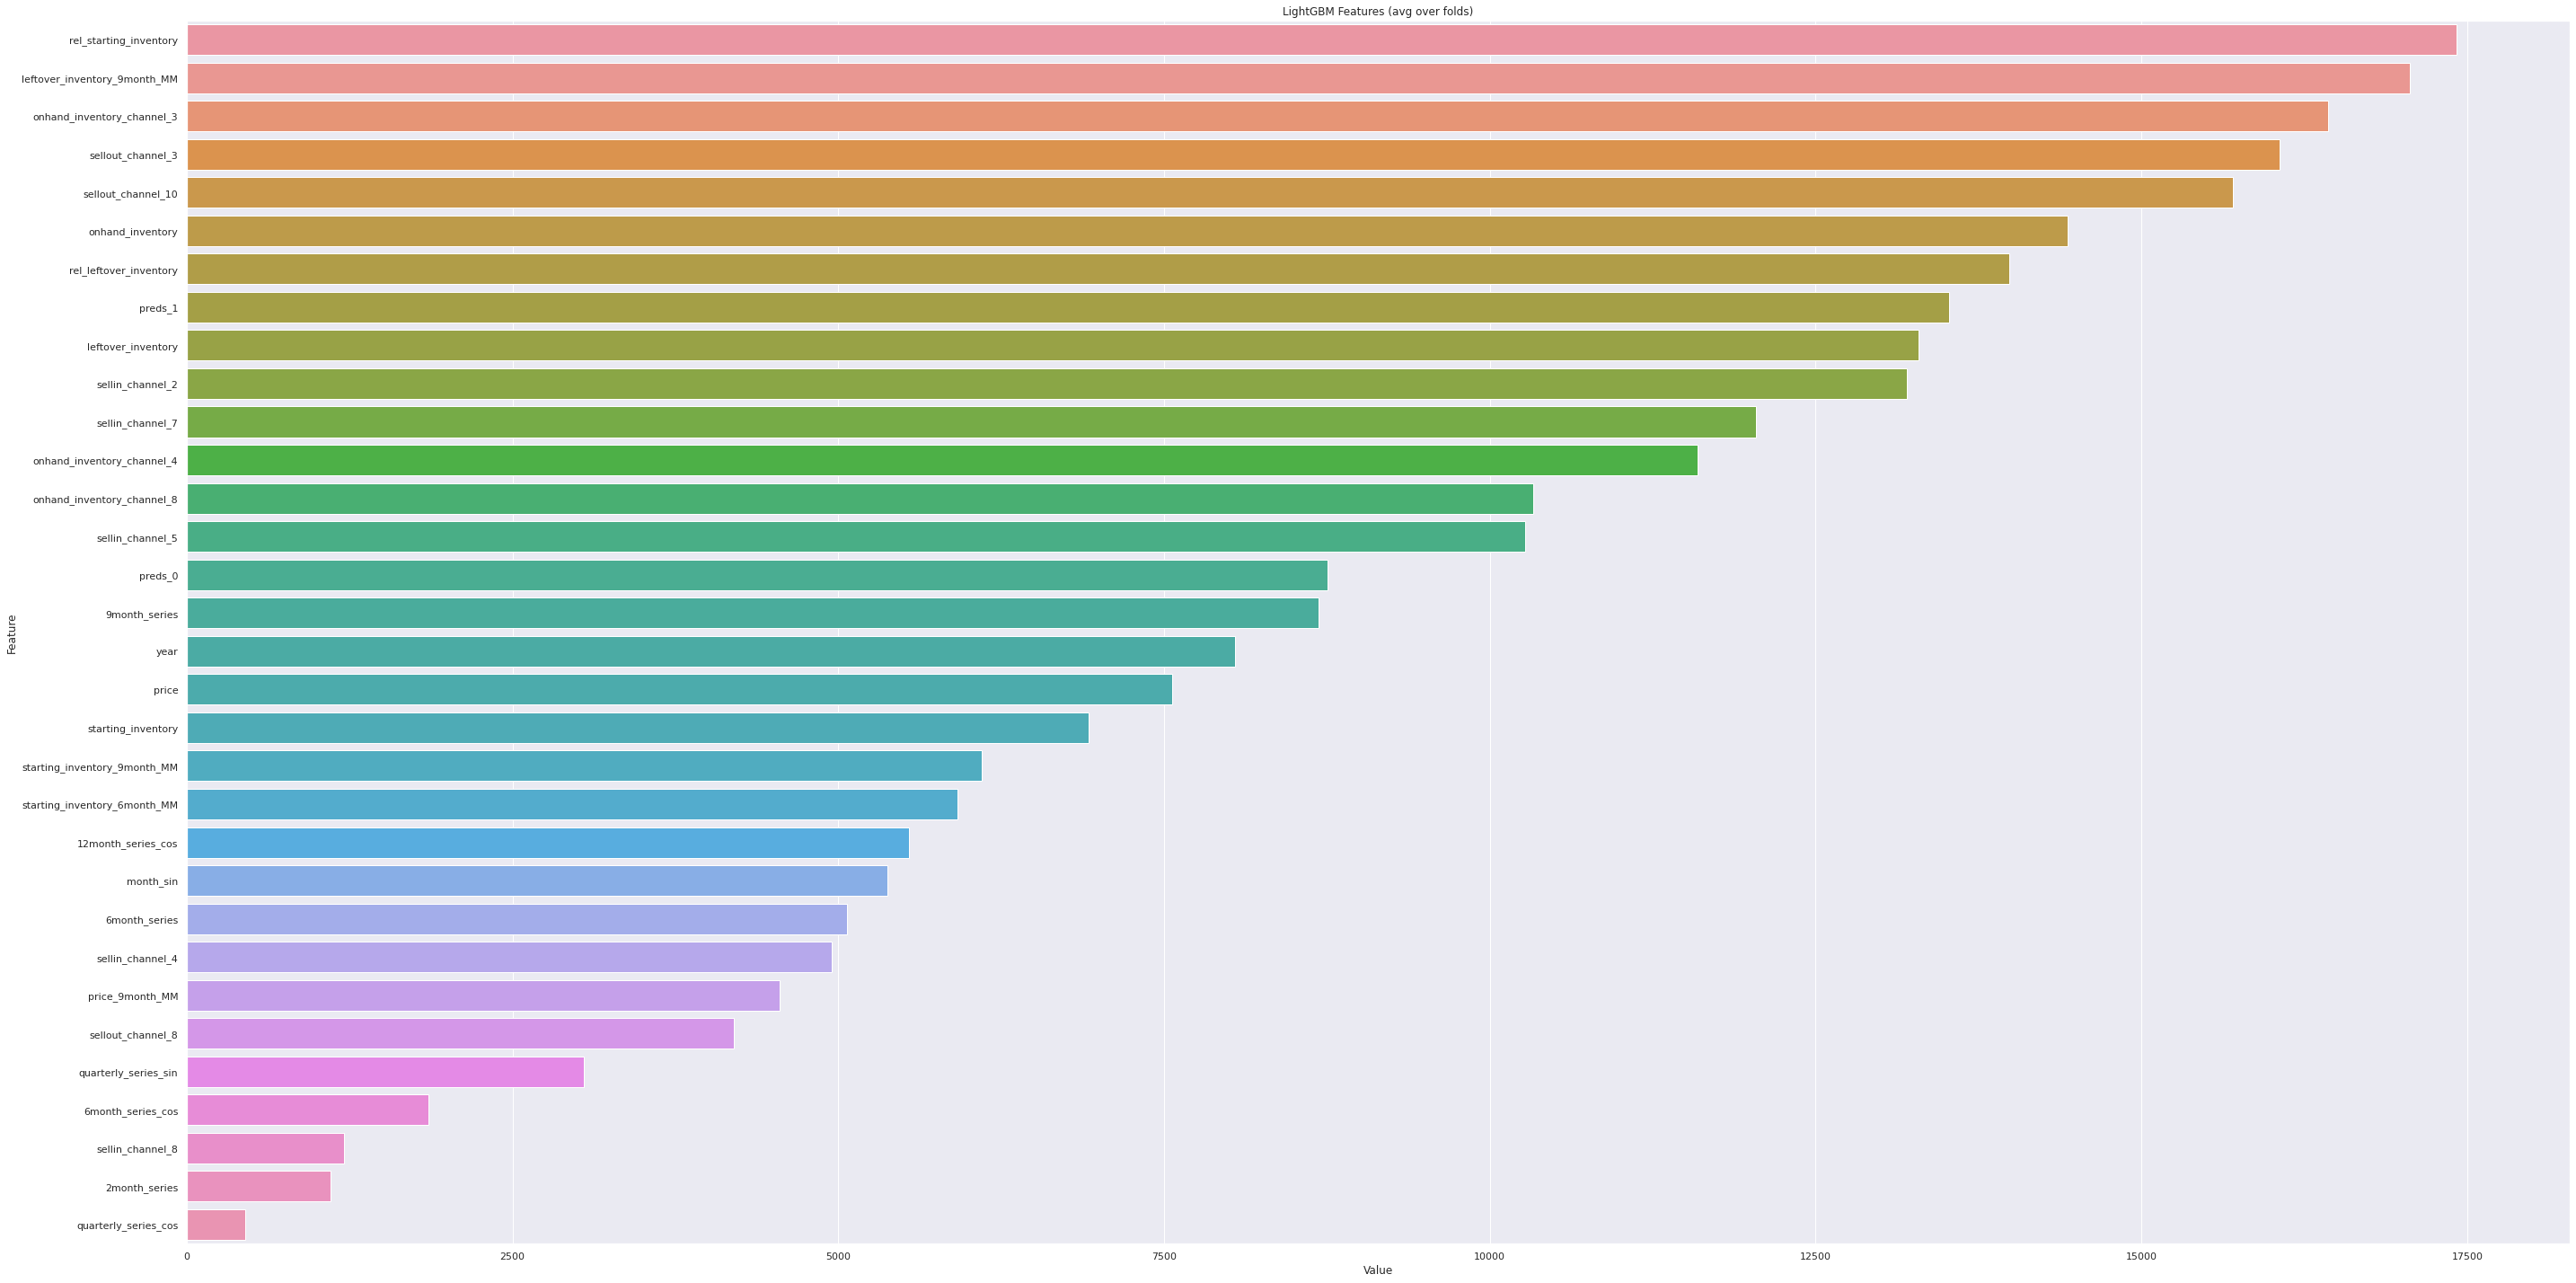

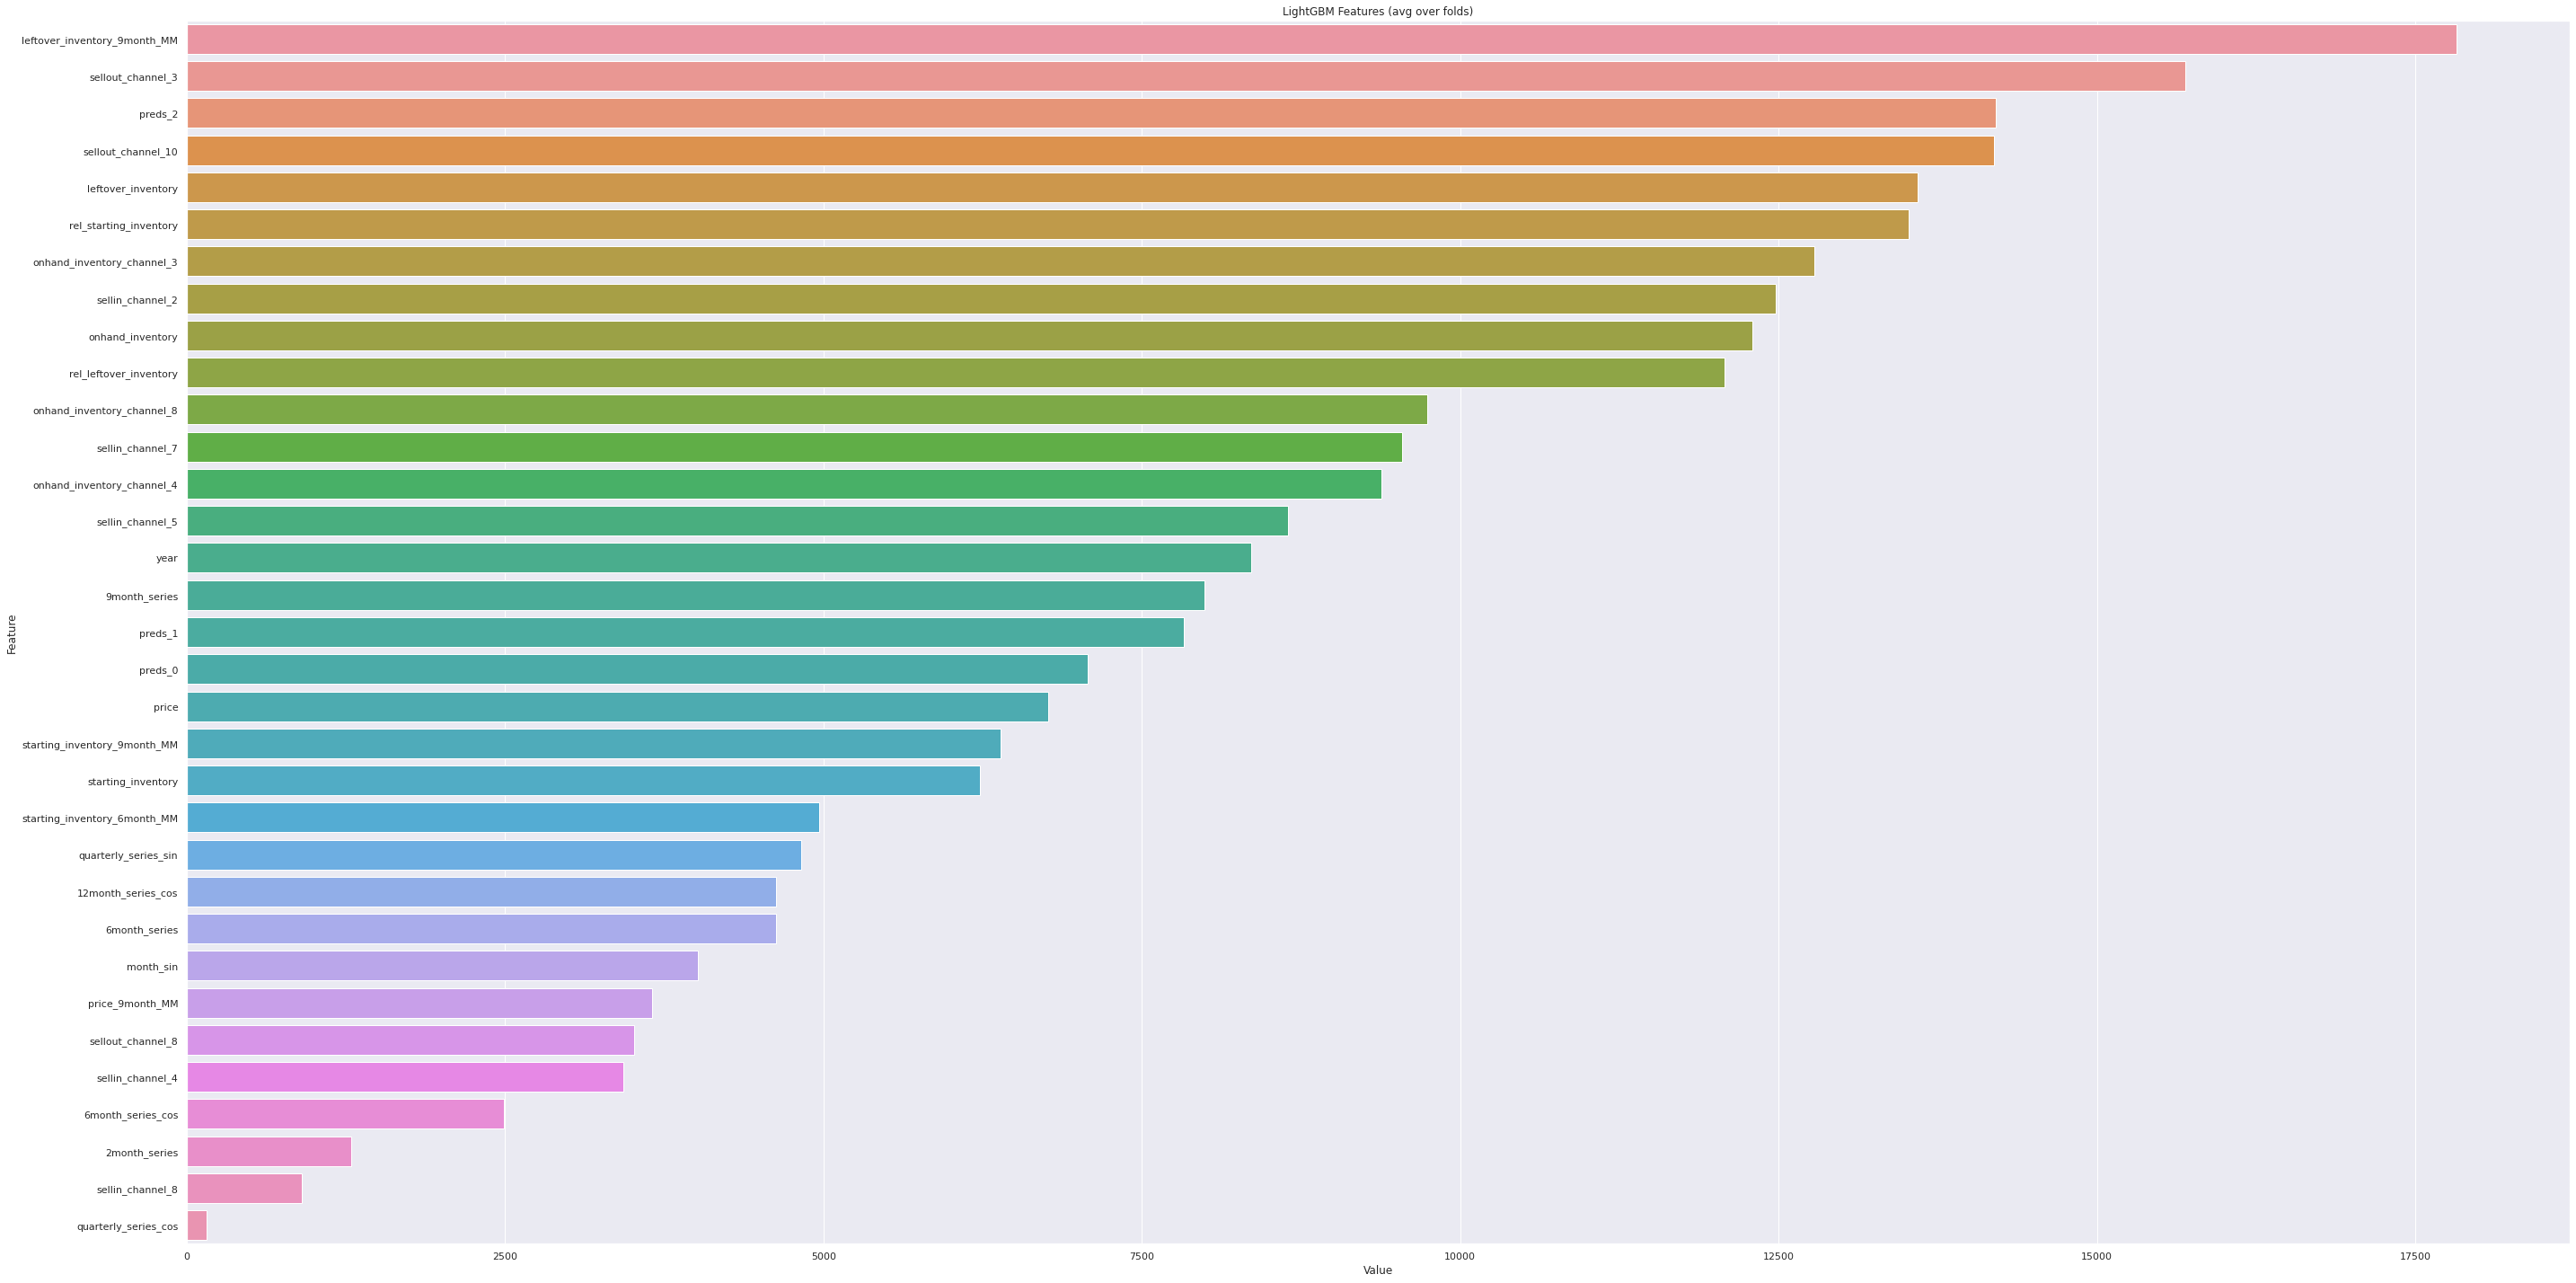

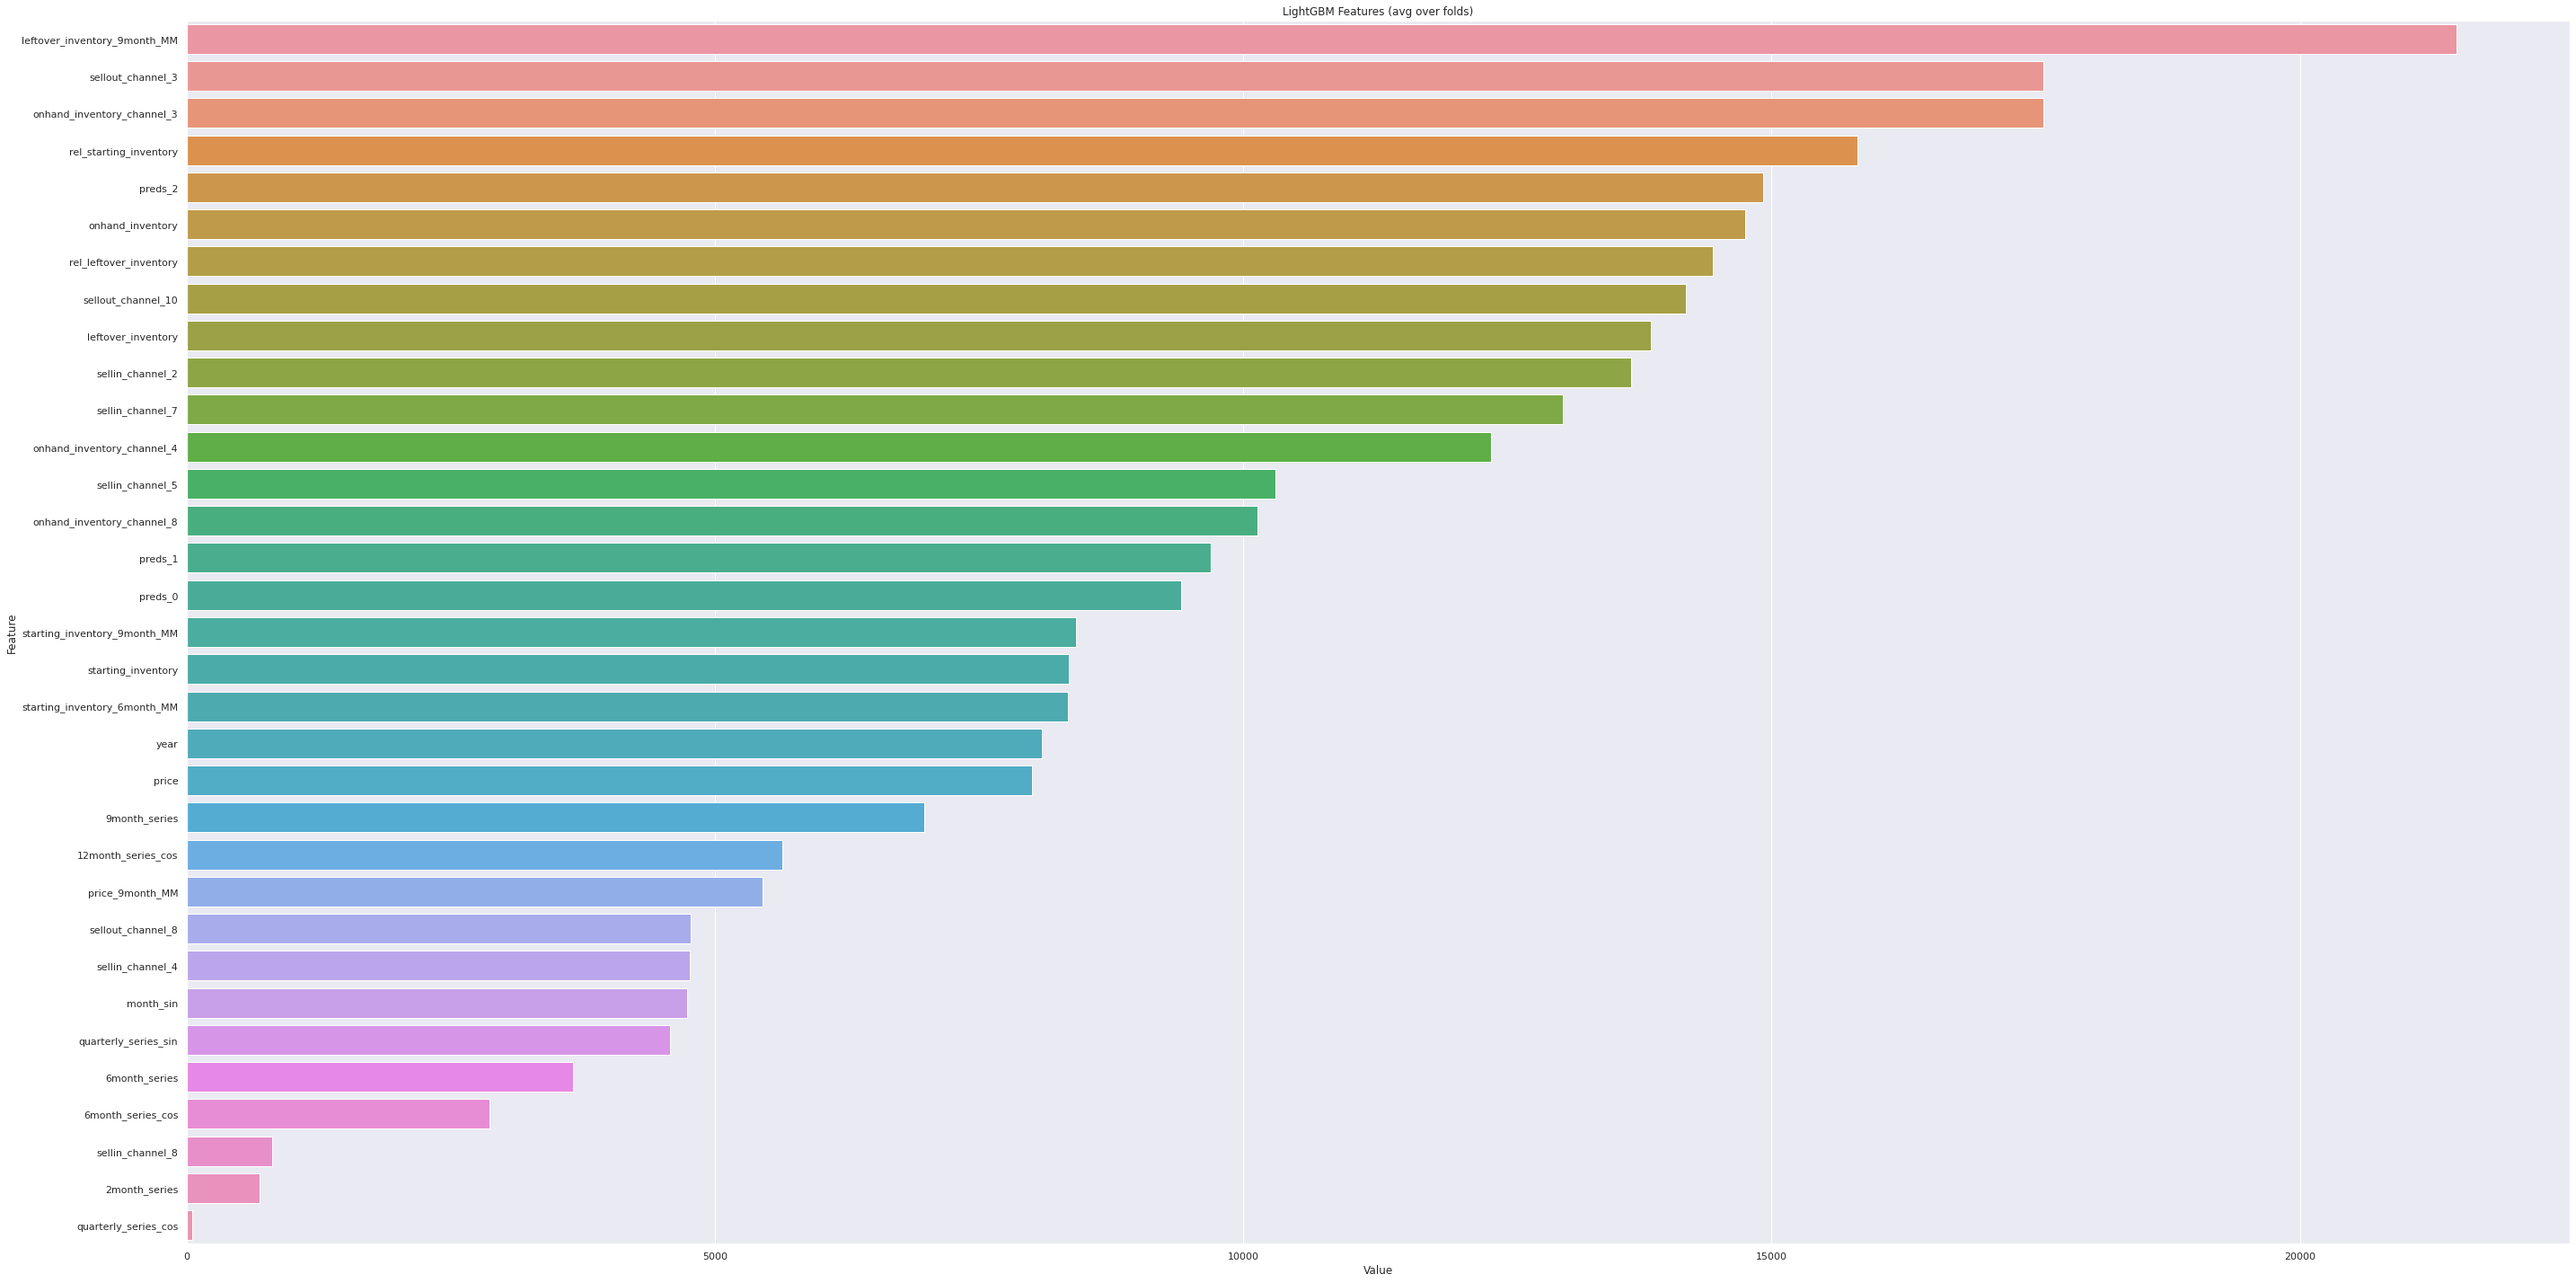

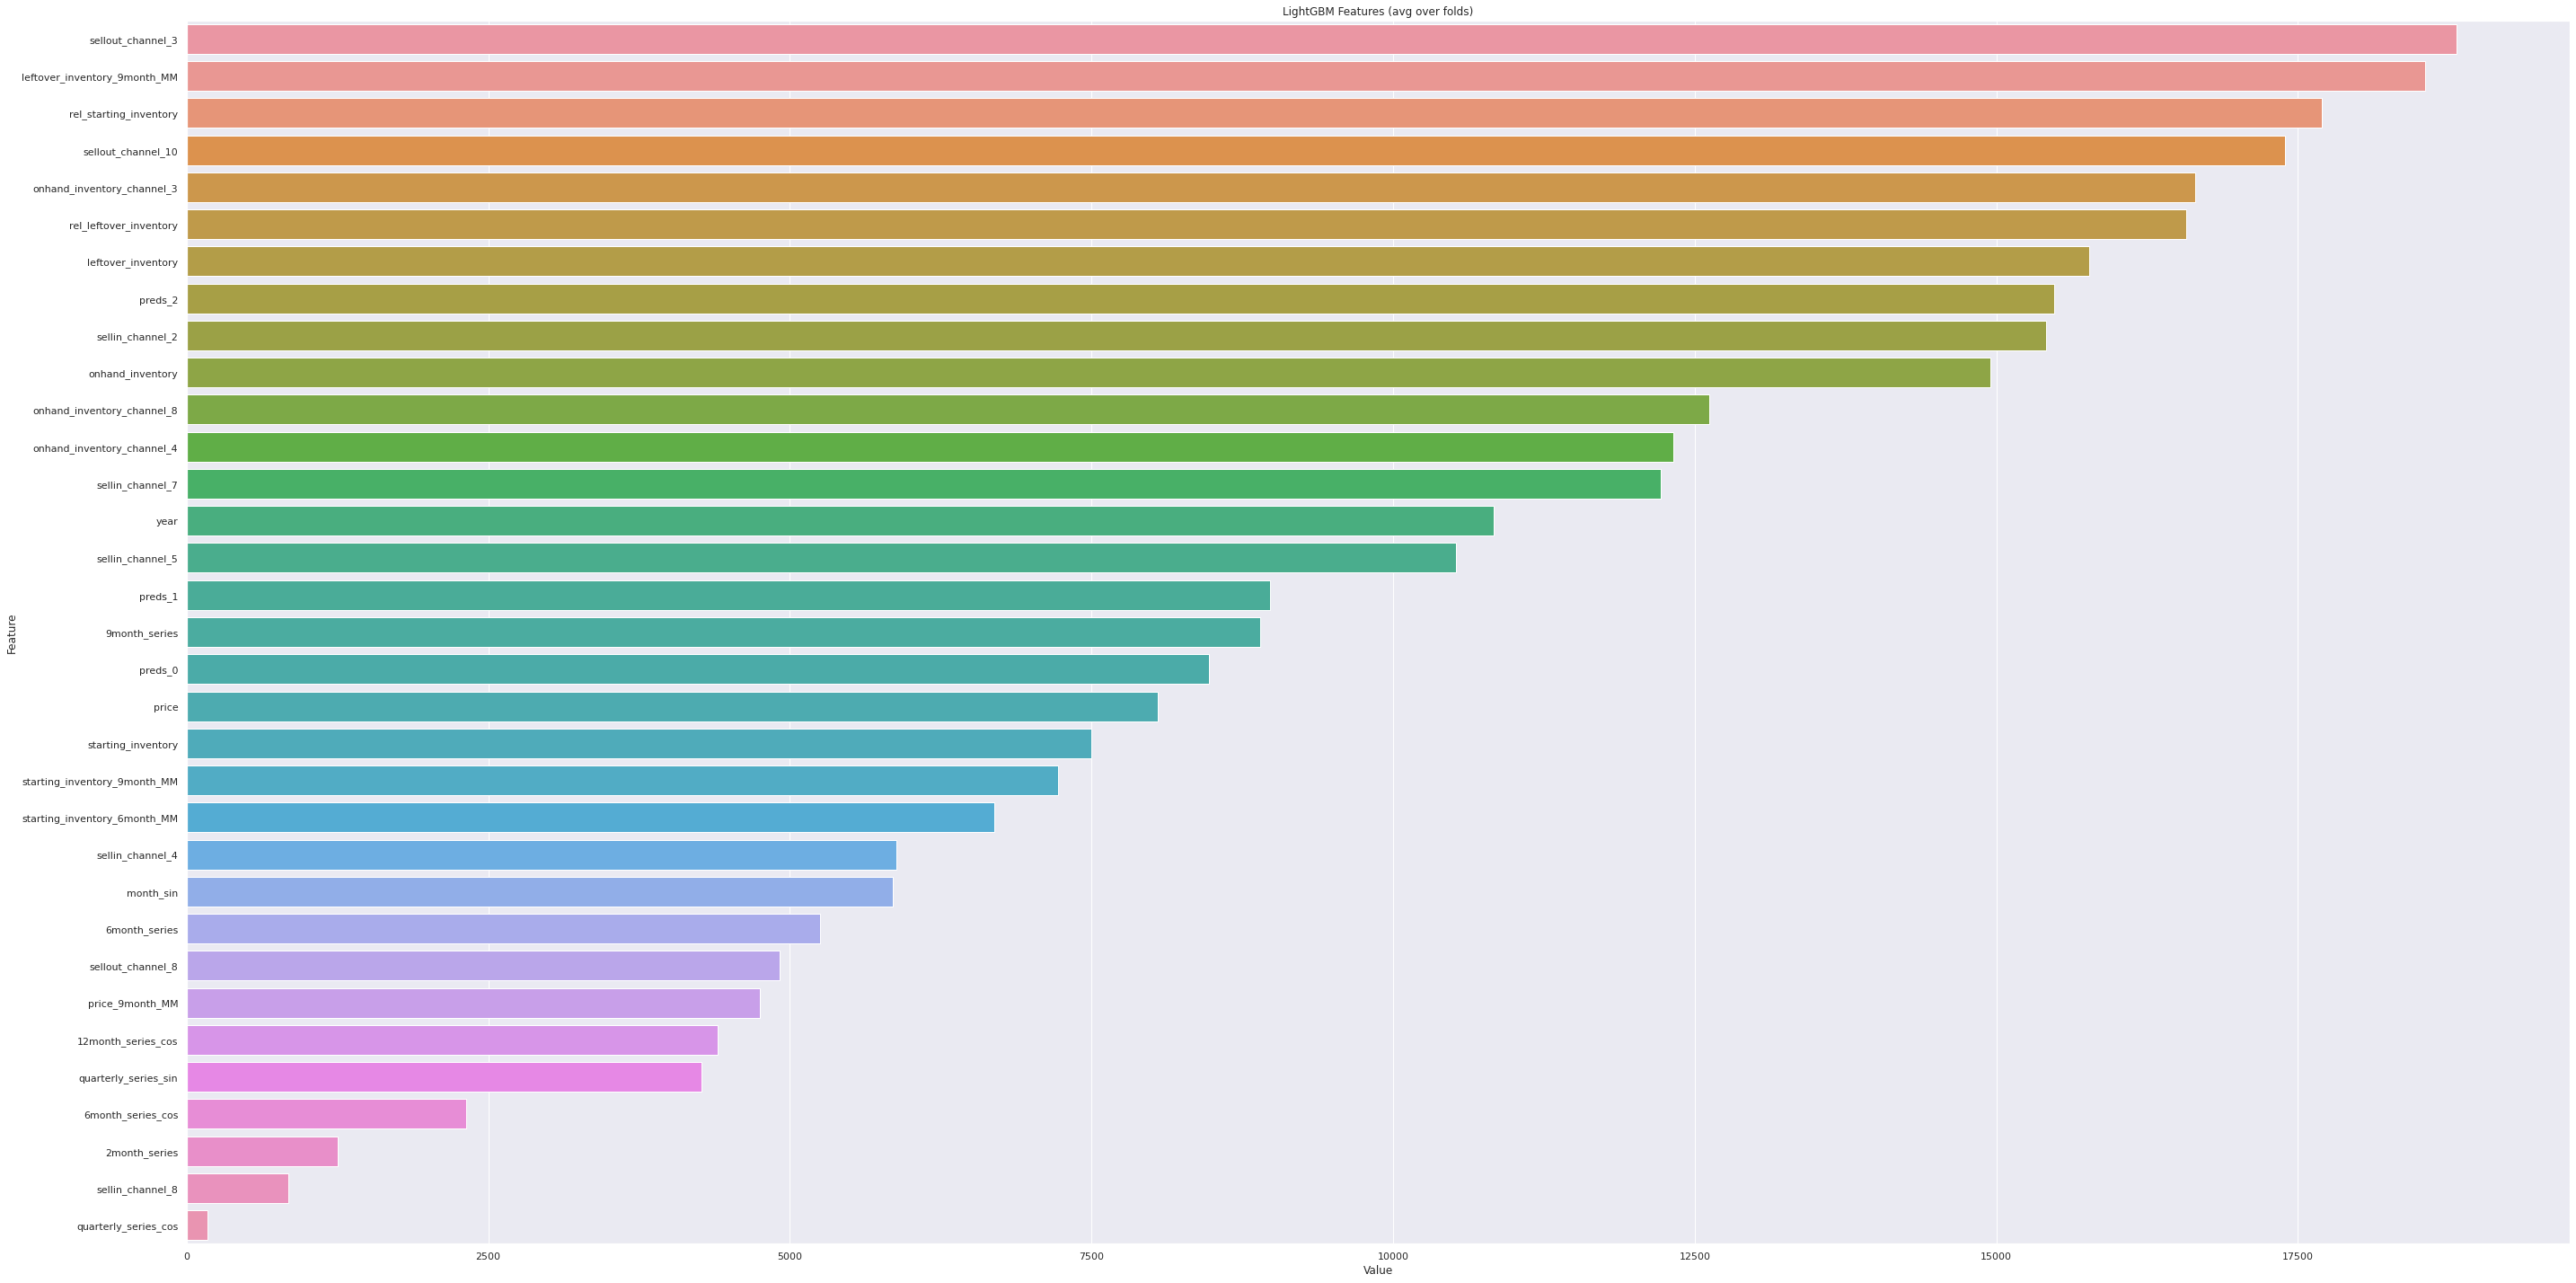

In [391]:
feature_importance = cv_feature_importance_plot(
    train_data.drop(columns=[f'preds_{i}' for i in range(N_STEPS)]), 
    folds, 
    lgb_cv_models,
    True,
    pca_cols=most_important_cols)

In [225]:
train_data.columns

Index(['sku_name', 'month', 'year', 'starting_inventory', 'sellin',
       'sellin_channel_1', 'sellin_channel_6', 'sellout', 'onhand_inventory',
       'leftover_inventory', 'sellout_channel_1', 'sellout_channel_3',
       'sellout_channel_4', 'sellout_channel_5', 'sellout_channel_6',
       'onhand_inventory_channel_1', 'onhand_inventory_channel_2',
       'onhand_inventory_channel_3', 'onhand_inventory_channel_4',
       'onhand_inventory_channel_5', 'onhand_inventory_channel_10', 'price',
       'target_0', 'target_1', 'target_2', 'target_3', '12month_series',
       '9month_series', '6month_series', 'quarterly_series', '2month_series',
       '12month_series_sin', '12month_series_cos', '9month_series_sin',
       '9month_series_cos', '6month_series_sin', '6month_series_cos',
       'quarterly_series_sin', 'quarterly_series_cos', '2month_series_sin',
       '2month_series_cos', 'month_sin', 'month_cos',
       'starting_inventory_6month_MM', 'starting_inventory_9month_MM',
       '

### Full Train

In [227]:

np.random.seed(SEED)
sku_encoder = LabelEncoder(train.sku_name.sample(frac=0.95).unique())

dates = sorted([(m, y) for y,m in train_df.groupby(['year', 'month']).groups.keys()][:-1], key=lambda d: (d[1], d[0]))
train_data = train_df.copy()
train_data = train_data.groupby('sku_name').progress_apply(prepare_data, dates=dates).reset_index(drop=True)

train_data['sku_coded'] = train_data['sku_name'].apply(sku_encoder)
train_data = train_data.groupby(['month','year']).progress_apply(clean_data, encoder=sku_encoder).reset_index(drop=True)

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [228]:

cols_1 = [c for c in train_data.columns if c not in ['sku_name','sku_coded']]
cols_2 = [c for c in train_data.columns if c not in ['month','year', 'sku_name', 'sku_coded']]

train_data[cols_1] = train_data.groupby('sku_name')[cols_1].transform(lambda x: x.fillna(x.median()))
train_data[cols_2] = train_data.groupby(['month','year'])[cols_2].transform(lambda x: x.fillna(x.median()))

In [229]:

x_train = train_data[[c for c in train_data.columns if 'target' not in c]].copy()
y_train = train_data[[c for c in train_data.columns if 'target' in c]].copy()

In [230]:
use_gpu = False

params = {
                'boosting_type': 'gbdt',
                'device_type': 'gpu' if use_gpu else 'cpu',
                #'gpu_use_dp': 'true',
                'n_jobs': -1,
                'learning_rate': 0.03,
                #'bagging_fraction': 0.85,
                #'bagging_freq': 10, 
                'colsample_bytree': 0.85,
                'colsample_bynode': 0.85,
                'min_data_per_leaf': 25,
                'max_bin':63,
                'num_leaves': 125,
                'lambda_l1': 0.5,
                'lambda_l2': 0.5,
                "metric": "mae",
#                 "min_delta":0.0003,
                'seed': SEED,
                'verbose':-1
              }  

models = train_models(params, x_train, y_train, False, num_rounds=[2500, 2500, 2800, 2200])

## Inference

In [1413]:
def add_missing_context(x, missing_sku):
    missing_df = pd.DataFrame(np.nan, index=range(len(missing_sku)), columns=x.columns)
    missing_df['sku_name'] = missing_sku
    missing_df['month'] = x['month'].iloc[0]    
    missing_df['year'] = x['year'].iloc[0]     
    
    return x.append(missing_df)

# def pad_test_context()

In [1414]:

test = pd.read_csv(f'{TEST_DIR}/Test.csv')
dates = sorted([(m, y) for y,m in test.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))

month,yr = dates[0]
test_dates = [(month-n,yr) if month>n else (12+month-n, yr-1) for n in range(1,LOOKBACK+1)]

test_context = train_df.copy()#[train_df[['month', 'year']].apply(tuple, axis=1).isin(test_dates)]

In [1415]:
# missing_sku = list(set(test.sku_name.unique()).difference(test_context.sku_name.unique()))
missing_sku = list(set(test.sku_name.unique()).difference(test_context[test_context[['month', 'year']].apply(tuple, axis=1).isin(test_dates)].sku_name.unique()))
test_context = test_context.groupby(['month','year']).apply(add_missing_context, missing_sku=missing_sku).reset_index(drop=True)
# test_context = test_context[test_context.sku_name.isin(test.sku_name.unique())]

In [1416]:
# dates = sorted([(m, y) for y,m in train_df.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))

# test_data = test_context.groupby('sku_name').progress_apply(prepare_data, dates=test_dates).reset_index(drop=True)
test_data = prepare_data(test_context, dates)

test_data['sku_coded'] = test_data['sku_name'].apply(sku_encoder)
test_data = test_data.groupby(['month','year']).progress_apply(clean_data, encoder=sku_encoder).reset_index(drop=True)

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [1417]:
# test_data = get_aggregates(test_data, feat_cols)

In [1418]:
# cyc_cols = [c for c in test_data.columns if 'seires' in c]+['month']
# test_data = cyclic_encode(test_data, cyc_cols)

In [1419]:
# channel_cols = [c for c in test_data.columns if any(f'_{i}' in c for i in range(1,11)) and c not in CAT+['sku_name','month','year','sku_coded'] and all(l not in c for l in ['target','sellin'])]
# agg_cols = [c for c in test_data.columns if all(f'_{i}' not in c for i in range(1,11)) and c not in CAT+['sku_name','month','year','sku_coded'] and all(l not in c for l in ['target', 'sellin', 'series', 'cos', 'sin'])]
# test_data = lag_shift(test_data, ['sku_name'], channel_cols+agg_cols, [6, 9, 12])

In [1420]:

cols_1 = [c for c in test_data.columns if c not in ['sku_name','sku_coded']]
cols_2 = [c for c in test_data.columns if c not in ['month','year','sku_name','sku_coded']]

test_data[cols_1] = test_data.groupby('sku_name')[cols_1].progress_transform(lambda x: x.fillna(x.median()))
test_data[cols_2] = test_data.groupby(['month','year'])[cols_2].progress_transform(lambda x: x.fillna(x.median()))

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [1421]:
test_data = test_data[test_data[['month', 'year']].apply(tuple, axis=1).isin(test_dates)]

In [1422]:
def base_model_predictions(data:pd.DataFrame,
                     cv=True,
                     models:list=None,
                     folds:int=None,
                     recursive=False,
                     base_model=True,
                     pca_cols=None):
    
    target_cols = [f'target_{i}' for i in range(N_STEPS)]
    channel_cols = [c for c in data.columns if any(f'channel_{i}' in c for i in range(1,11)) and c not in CAT+['sku_name','sku_coded']]
    
    features = data.copy().drop(columns=['sku_name','sku_coded']+target_cols)
    if pca_cols is not None:
        features = data[pca_cols].copy()
        
    if not base_model:
        features[[f'preds_{step}' for step in range(N_STEPS)]] = data[[f'target_{step}' for step in range(N_STEPS)]]
        
    data[target_cols] = 0
    if cv:
        assert folds is not None, 'specify number of folds used in CV training'
        for step in range(N_STEPS):
            for fold in range(folds):
                data[f'target_{step}'] += models[step][fold].predict(features)/folds
            if recursive:
                features[f'preds_{step}'] = data[f'target_{step}']
    else:
        for step in range(N_STEPS):
            data[f'target_{step}'] = models[step].predict(features)
    
    return data

In [1423]:
def meta_model_predictions(data: pd.DataFrame,
                          cv=True,
                          models: list=None,
                          folds: int=None,
                          pca_cols =None):
    
    feat_cols = [c for c in data.columns if 'lag' in c or c in ['sku_name','sku_coded','preds', 'time_step', 'month', 'year']]
    features = data[feat_cols].copy()
    
    if pca_cols is not None:
        features = data[pca_cols + ['sku_name','sku_coded','preds', 'time_step']].copy()
    
    data['Target'] = 0
    
    x_test = features.drop(columns=['sku_name','sku_coded'])
    # print(x_test)
    # x_test = sm.add_constant(x_test, has_constant='add')
    
    if cv:
        assert folds is not None, 'specify number of folds used in CV training'
        for fold in range(folds):
            data['Target'] += models[fold].predict(x_test)/folds
            
    else:
        data['Target'] = models.predict(x_test)
    
    return data

In [1424]:
pred_df = base_model_predictions(test_data, True, lgb_cv_models, folds, True, pca_cols=most_important_cols)

In [1425]:
# pred_df = make_predictions(pred_df, True, cat_cv_models, folds, True, pca_cols=most_important_cols)

In [1426]:
# pred_df = make_predictions(test_data, True, cat_cv_models, folds, True, False)

In [1427]:
# pred_df = make_predictions(test_data, False, models)

In [1428]:
if LOOKBACK>1:
    pred_df = pred_df.groupby(['sku_name','lookback_ix']).mean().reset_index()    

In [1429]:
pred_df = pred_df[pred_df.sku_name.isin(test.sku_name.unique())]

In [1430]:
m,y = test_dates[0]
pred_dates = [(m+n,yr) if m+n<=12 else (m+n-12, yr+1) for n in range(1,N_STEPS+1)]

In [1431]:
target_cols = [c for c in pred_df if 'target_' in c]
pred_arr = pred_df[target_cols].values.reshape(-1,1)

In [1432]:
# sub_df = pd.DataFrame(np.repeat(pred_df['sku_name'], N_STEPS), columns=['sku_name']).reset_index(drop=True)

In [1433]:
sub_df = pred_df.loc[pred_df.index.repeat(N_STEPS)][[c for c in train_cols if 'target' not in c]].reset_index(drop=True)


In [1434]:
sub_df['month'], sub_df['year'] = pd.DataFrame(pred_dates*int(len(sub_df)/N_STEPS)).loc[:, 0].values, pd.DataFrame(pred_dates*int(len(sub_df)/N_STEPS)).loc[:, 1].values

In [1435]:
sub_df['preds'] = pred_arr
sub_df['time_step'] = sub_df.groupby(['sku_name','month','year']).cumcount()
# sub_df = sub_df[[c for c in train_expanded.columns if 'target' not in c]]

In [1436]:

# sub_df = lag_shift(sub_df, ['sku_name'], ['preds'], [1,2])

In [1437]:
sub_df = meta_model_predictions(sub_df, True, meta_cv_models, folds)

In [1438]:
sub_df['Item_ID'] = sub_df['sku_name'].astype(str)+'_'+sub_df['month'].astype(str)+'_'+sub_df['year'].astype(str)

In [1439]:
# save_name = f'{OUTPUT_DIR}/fossil_lgbm_cat_{val_mae}.csv'
# sub_df[['Item_ID','Target']].to_csv(save_name, index=False)

In [1440]:
save_name = f'{OUTPUT_DIR}/fossil_lgbm_xgb_{meta_val_mae}.csv'
sub_df[['Item_ID','Target']].to_csv(save_name, index=False)

In [1441]:
meta_val_mae

122634.68656935293

# MISC

In [444]:
sub_df[['Item_ID','Target']]

,Item_ID,Target
0,ABEAHAMASHL_11_2021,513716.442996
1,ABEAHAMASHL_12_2021,160536.117997
2,ABEAHAMASHL_1_2022,178159.832517
3,ABEAHAMASHL_2_2022,170982.636531
4,ABEENNEARMAZZ_11_2021,520932.487725
...,...,...
1523,YOSHRENECARL_2_2022,181862.946611
1524,YOSHTLYNYOSHZZ_11_2021,521370.915257
1525,YOSHTLYNYOSHZZ_12_2021,159040.313122
1526,YOSHTLYNYOSHZZ_1_2022,174864.150718


In [310]:
sub_df[['Item_ID','Target']]

,Item_ID,Target
0,ABEAHAMASHL_9_2021,266238.820120
1,ABEAHAMASHL_10_2021,148237.503969
2,ABEAHAMASHL_11_2021,207749.355797
3,ABEAHAMASHL_12_2021,313049.667164
4,ABEENNEARMAZZ_9_2021,362956.755299
...,...,...
1523,YOSHRENECARL_12_2021,588771.273015
1524,YOSHTLYNYOSHZZ_9_2021,261233.904688
1525,YOSHTLYNYOSHZZ_10_2021,160888.735439
1526,YOSHTLYNYOSHZZ_11_2021,179631.276994


In [27]:

folds = 3
use_gpu = False

params = {
                'boosting_type': 'gbdt',
                'device_type': 'gpu' if use_gpu else 'cpu',
                #'gpu_use_dp': 'true',
                'n_jobs': -1,
                'learning_rate': 0.03,
                #'bagging_fraction': 0.85,
                #'bagging_freq': 10, 
                'colsample_bytree': 0.85,
                'colsample_bynode': 0.85,
                'min_data_per_leaf': 25,
                'max_bin':63,
                'num_leaves': 125,
                'lambda_l1': 0.5,
                'lambda_l2': 0.5,
                "metric": "mae",
#                 "min_delta":0.0003,
                'seed': SEED,
                'verbose':-1
              }  
cv_models = train_model(train_data, folds)

Training fold 1


Training model for timestep 1 forecasting
Training until validation scores don't improve for 5 rounds
[10]	training's l1: 221222	valid_1's l1: 209058
[20]	training's l1: 182855	valid_1's l1: 175264
[30]	training's l1: 155836	valid_1's l1: 152520
[40]	training's l1: 137280	valid_1's l1: 136662
[50]	training's l1: 124329	valid_1's l1: 126308
[60]	training's l1: 115079	valid_1's l1: 119014
[70]	training's l1: 108418	valid_1's l1: 113822
[80]	training's l1: 103695	valid_1's l1: 110294
[90]	training's l1: 99752.7	valid_1's l1: 107749
[100]	training's l1: 96664.6	valid_1's l1: 106250
[110]	training's l1: 94322	valid_1's l1: 105124
[120]	training's l1: 92198.1	valid_1's l1: 104314
[130]	training's l1: 90454.6	valid_1's l1: 103746
[140]	training's l1: 88989.5	valid_1's l1: 103590
[150]	training's l1: 87574.5	valid_1's l1: 103501
Early stopping, best iteration is:
[145]	training's l1: 88223.9	valid_1's l1: 103484


Training model for timestep 2 forecasting
Training until valid

In [28]:
val_mae = test_model(train_data, folds, cv_models)

Making fold 1 predictions


Making fold 2 predictions


Making fold 3 predictions


Average Val MAE: 170126.54224123203


In [94]:
def expand_func(x):
    # print(x)
    for i in range(1, N_STEPS):
        x.loc[i, 'target_0'] = x.reset_index(drop=True).loc[i, f'target_{i}'] 
    return x

In [112]:

stretched_df = pd.DataFrame(np.repeat(train_data.values, N_STEPS, axis=0), columns=train_data.columns)
stretched_df['target'] = stretched_df.groupby(['sku_name']).cumcount()//N_STEPS

In [113]:
stretched_df[stretched_df.sku_name=='ABEAHAMASHL']

,sku_name,starting_inventory,sellin,sellin_channel_1,sellin_channel_2,sellin_channel_3,sellin_channel_4,sellin_channel_5,sellin_channel_6,sellin_channel_7,...,onhand_inventory_channel_9,onhand_inventory_channel_10,price,month,year,target_0,target_1,target_2,target_3,target
0,ABEAHAMASHL,6844841.0,902583.0,542968.0,236029.0,34442.0,0.0,14182.0,5065.0,9117.0,...,229951.0,110417.0,145.0,1.0,2016.0,358602.0,1177106.0,968428.0,470032.0,0
1,ABEAHAMASHL,6844841.0,902583.0,542968.0,236029.0,34442.0,0.0,14182.0,5065.0,9117.0,...,229951.0,110417.0,145.0,1.0,2016.0,358602.0,1177106.0,968428.0,470032.0,0
2,ABEAHAMASHL,6844841.0,902583.0,542968.0,236029.0,34442.0,0.0,14182.0,5065.0,9117.0,...,229951.0,110417.0,145.0,1.0,2016.0,358602.0,1177106.0,968428.0,470032.0,0
3,ABEAHAMASHL,6844841.0,902583.0,542968.0,236029.0,34442.0,0.0,14182.0,5065.0,9117.0,...,229951.0,110417.0,145.0,1.0,2016.0,358602.0,1177106.0,968428.0,470032.0,0
3480,ABEAHAMASHL,1576228.0,650346.0,380888.0,150937.0,70910.0,2026.0,0.0,3039.0,21273.0,...,16208.0,81040.0,145.0,1.0,2017.0,416343.0,618943.0,285666.0,395070.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166931,ABEAHAMASHL,1040351.0,349485.0,257302.0,65845.0,11143.0,0.0,0.0,6078.0,0.0,...,0.0,65845.0,145.0,12.0,2018.0,95222.0,106365.0,138781.0,48624.0,55
169944,ABEAHAMASHL,379875.0,219821.0,142833.0,65845.0,0.0,0.0,0.0,6078.0,0.0,...,0.0,15195.0,149.0,12.0,2019.0,28364.0,12156.0,42546.0,7091.0,56
169945,ABEAHAMASHL,379875.0,219821.0,142833.0,65845.0,0.0,0.0,0.0,6078.0,0.0,...,0.0,15195.0,149.0,12.0,2019.0,28364.0,12156.0,42546.0,7091.0,56
169946,ABEAHAMASHL,379875.0,219821.0,142833.0,65845.0,0.0,0.0,0.0,6078.0,0.0,...,0.0,15195.0,149.0,12.0,2019.0,28364.0,12156.0,42546.0,7091.0,56


In [114]:
rep = stretched_df.groupby(['sku_name','month','year','target']).apply(expand_func).reset_index(drop=True)

In [116]:
rep[rep.sku_name=='ABEAHAMASHL']

,sku_name,starting_inventory,sellin,sellin_channel_1,sellin_channel_2,sellin_channel_3,sellin_channel_4,sellin_channel_5,sellin_channel_6,sellin_channel_7,...,onhand_inventory_channel_9,onhand_inventory_channel_10,price,month,year,target_0,target_1,target_2,target_3,target
0,ABEAHAMASHL,6844841.0,902583.0,542968.0,236029.0,34442.0,0.0,14182.0,5065.0,9117.0,...,229951.0,110417.0,145.0,1.0,2016.0,358602.0,1177106.0,968428.0,470032.0,0.0
1,ABEAHAMASHL,6844841.0,902583.0,542968.0,236029.0,34442.0,0.0,14182.0,5065.0,9117.0,...,229951.0,110417.0,145.0,1.0,2016.0,1177106.0,1177106.0,968428.0,470032.0,0.0
2,ABEAHAMASHL,6844841.0,902583.0,542968.0,236029.0,34442.0,0.0,14182.0,5065.0,9117.0,...,229951.0,110417.0,145.0,1.0,2016.0,968428.0,1177106.0,968428.0,470032.0,0.0
3,ABEAHAMASHL,6844841.0,902583.0,542968.0,236029.0,34442.0,0.0,14182.0,5065.0,9117.0,...,229951.0,110417.0,145.0,1.0,2016.0,470032.0,1177106.0,968428.0,470032.0,0.0
4,ABEAHAMASHL,1576228.0,650346.0,380888.0,150937.0,70910.0,2026.0,0.0,3039.0,21273.0,...,16208.0,81040.0,145.0,1.0,2017.0,416343.0,618943.0,285666.0,395070.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,ABEAHAMASHL,1040351.0,349485.0,257302.0,65845.0,11143.0,0.0,0.0,6078.0,0.0,...,0.0,65845.0,145.0,12.0,2018.0,95222.0,106365.0,138781.0,48624.0,55.0
389,ABEAHAMASHL,379875.0,219821.0,142833.0,65845.0,0.0,0.0,0.0,6078.0,0.0,...,0.0,15195.0,149.0,12.0,2019.0,28364.0,12156.0,42546.0,7091.0,56.0
390,ABEAHAMASHL,379875.0,219821.0,142833.0,65845.0,0.0,0.0,0.0,6078.0,0.0,...,0.0,15195.0,149.0,12.0,2019.0,28364.0,12156.0,42546.0,7091.0,56.0
391,ABEAHAMASHL,379875.0,219821.0,142833.0,65845.0,0.0,0.0,0.0,6078.0,0.0,...,0.0,15195.0,149.0,12.0,2019.0,28364.0,12156.0,42546.0,7091.0,56.0


In [ ]:

folds = len(train_data)
use_gpu = False

params = {
                'boosting_type': 'gbdt',
                'device_type': 'gpu' if use_gpu else 'cpu',
                #'gpu_use_dp': 'true',
                'n_jobs': -1,
                'learning_rate': 0.03,
                #'bagging_fraction': 0.85,
                #'bagging_freq': 10, 
                'colsample_bytree': 0.85,
                'colsample_bynode': 0.85,
                'min_data_per_leaf': 25,
                'max_bin':63,
                'num_leaves': 125,
                'lambda_l1': 0.5,
                'lambda_l2': 0.5,
                "metric": "mae",
#                 "min_delta":0.0003,
                'seed': SEED,
                'verbose':-1
              }  
cv_models = train_model(train_data, val_data, folds)

Training fold 1


Training model for timestep 1 forecasting
Training until validation scores don't improve for 5 rounds
[50]	training's l1: 74825.6	valid_1's l1: 60646.2
[100]	training's l1: 68342.8	valid_1's l1: 58537
Early stopping, best iteration is:
[122]	training's l1: 67025.4	valid_1's l1: 58412.8


Training model for timestep 2 forecasting
Training until validation scores don't improve for 5 rounds
[50]	training's l1: 72010.7	valid_1's l1: 61319.1
[100]	training's l1: 65845.2	valid_1's l1: 58768.8
Early stopping, best iteration is:
[112]	training's l1: 65032.9	valid_1's l1: 58709.4


Training model for timestep 3 forecasting
Training until validation scores don't improve for 5 rounds
[50]	training's l1: 70703.1	valid_1's l1: 54269.7
[100]	training's l1: 61761	valid_1's l1: 52025.9
Early stopping, best iteration is:
[106]	training's l1: 61261.6	valid_1's l1: 52022.4


Training model for timestep 4 forecasting
Training until validation scores don't improve for 5 rounds
[50]	traini

In [ ]:
val_mae = test_model(train_data, val_data, folds, cv_models)

Making fold 1 predictions
valid MAE 273330.1023	Elapsed 0.01 mins
--------------------------------------------------


Making fold 2 predictions
valid MAE 208414.7877	Elapsed 0.01 mins
--------------------------------------------------


Making fold 3 predictions
valid MAE 148976.9905	Elapsed 0.01 mins
--------------------------------------------------


Average Val MAE: 210240.6268305067


In [139]:

test = pd.read_csv(f'{TEST_DIR}/Test.csv')
test['sku_coded'] = test.sku_name.apply(sku_encoder)

test['idx'] = SEED
test = test.groupby('sku_name').apply(lambda x: func(x, x.name)).reset_index(drop=True)

dates = sorted([(m, y) for y,m in test.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))

month,yr = dates[0]
test_dates = [(month-n,yr) if month>n else (12+month-n, yr-1) for n in range(1,LOOKBACK+1)]

In [248]:
test_context = train_df[train_df[['month','year']].apply(tuple, axis=1).isin(test_dates)].reset_index(drop=True)
test_context['sku_name'] = test_context['sku_name'].apply(sku_encoder)
test_context = test_context.groupby(['year', 'month']).apply(pad_sku_sequence, encoder=sku_encoder).reset_index(drop=True)
x_test = test_context.sort_values(by=['year','month','sku_name']).reset_index(drop=True)

In [249]:
preds = np.concatenate(multi_step_test(x_test, cv_models[folds-1])).reshape(-1, N_STEPS)
pred_df = pd.DataFrame(np.repeat(test.values, LOOKBACK, axis=0), columns=test.columns)
pred_df['sellin'] = preds[pred_df.sku_coded.astype(int).values, pred_df.idx.astype(int).values]
pred_df = pred_df.groupby(['sku_name','month','year']).mean().reset_index()

[LightGBM] [Fatal] The number of features in data (8) is not the same as it was in training data (12).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.


LightGBMError: The number of features in data (8) is not the same as it was in training data (12).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

In [ ]:
sub = make_submission(pred_df, dates)

In [225]:
save_name = f'{OUTPUT_DIR}/fossil_lgbm_{val_mae}.csv'
sub.to_csv(save_name, index=False)

In [ ]:
train_data[0][0][0]

,sku_name,starting_inventory,sellin,sellin_channel_1,sellin_channel_2,sellin_channel_3,sellin_channel_4,sellin_channel_5,sellin_channel_6,sellin_channel_7,...,onhand_inventory_channel_8,onhand_inventory_channel_9,onhand_inventory_channel_10,price,month,year,y_pred_1,y_pred_2,y_pred_3,y_pred_4
0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,...,0.00,0.0,0.0,0.0,1.0,2016.0,NaN,NaN,NaN,NaN
1,1,0.0,1782880.0,1258146.00,195509.0,68884.0,0.0,0.00,31403.0,17221.0,...,8104.00,614891.0,236029.0,125.0,1.0,2016.0,NaN,NaN,NaN,NaN
2,2,2041195.0,1041364.0,891440.00,20260.0,0.0,0.0,50650.00,4052.0,6078.0,...,0.00,379875.0,162080.0,95.0,1.0,2016.0,NaN,NaN,NaN,NaN
3,3,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,...,0.00,0.0,0.0,0.0,1.0,2016.0,NaN,NaN,NaN,NaN
4,4,5502616.0,2478811.0,2050312.00,159041.0,61793.0,4052.0,1013.00,15195.0,0.0,...,0.00,20260.0,110417.0,145.0,1.0,2016.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3837,3837,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,...,0.00,0.0,0.0,0.0,1.0,2016.0,NaN,NaN,NaN,NaN
3838,3838,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,...,0.00,0.0,0.0,0.0,1.0,2016.0,NaN,NaN,NaN,NaN
3839,3839,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,...,0.00,0.0,0.0,0.0,1.0,2016.0,NaN,NaN,NaN,NaN
3840,3840,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,...,0.00,0.0,0.0,0.0,1.0,2016.0,NaN,NaN,NaN,NaN


In [ ]:
sub

,Item_ID,Target
0,YOSHTLYNYOSHZZ_11_2021,57035.260394
1,YOSHTLYNYOSHZZ_12_2021,57035.260394
2,YOSHTLYNYOSHZZ_1_2022,57035.260394
3,YOSHTLYNYOSHZZ_2_2022,57035.260394
4,YOSHRENECARL_11_2021,57035.260394
...,...,...
1523,ABEENNEARMAZZ_2_2022,57035.260394
1524,ABEAHAMASHL_11_2021,57035.260394
1525,ABEAHAMASHL_12_2021,57035.260394
1526,ABEAHAMASHL_1_2022,65605.281441


In [ ]:
sub

,Item_ID,Target
0,YOSHTLYNYOSHZZ_11_2021,30149.691267
1,YOSHTLYNYOSHZZ_12_2021,30149.691267
2,YOSHTLYNYOSHZZ_1_2022,30149.691267
3,YOSHTLYNYOSHZZ_2_2022,30149.691267
4,YOSHRENECARL_11_2021,34624.701924
...,...,...
1523,ABEENNEARMAZZ_2_2022,198208.985307
1524,ABEAHAMASHL_11_2021,33511.029644
1525,ABEAHAMASHL_12_2021,34624.701924
1526,ABEAHAMASHL_1_2022,745801.630574


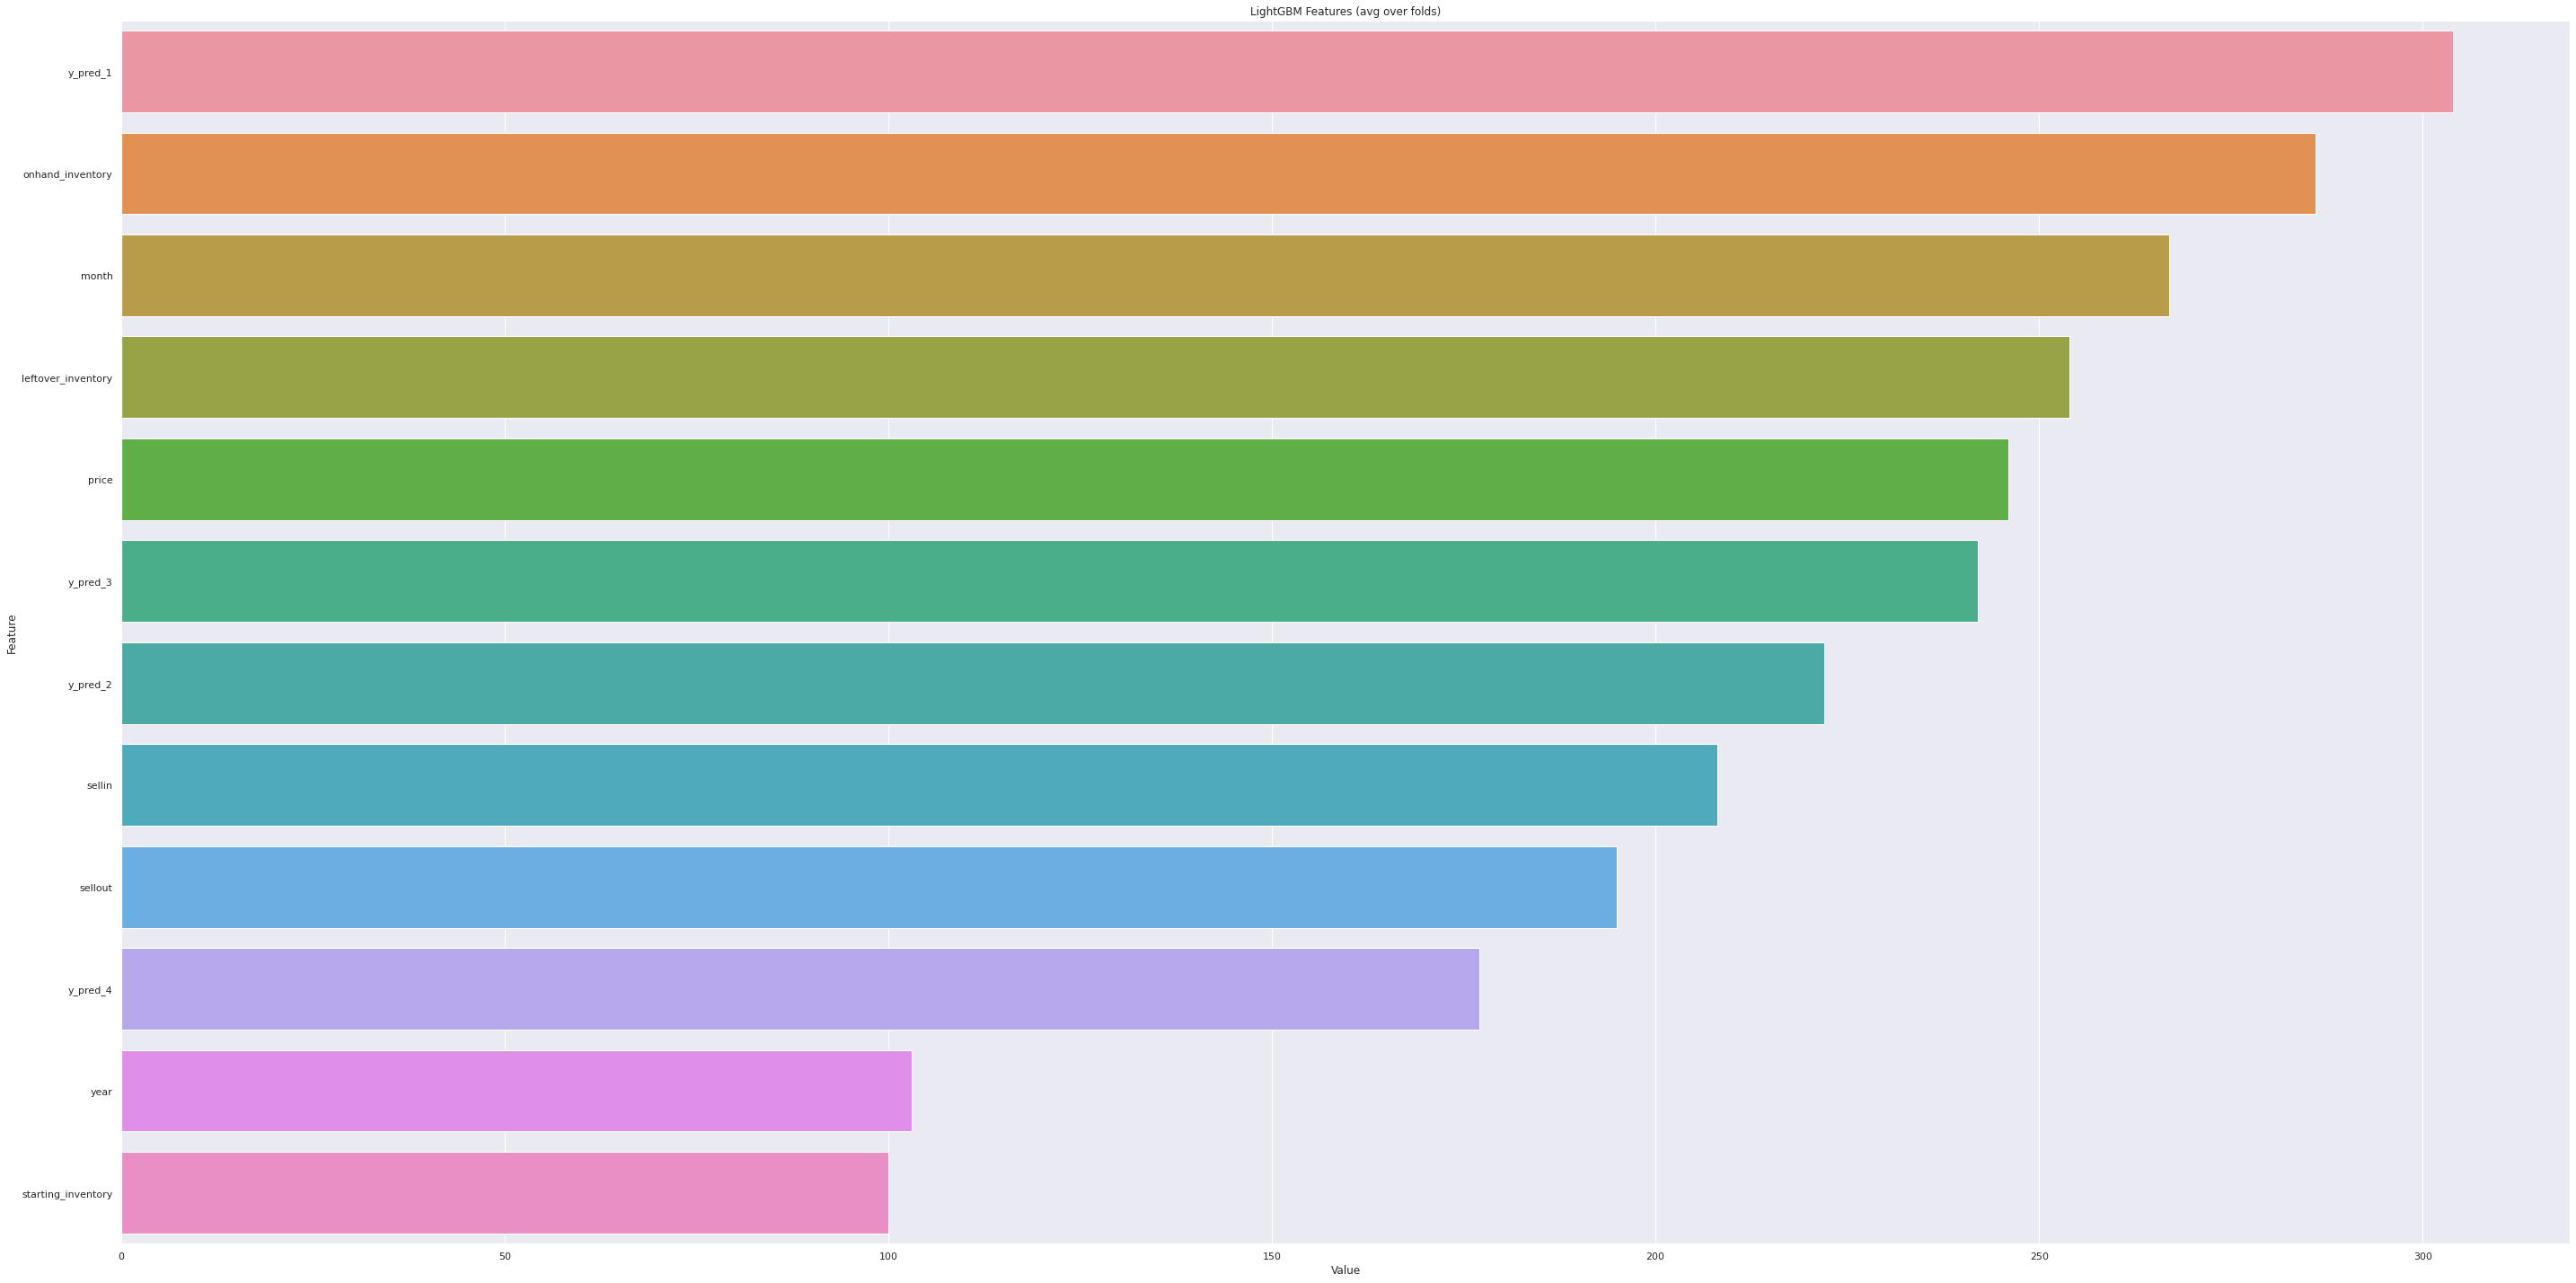

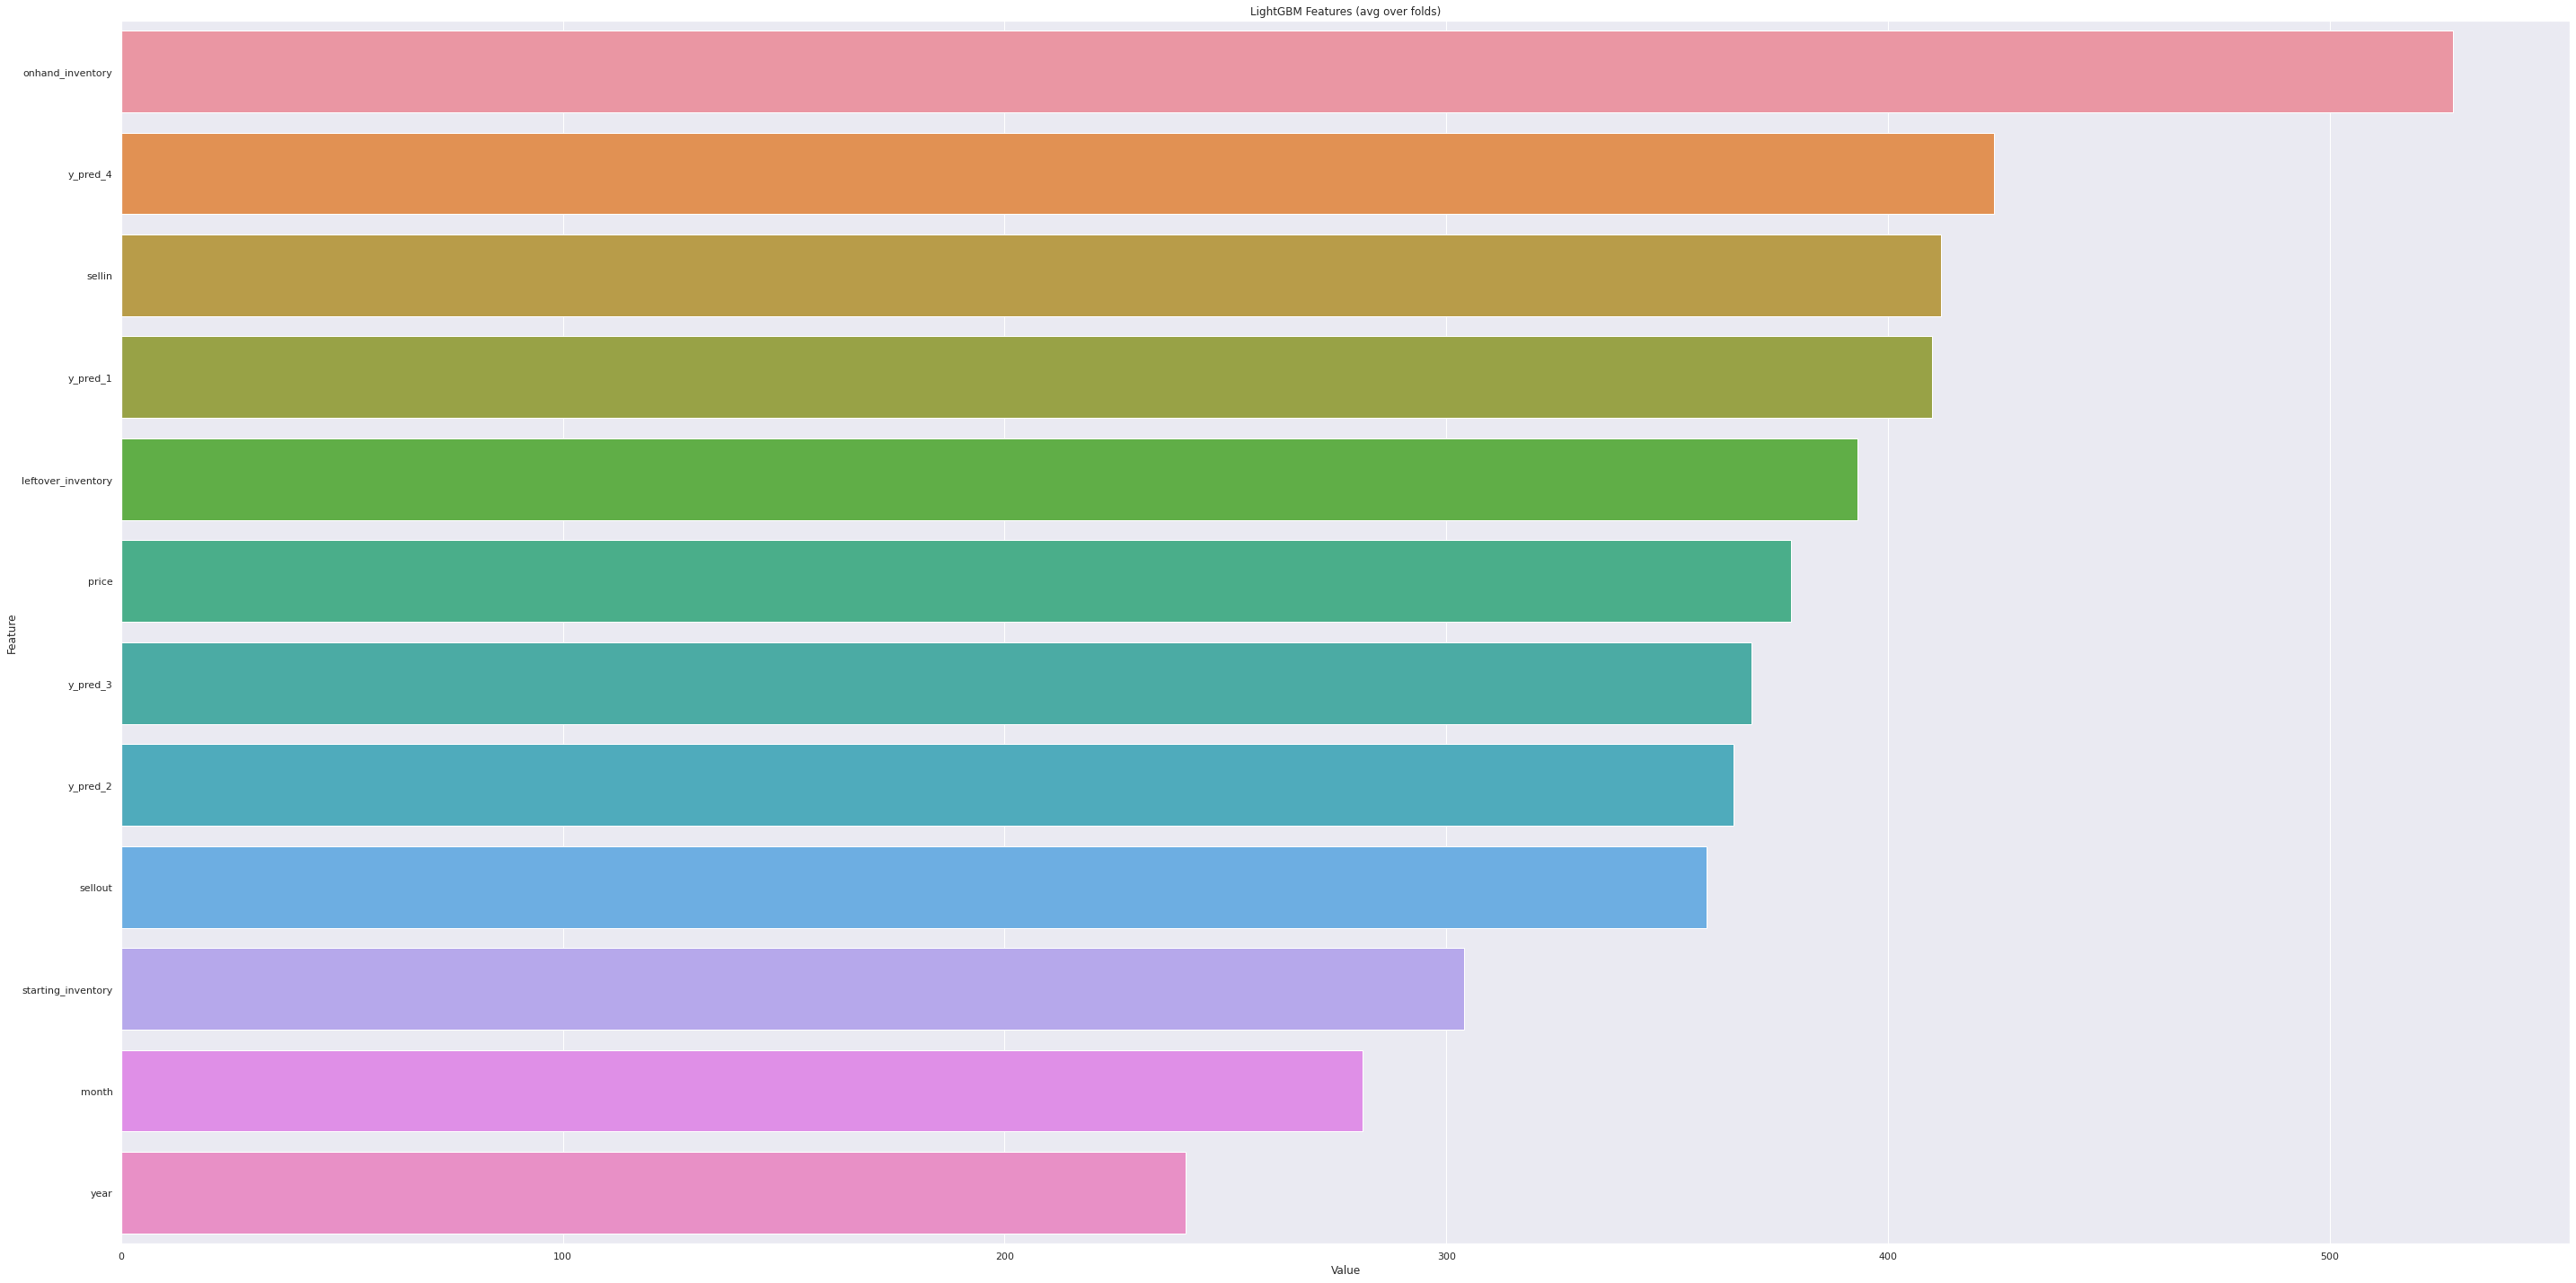

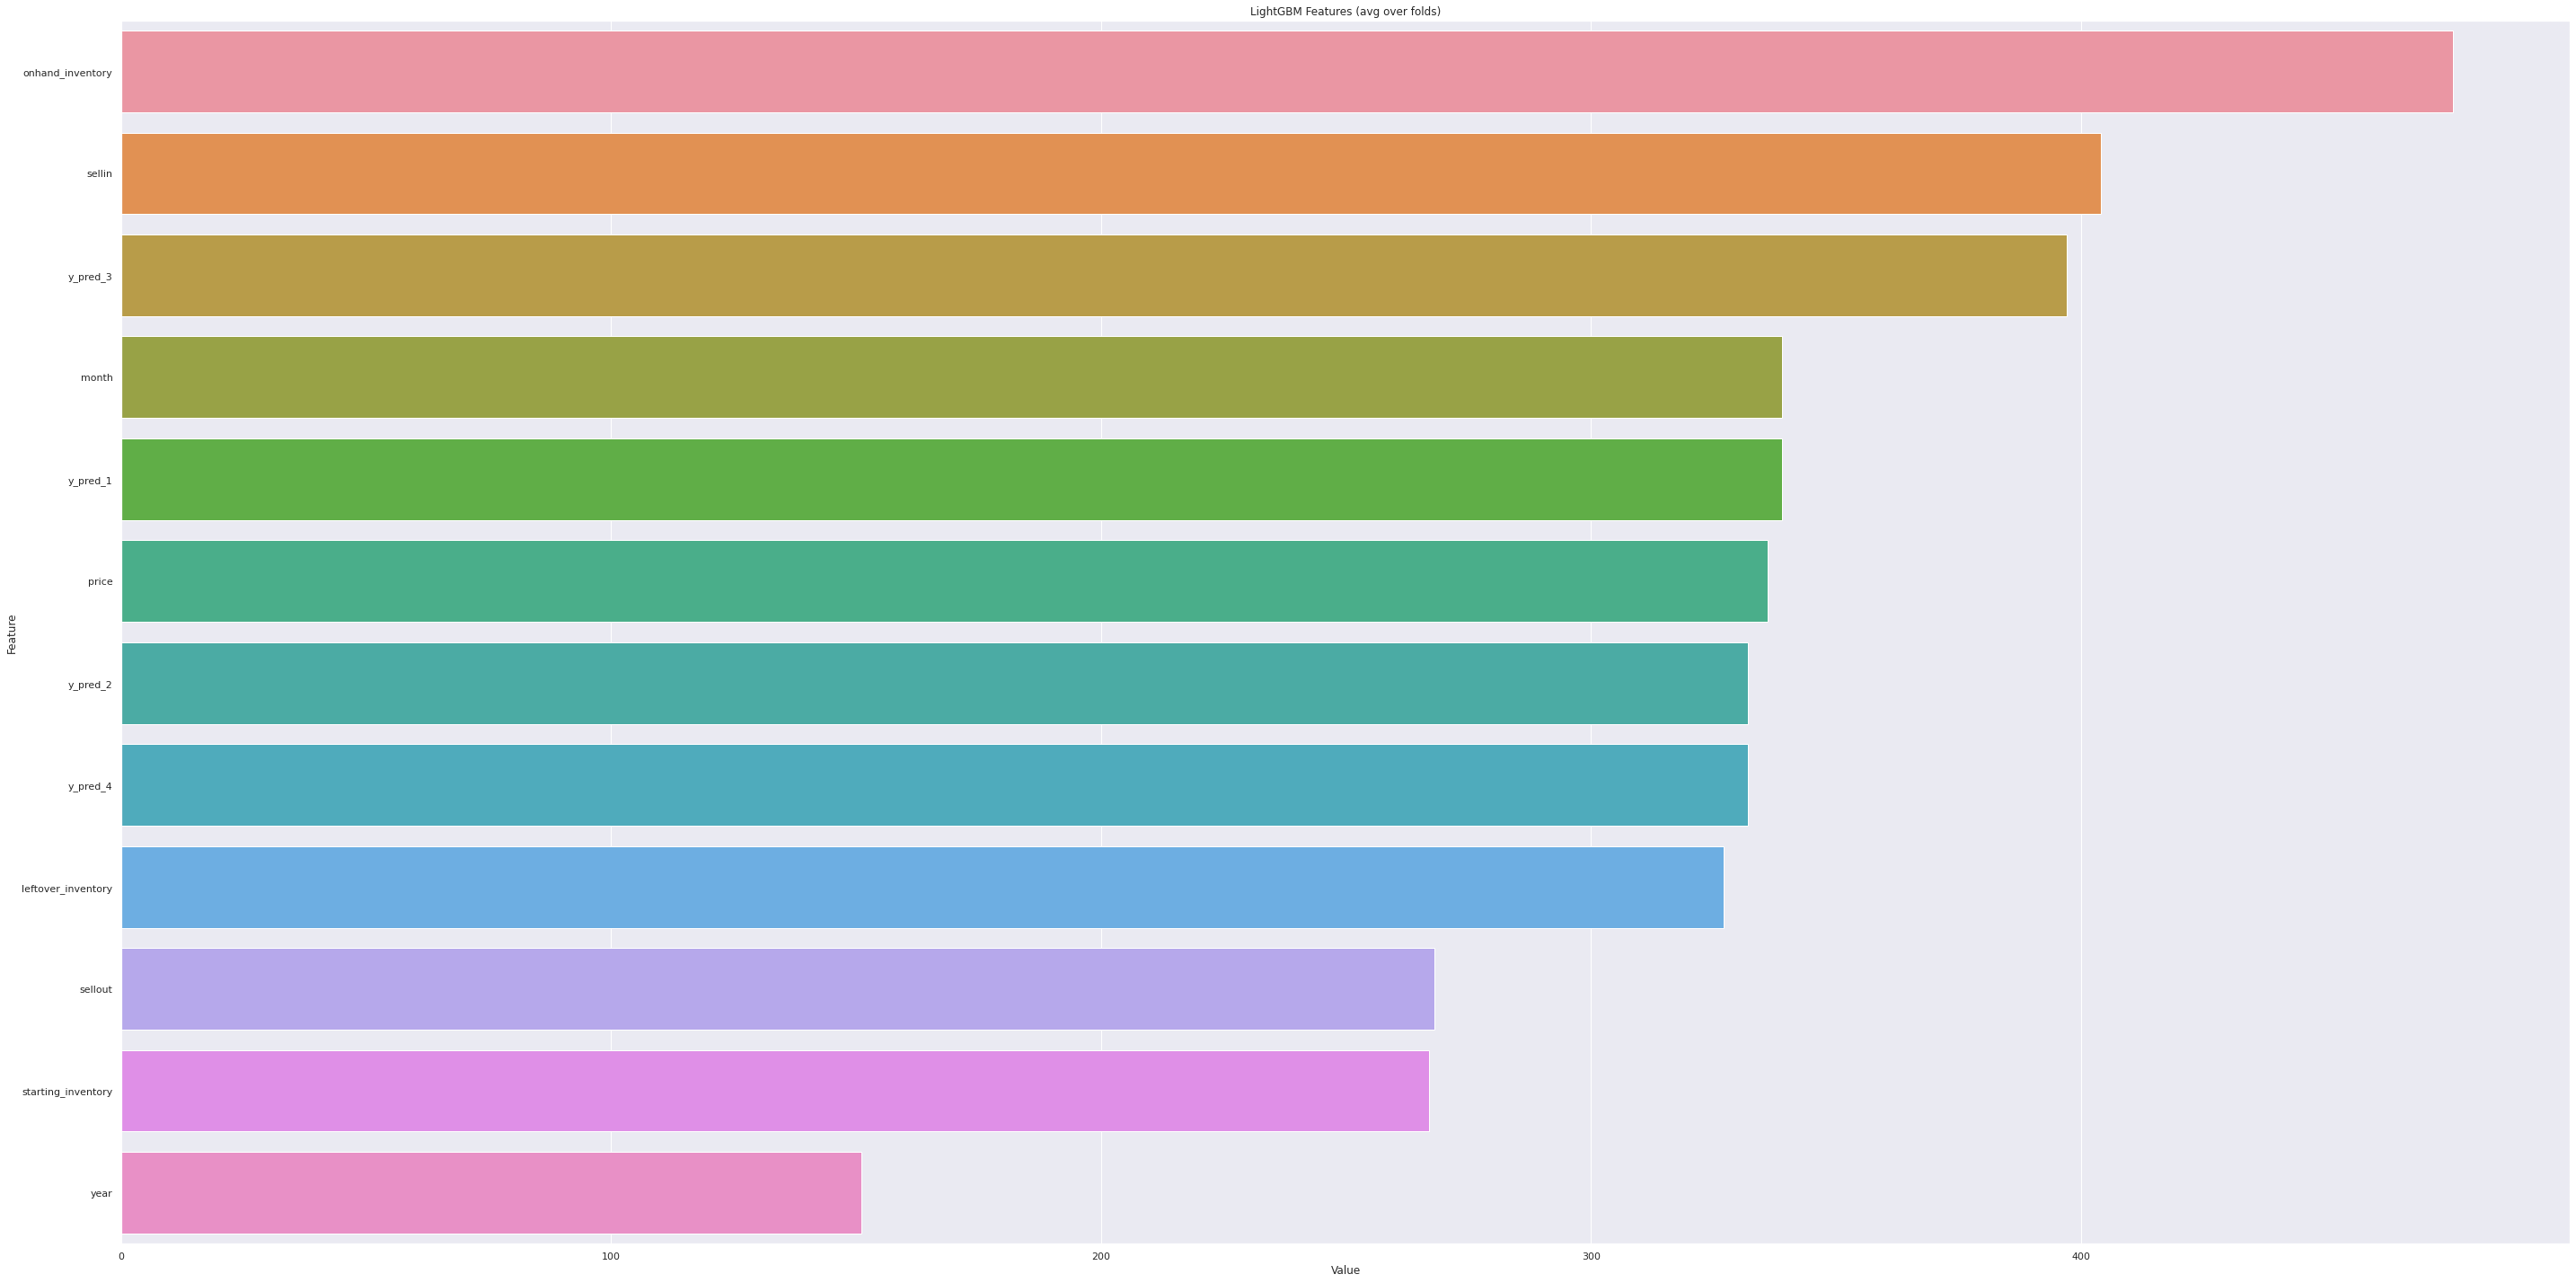

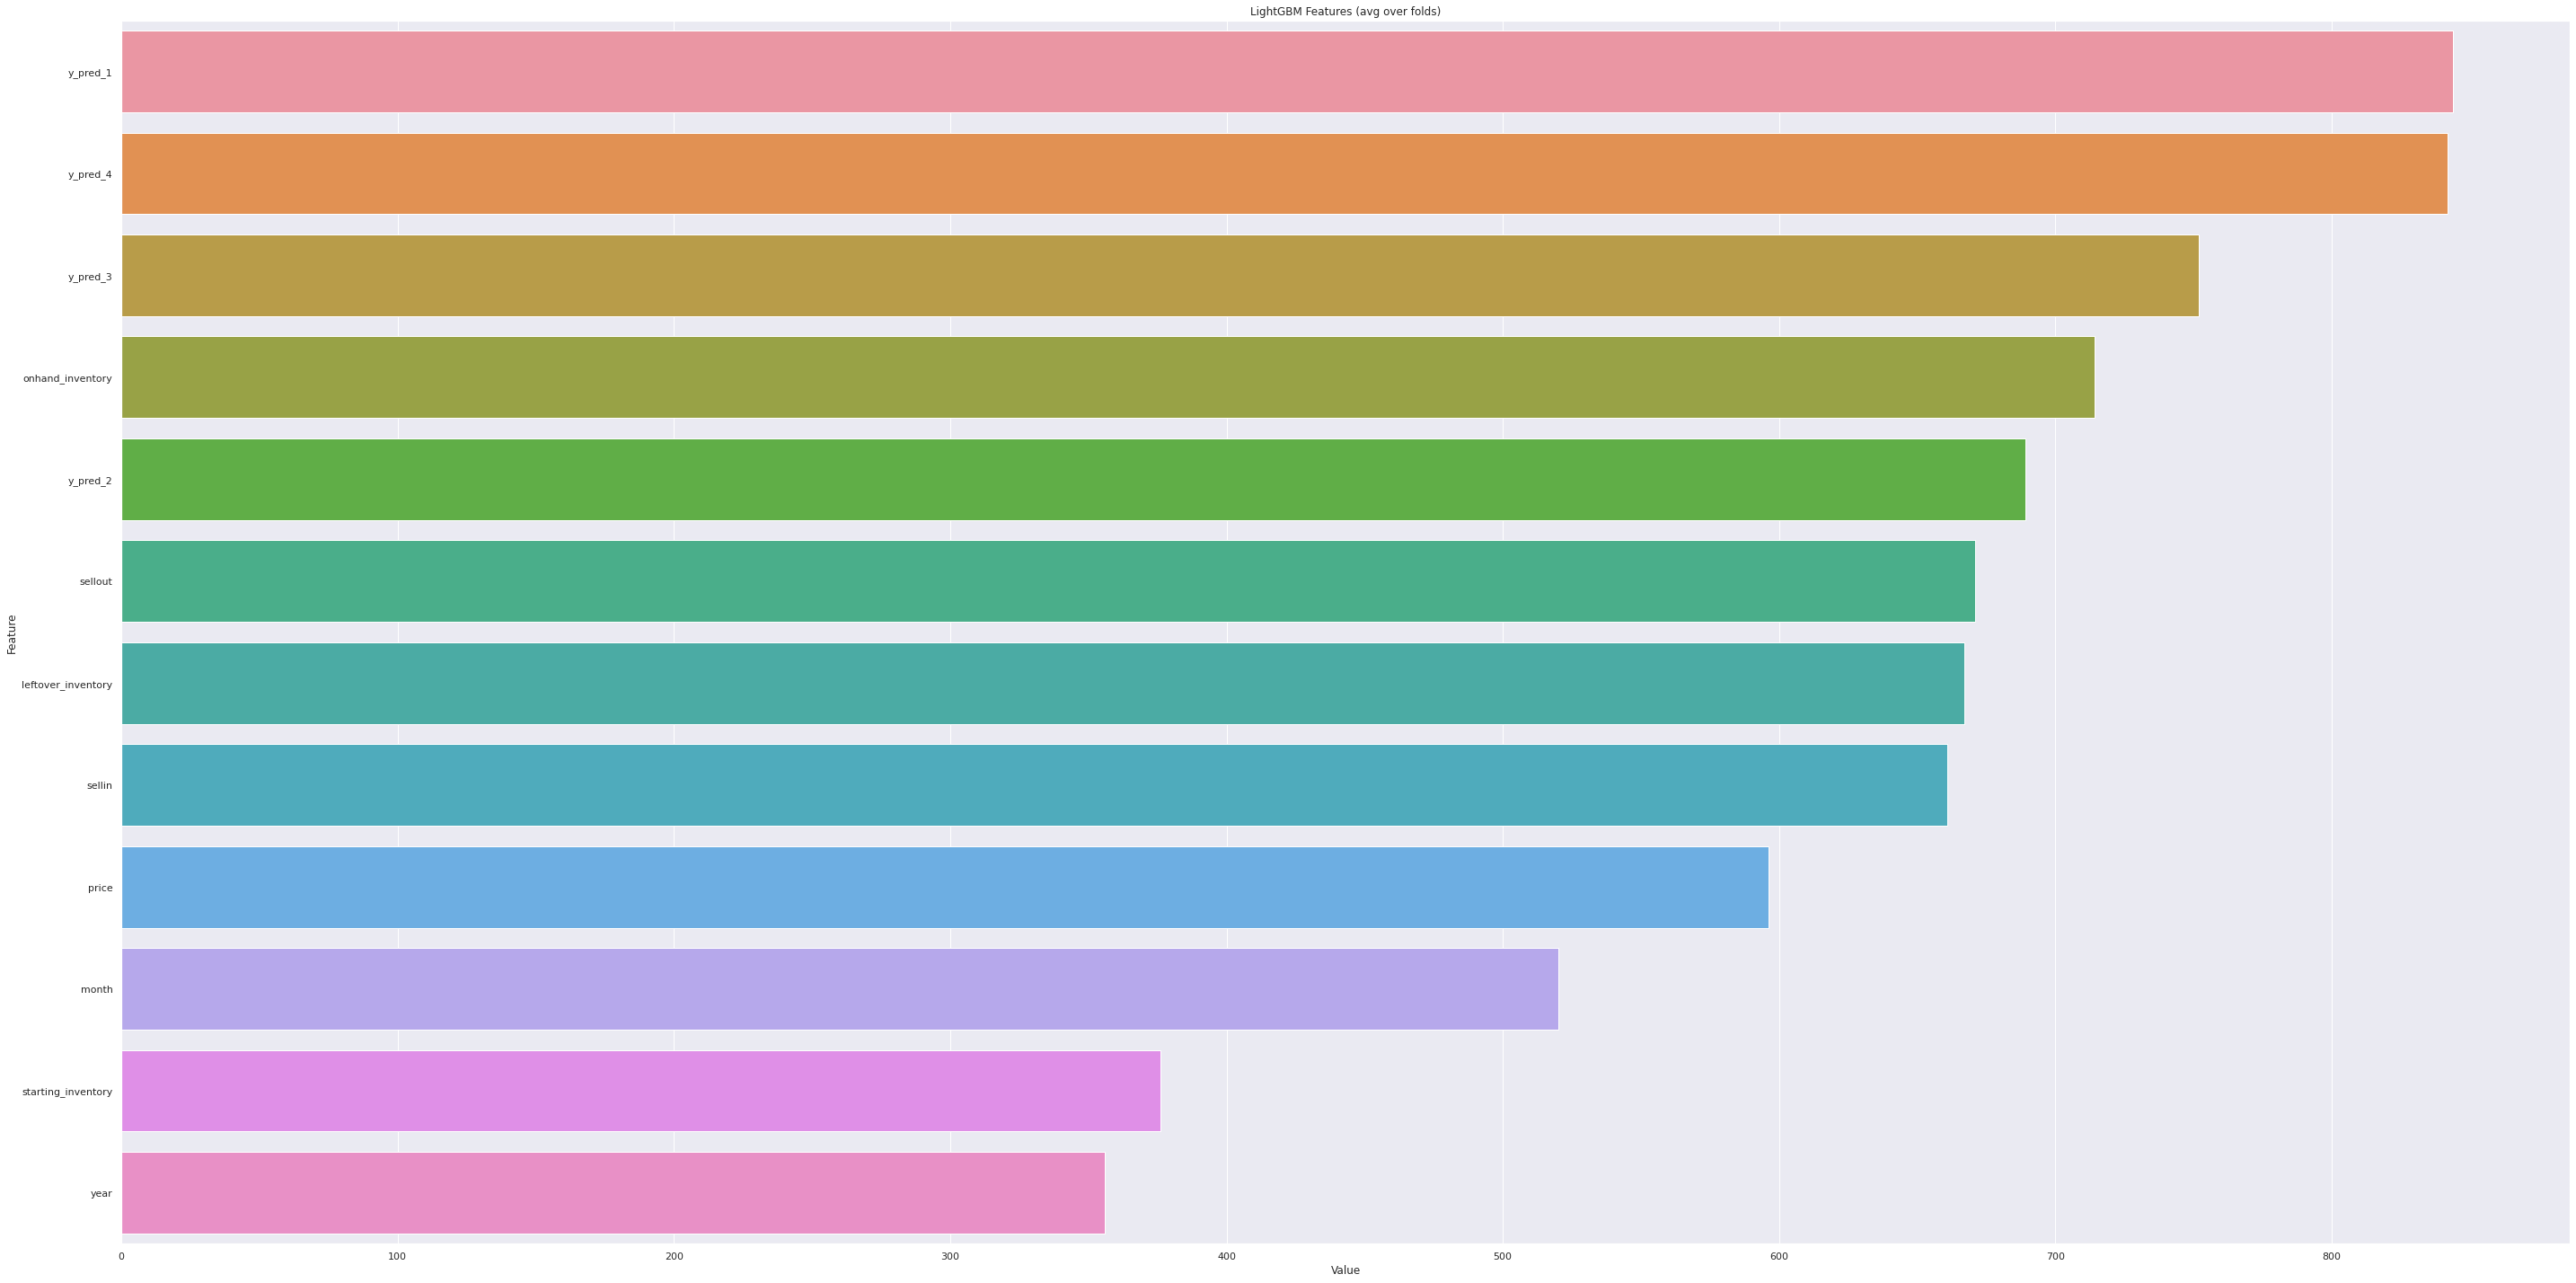

In [245]:
feature_importance = cv_feature_importance_plot(train_data, val_data, folds, cv_models)

In [17]:
def prepare_fold_data(dataset):
    x, y, te = [], [], []
    
    for d in dataset:
        x.append(d[0][0])
        te.append(d[1])
        
        d[0][1]['target'] = 'target_'+d[0][1].groupby('sku_name').cumcount().astype(str)
        # print(t[0][1],t[0][1].pivot_table(columns='target', index='sku_name', values ='sellin').reset_index())
        y.append(d[0][1].pivot_table(columns='target', index='sku_name', values ='sellin').reset_index())
        
    features, targets = pd.concat(x, axis=0).sort_values(by=['sku_name','year','month']), pd.DataFrame(np.repeat(pd.concat(y, axis=0).values, LOOKBACK, axis=0), columns=pd.concat(y, axis=0).columns)
    
    test = pd.concat(te, axis=0)
    return features, targets, test

In [20]:
import gc

def train_model(train_data: list, val_data:list, folds: int, store_cv_models: bool=False):
    cv_models = []
    size = len(train_data)//folds

    start_time = time()
    for fold in range(folds):
        print(f'Training fold {fold+1}')
        print('\n')
        train_set = train_data[:(fold+1)*size]
        val_set = [val_data[((fold+1)*size)-1]]
        
        x_train, y_train, _ = prepare_fold_data(train_set)
        x_val, y_val, _ = prepare_fold_data(val_set)
        
        models = multi_step_train(params, x_train, y_train, x_val, y_val, store_cv_models, fold)

        gc.collect()
        
        print("Elapsed {:.2f} mins".format((time() - start_time)/60))
        print('-'*50)
        print('\n')
              
        del(x_train, y_train)
        gc.collect()
        cv_models.append(models)

    return cv_models